## ベイズの識別規則

### MNISTの0と1をベイズの識別規則を使って分類してみる

まずはMNISTのデータをダウンロードする。
機械学習ライブラリにはだいたい有名なデータセットが簡単にダウンロードできるようになっている。
今回はscikit-learnを使う。
その他のライブラリでは[ここ](https://kakedashi-engineer.appspot.com/2020/02/10/mnist/)を参考に。

In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", return_X_y=True)

データが70000個。
- X: 28x28の画像のピクセルが平らに並べられている。
- y: それぞれの画像に対するラベルが入っている (str)

In [2]:
print(X.shape, y.shape)

(70000, 784) (70000,)


今回は0と1だけを使うので、それ以外は捨てていい。
NumPyを使う。

In [3]:
import numpy as np
IMG = np.empty((0, 28, 28), float)
LABEL = []
for img, label in zip(X, y):
    if label == "0" or label == "1":
        # reshapeは置き換えてくれるわけではないので注意
        img = img.reshape((1, 28, 28))
        IMG = np.append(IMG, img, axis=0)
        LABEL.append(label)

いま、`IMG`には画像データ、`LABEL`にはそれに対応したラベルが入っている。
matplotlibを使って可視化してみる。

label: 0
image:


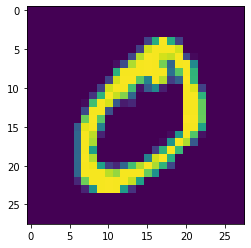

In [4]:
from matplotlib import pyplot as plt
print("label:", LABEL[0])
print("image:")
plt.imshow(IMG[0])

In [5]:
cnt = 0
for label in LABEL:
    if label == '0':
        cnt += 1
print("label 0: ", cnt)
print("label 1: ", len(LABEL) - cnt)

label 0:  6903
label 1:  7877


今回は、
1. 28x28の画像データの端の方のデータを5pxずつ除いて、18x18の画像データにした後、
2. 3x3の画像データにして、
3. 2値表現に直す
4. 3x3を平らにする

ベイズの識別規則を適用する。

「初めてのパターン認識」p23,表3.1のように今回のデータを整理すると、以下のようになる。

数字はテキトー。

||サンプル数|0番目のデータ==0|1番目のデータ==0|...|9番目のデータ==0|
|---|---|---|---|---|---|
|ラベル0|6903|0|5|...|8|
|ラベル1|7877|0|65|...|7|

1. まず、5pxずつ除く

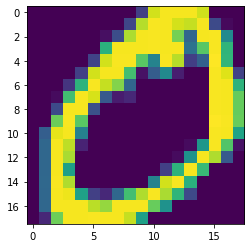

In [6]:
IMG_18x18 = IMG[:, 5:-5, 5:-5]
plt.imshow(IMG_18x18[0])

次に3x3の画像データに直す。ここでは、6x6のブロックを作ってそれぞれの平均を取る。

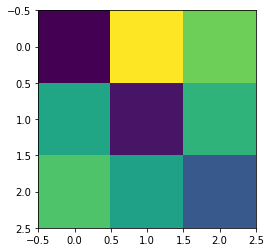

In [7]:
IMG_3x3 = np.empty((IMG_18x18.shape[0], 3, 3))
for i in range(3):
    for j in range(3):
        IMG_3x3[:, i, j] = np.mean(IMG_18x18[:, 6*i: 6*(i+1), 6*j: 6*(j+1)], axis=(1,2))
plt.imshow(IMG_3x3[0])

次に2値化する

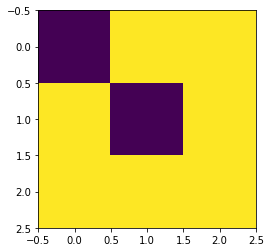

In [8]:
IMG_3x3_BIN = np.empty(IMG_3x3.shape)
threshold = 32.0
IMG_3x3_BIN[IMG_3x3 > threshold] = 1.0
IMG_3x3_BIN[IMG_3x3 <= threshold] = 0.0
plt.imshow(IMG_3x3_BIN[0])

平坦化する

In [9]:
IMG_FLATTENED = IMG_3x3_BIN.reshape(-1, 9)
print(IMG_FLATTENED.shape)
print(IMG_FLATTENED[0])

(14780, 9)
[0. 1. 1. 1. 0. 1. 1. 1. 1.]


ベイズの識別規則を使う前に、学習データとテストデータを分けておく。

In [10]:
from sklearn.model_selection import train_test_split
# 8 : 2
LABEL = np.array(LABEL)
X_train, X_test, y_train, y_test = train_test_split(
    IMG_FLATTENED, LABEL, test_size=0.2)

表にまとめる。以下のように、カウントをしていき、記録する。

||サンプル数|0番目のデータ==0|1番目のデータ==0|...|9番目のデータ==0|
|---|---|---|---|---|---|
|ラベル0|6903|0|5|...|8|
|ラベル1|7877|0|65|...|7|


0:  [2651. 5482. 5428. 5429. 2076. 5327. 5451. 5263. 5124.]
1:  [  69. 5362. 2699.   44. 6308.  274. 1626. 6238.  234.]


([<matplotlib.axis.XTick at 0x7fcc7d07ba90>,
 <a list of 9 Text xticklabel objects>)

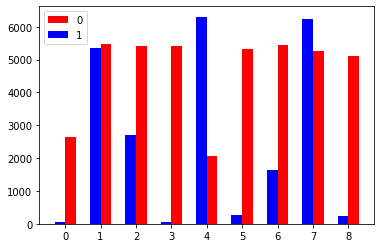

In [11]:
table0 = np.sum(X_train[y_train=="0"], axis=0)
table1 = np.sum(X_train[y_train=="1"], axis=0)
print("0: ", table0)
print("1: ", table1)
width = 0.3
plt.bar([i + width for i in range(9)],
        table0,
        color='r',
        label="0",
        align="center",
        width=width)
plt.bar([i for i in range(9)],
        table1,
        color='b',
        label="1",
        align="center",
        width=width)
plt.legend(loc=2)
plt.xticks([i + width/2 for i in range(9)], [str(i) for i in range(9)])

グラフを見る限り、確率で分けることができそう。

$ P(label|feature_0,feature_1,...,feature_8) = {{P(feature_0,feature_1,...,feature_8|label)P(label)} \over P(feature_0,feature_1,...,feature_8)}$

から、左辺を求めると、分類ができることがわかる。

まず、$ P(label)を求める。$

In [12]:
from IPython.display import display, Markdown

# label == 0の数
data_size0 = len(X_train[y_train == "0"])
# label == 1の数
data_size1 = len(X_train[y_train == "1"])

md = f'''
||サンプル数|{'|'.join([str(i) for i in range(9)])}|
|---|---|{'|'.join(['---' for _ in range(9)])}|
|ラベル0|{data_size0}|{'|'.join([str(d) for d in table0])}|
|ラベル1|{data_size1}|{'|'.join([str(d) for d in table1])}|
'''
display(Markdown(md))


||サンプル数|0|1|2|3|4|5|6|7|8|
|---|---|---|---|---|---|---|---|---|---|---|
|ラベル0|5513|2651.0|5482.0|5428.0|5429.0|2076.0|5327.0|5451.0|5263.0|5124.0|
|ラベル1|6311|69.0|5362.0|2699.0|44.0|6308.0|274.0|1626.0|6238.0|234.0|


$ P(label=0) = {DataSize_0 \over DataSize_0 + DataSize_1} $, 
$ P(label=1) = {DataSize_1 \over DataSize_0 + DataSize_1} $

であるから、それぞれ

In [13]:
from IPython.display import Latex
p_label = np.array([
    data_size0/(data_size0 + data_size1),  # P(label=0)
    data_size1/(data_size0 + data_size1),  # P(label=1)
])
tex = f'''
 $$ P(label=0) = {{DataSize_0 \over DataSize_0 + DataSize_1}} = {"{:.3f}".format(p_label[0])} $$
 
 $$ P(label=1) = {{DataSize_1 \over DataSize_0 + DataSize_1}} = {"{:.3f}".format(p_label[1])} $$
'''
display(Latex(tex))

<IPython.core.display.Latex object>

次に、$ P(feature_0,feature_1,...,feature_8|label) $ を求めたい。それには以下の式が使える。

$ P(feature_0,feature_1,...,feature_8|label)=\prod_{i=0}^8 P(feature_i|label) $

ラベルがわかったときの9つのそれぞれの特徴の条件付き確率を表にする。
つまり、$ P(feature|label) $を表にする。

In [14]:
prob_table = np.array([
    [(data_size0 - d) / data_size0 for d in table0],  # P(f_i=0|label=0)
    [(data_size1 - d) / data_size1 for d in table1],  # P(f_i=0|label=1)
    [d / data_size0 for d in table0],  # P(f_i=1|label=0)
    [d / data_size1 for d in table1],  # P(f_i=1|label=1)
])
md = f'''
||{'|'.join([f"$feature_{i}$" for i in range(9)])}|
|---|{'|'.join(['---' for _ in range(9)])}|
|$P(feature_i=0|label=0)$|{'|'.join(["{:.6f}".format(p) for p in prob_table[0]])}|
|$P(feature_i=0|label=1)$|{'|'.join(["{:.6f}".format(p) for p in prob_table[1]])}|
|$P(feature_i=1|label=0)$|{'|'.join(["{:.6f}".format(p) for p in prob_table[2]])}|
|$P(feature_i=1|label=1)$|{'|'.join(["{:.6f}".format(p) for p in prob_table[3]])}|
'''
display(Markdown(md))


||$feature_0$|$feature_1$|$feature_2$|$feature_3$|$feature_4$|$feature_5$|$feature_6$|$feature_7$|$feature_8$|
|---|---|---|---|---|---|---|---|---|---|
|$P(feature_i=0|label=0)$|0.519137|0.005623|0.015418|0.015237|0.623436|0.033738|0.011246|0.045347|0.070560|
|$P(feature_i=0|label=1)$|0.989067|0.150372|0.572334|0.993028|0.000475|0.956584|0.742355|0.011567|0.962922|
|$P(feature_i=1|label=0)$|0.480863|0.994377|0.984582|0.984763|0.376564|0.966262|0.988754|0.954653|0.929440|
|$P(feature_i=1|label=1)$|0.010933|0.849628|0.427666|0.006972|0.999525|0.043416|0.257645|0.988433|0.037078|


$ P(feature0,feature1,...,feature8|label) $を求める。
その結果をNumpy配列に入れる。
`p_features`は10次元配列で、0次元目にはラベル、1次元目以降には対応する特徴量が入る。

In [15]:
from itertools import product
from functools import reduce

p_features_cond_label = np.ones((2,) * (1 + 9))

for idx in product((0, 1), repeat=1+9):
    label = idx[0]
    for i, b in enumerate(idx[1:]):
        p_features_cond_label[idx] *= prob_table[2 * b + label, i]

md = """|label|features|probability|
        |---|---|---|
        """
for idx in product((0,1), repeat=1+9):
    md += f"|{idx[0]}|{idx[1:]}|{p_features_cond_label[idx]}|\n"
    
display(Markdown(md))

|label|features|probability|
        |---|---|---|
        |0|(0, 0, 0, 0, 0, 0, 0, 0, 0)|5.190526092648203e-13|
|0|(0, 0, 0, 0, 0, 0, 0, 0, 1)|6.837083727179792e-12|
|0|(0, 0, 0, 0, 0, 0, 0, 1, 0)|1.0927095530242996e-11|
|0|(0, 0, 0, 0, 0, 0, 0, 1, 1)|1.43934286624589e-10|
|0|(0, 0, 0, 0, 0, 0, 1, 0, 0)|4.563477053391186e-11|
|0|(0, 0, 0, 0, 0, 0, 1, 0, 1)|6.011119902718878e-10|
|0|(0, 0, 0, 0, 0, 0, 1, 1, 0)|9.607031892799123e-10|
|0|(0, 0, 0, 0, 0, 0, 1, 1, 1)|1.2654609619203782e-08|
|0|(0, 0, 0, 0, 0, 1, 0, 0, 0)|1.4865555105127404e-11|
|0|(0, 0, 0, 0, 0, 1, 0, 0, 1)|1.9581260760584275e-10|
|0|(0, 0, 0, 0, 0, 1, 0, 1, 0)|3.1294966607314214e-10|
|0|(0, 0, 0, 0, 0, 1, 0, 1, 1)|4.122247015318201e-09|
|0|(0, 0, 0, 0, 0, 1, 1, 0, 0)|1.3069700141620886e-09|
|0|(0, 0, 0, 0, 0, 1, 1, 0, 1)|1.7215718129991112e-08|
|0|(0, 0, 0, 0, 0, 1, 1, 1, 0)|2.7514332738140288e-08|
|0|(0, 0, 0, 0, 0, 1, 1, 1, 1)|3.6242529807257287e-07|
|0|(0, 0, 0, 0, 1, 0, 0, 0, 0)|3.135156289885851e-13|
|0|(0, 0, 0, 0, 1, 0, 0, 0, 1)|4.1297020126928284e-12|
|0|(0, 0, 0, 0, 1, 0, 0, 1, 0)|6.600131021467694e-12|
|0|(0, 0, 0, 0, 1, 0, 0, 1, 1)|8.693848677120941e-11|
|0|(0, 0, 0, 0, 1, 0, 1, 0, 0)|2.7564091832528664e-11|
|0|(0, 0, 0, 0, 1, 0, 1, 0, 1)|3.630807366320742e-10|
|0|(0, 0, 0, 0, 1, 0, 1, 1, 0)|5.802792612583934e-10|
|0|(0, 0, 0, 0, 1, 0, 1, 1, 1)|7.643575667578427e-09|
|0|(0, 0, 0, 0, 1, 1, 0, 0, 0)|8.979020191517165e-12|
|0|(0, 0, 0, 0, 1, 1, 0, 0, 1)|1.1827377753556287e-10|
|0|(0, 0, 0, 0, 1, 1, 0, 1, 0)|1.8902633307181938e-10|
|0|(0, 0, 0, 0, 1, 1, 0, 1, 1)|2.4898995646786696e-09|
|0|(0, 0, 0, 0, 1, 1, 1, 0, 0)|7.894296623219365e-10|
|0|(0, 0, 0, 0, 1, 1, 1, 0, 1)|1.039855421526376e-08|
|0|(0, 0, 0, 0, 1, 1, 1, 1, 0)|1.6619073251201406e-08|
|0|(0, 0, 0, 0, 1, 1, 1, 1, 1)|2.1891036333973267e-07|
|0|(0, 0, 0, 1, 0, 0, 0, 0, 0)|3.3546864472603674e-11|
|0|(0, 0, 0, 1, 0, 0, 0, 0, 1)|4.418872327959415e-10|
|0|(0, 0, 0, 1, 0, 0, 0, 1, 0)|7.062285908772526e-10|
|0|(0, 0, 0, 1, 0, 0, 0, 1, 1)|9.302610024820162e-09|
|0|(0, 0, 0, 1, 0, 0, 1, 0, 0)|2.9494186812929456e-09|
|0|(0, 0, 0, 1, 0, 0, 1, 0, 1)|3.885044041888189e-08|
|0|(0, 0, 0, 1, 0, 0, 1, 1, 0)|6.209116207857909e-08|
|0|(0, 0, 0, 1, 0, 0, 1, 1, 1)|8.178794716983015e-07|
|0|(0, 0, 0, 1, 0, 1, 0, 0, 0)|9.607749841159128e-10|
|0|(0, 0, 0, 1, 0, 1, 0, 0, 1)|1.2655555317763336e-08|
|0|(0, 0, 0, 1, 0, 1, 0, 1, 0)|2.02262349656082e-08|
|0|(0, 0, 0, 1, 0, 1, 0, 1, 1)|2.6642475054955376e-07|
|0|(0, 0, 0, 1, 0, 1, 1, 0, 0)|8.447071674864258e-08|
|0|(0, 0, 0, 1, 0, 1, 1, 0, 1)|1.1126682586633539e-06|
|0|(0, 0, 0, 1, 0, 1, 1, 1, 0)|1.7782775289924238e-06|
|0|(0, 0, 0, 1, 0, 1, 1, 1, 1)|2.3423892181380927e-05|
|0|(0, 0, 0, 1, 1, 0, 0, 0, 0)|2.0262813687845575e-11|
|0|(0, 0, 0, 1, 1, 0, 0, 0, 1)|2.669065741298733e-10|
|0|(0, 0, 0, 1, 1, 0, 0, 1, 0)|4.26572753756525e-10|
|0|(0, 0, 0, 1, 1, 0, 0, 1, 1)|5.618917198582093e-09|
|0|(0, 0, 0, 1, 1, 0, 1, 0, 0)|1.7814935066523582e-09|
|0|(0, 0, 0, 1, 1, 0, 1, 0, 1)|2.3466253799708698e-08|
|0|(0, 0, 0, 1, 1, 0, 1, 1, 0)|3.750400130204545e-08|
|0|(0, 0, 0, 1, 1, 0, 1, 1, 1)|4.940115749914675e-07|
|0|(0, 0, 0, 1, 1, 1, 0, 0, 0)|5.803226264255558e-10|
|0|(0, 0, 0, 1, 1, 1, 0, 0, 1)|7.644146883816318e-09|
|0|(0, 0, 0, 1, 1, 1, 0, 1, 0)|1.22169519315108e-08|
|0|(0, 0, 0, 1, 1, 1, 0, 1, 1)|1.6092458019810113e-07|
|0|(0, 0, 0, 1, 1, 1, 1, 0, 0)|5.102159091364039e-08|
|0|(0, 0, 0, 1, 1, 1, 1, 0, 1)|6.720684623174636e-07|
|0|(0, 0, 0, 1, 1, 1, 1, 1, 0)|1.0741065319139573e-06|
|0|(0, 0, 0, 1, 1, 1, 1, 1, 1)|1.4148385268707244e-05|
|0|(0, 0, 1, 0, 0, 0, 0, 0, 0)|3.314608897752288e-11|
|0|(0, 0, 1, 0, 0, 0, 0, 0, 1)|4.366081231897872e-10|
|0|(0, 0, 1, 0, 0, 0, 0, 1, 0)|6.977914651548116e-10|
|0|(0, 0, 1, 0, 0, 0, 0, 1, 1)|9.191474209391402e-09|
|0|(0, 0, 1, 0, 0, 0, 1, 0, 0)|2.9141827583302766e-09|
|0|(0, 0, 1, 0, 0, 0, 1, 0, 1)|3.838630450818596e-08|
|0|(0, 0, 1, 0, 0, 0, 1, 1, 0)|6.134937542836899e-08|
|0|(0, 0, 1, 0, 0, 0, 1, 1, 1)|8.08108482506331e-07|
|0|(0, 0, 1, 0, 0, 1, 0, 0, 0)|9.49296860125077e-10|
|0|(0, 0, 1, 0, 0, 1, 0, 0, 1)|1.2504362753935464e-08|
|0|(0, 0, 1, 0, 0, 1, 0, 1, 0)|1.9984597499353124e-08|
|0|(0, 0, 1, 0, 0, 1, 0, 1, 1)|2.6324184469584936e-07|
|0|(0, 0, 1, 0, 0, 1, 1, 0, 0)|8.346156749260959e-08|
|0|(0, 0, 1, 0, 0, 1, 1, 0, 1)|1.0993755059951968e-06|
|0|(0, 0, 1, 0, 0, 1, 1, 1, 0)|1.7570329188544172e-06|
|0|(0, 0, 1, 0, 0, 1, 1, 1, 1)|2.3144053152210884e-05|
|0|(0, 0, 1, 0, 1, 0, 0, 0, 0)|2.0020739225294585e-11|
|0|(0, 0, 1, 0, 1, 0, 0, 0, 1)|2.6371791205760784e-10|
|0|(0, 0, 1, 0, 1, 0, 0, 1, 0)|4.214766021709016e-10|
|0|(0, 0, 1, 0, 1, 0, 0, 1, 1)|5.55178948463676e-09|
|0|(0, 0, 1, 0, 1, 0, 1, 0, 0)|1.760210476081948e-09|
|0|(0, 0, 1, 0, 1, 0, 1, 0, 1)|2.3185908687516457e-08|
|0|(0, 0, 1, 0, 1, 0, 1, 1, 0)|3.705595094247717e-08|
|0|(0, 0, 1, 0, 1, 0, 1, 1, 1)|4.881097496895965e-07|
|0|(0, 0, 1, 0, 1, 1, 0, 0, 0)|5.733896658771197e-10|
|0|(0, 0, 1, 0, 1, 1, 0, 0, 1)|7.552824287800415e-09|
|0|(0, 0, 1, 0, 1, 1, 0, 1, 0)|1.2070999246045124e-08|
|0|(0, 0, 1, 0, 1, 1, 0, 1, 1)|1.5900205690677431e-07|
|0|(0, 0, 1, 0, 1, 1, 1, 0, 0)|5.041204949509965e-08|
|0|(0, 0, 1, 0, 1, 1, 1, 0, 1)|6.640394385935492e-07|
|0|(0, 0, 1, 0, 1, 1, 1, 1, 0)|1.061274465970838e-06|
|0|(0, 0, 1, 0, 1, 1, 1, 1, 1)|1.3979358261271397e-05|
|0|(0, 0, 1, 1, 0, 0, 0, 0, 0)|2.1422632983210916e-09|
|0|(0, 0, 1, 1, 0, 0, 0, 0, 1)|2.8218398819016128e-08|
|0|(0, 0, 1, 1, 0, 0, 0, 1, 0)|4.509892695625562e-08|
|0|(0, 0, 1, 1, 0, 0, 0, 1, 1)|5.940537319379276e-07|
|0|(0, 0, 1, 1, 0, 0, 1, 0, 0)|1.883464070830366e-07|
|0|(0, 0, 1, 1, 0, 0, 1, 0, 1)|2.480943418749305e-06|
|0|(0, 0, 1, 1, 0, 0, 1, 1, 0)|3.965068561912087e-06|
|0|(0, 0, 1, 1, 0, 0, 1, 1, 1)|5.2228820851510375e-05|
|0|(0, 0, 1, 1, 0, 1, 0, 0, 0)|6.135396016213148e-08|
|0|(0, 0, 1, 1, 0, 1, 0, 0, 1)|8.081688737037576e-07|
|0|(0, 0, 1, 1, 0, 1, 0, 1, 0)|1.2916235693331922e-06|
|0|(0, 0, 1, 1, 0, 1, 0, 1, 1)|1.7013571129211508e-05|
|0|(0, 0, 1, 1, 0, 1, 1, 0, 0)|5.394200594254494e-06|
|0|(0, 0, 1, 1, 0, 1, 1, 0, 1)|7.1053685976761e-05|
|0|(0, 0, 1, 1, 0, 1, 1, 1, 0)|0.00011355871091024561|
|0|(0, 0, 1, 1, 0, 1, 1, 1, 1)|0.0014958221971827727|
|0|(0, 0, 1, 1, 1, 0, 0, 0, 0)|1.2939594435014797e-09|
|0|(0, 0, 1, 1, 1, 0, 0, 0, 1)|1.704433981619944e-08|
|0|(0, 0, 1, 1, 1, 0, 0, 1, 0)|2.7240434204593152e-08|
|0|(0, 0, 1, 1, 1, 0, 0, 1, 1)|3.588174418106306e-07|
|0|(0, 0, 1, 1, 1, 0, 1, 0, 0)|1.137640794601059e-07|
|0|(0, 0, 1, 1, 1, 0, 1, 0, 1)|1.498527360291986e-06|
|0|(0, 0, 1, 1, 1, 0, 1, 1, 0)|2.3949614007941494e-06|
|0|(0, 0, 1, 1, 1, 0, 1, 1, 1)|3.154699798886689e-05|
|0|(0, 0, 1, 1, 1, 1, 0, 0, 0)|3.7058720191034316e-08|
|0|(0, 0, 1, 1, 1, 1, 0, 0, 1)|4.881462268865291e-07|
|0|(0, 0, 1, 1, 1, 1, 0, 1, 0)|7.801601774616545e-07|
|0|(0, 0, 1, 1, 1, 1, 0, 1, 1)|1.0276454368415212e-05|
|0|(0, 0, 1, 1, 1, 1, 1, 0, 0)|3.2581787703440007e-06|
|0|(0, 0, 1, 1, 1, 1, 1, 0, 1)|4.291750133481404e-05|
|0|(0, 0, 1, 1, 1, 1, 1, 1, 0)|6.859117947328189e-05|
|0|(0, 0, 1, 1, 1, 1, 1, 1, 1)|0.000903499238100505|
|0|(0, 1, 0, 0, 0, 0, 0, 0, 0)|9.178859367708857e-11|
|0|(0, 1, 0, 0, 0, 0, 0, 0, 1)|1.209061064270956e-09|
|0|(0, 1, 0, 0, 0, 0, 0, 1, 0)|1.9323334740900686e-09|
|0|(0, 1, 0, 0, 0, 0, 0, 1, 1)|2.5453153525032163e-08|
|0|(0, 1, 0, 0, 0, 0, 1, 0, 0)|8.069993937642091e-09|
|0|(0, 1, 0, 0, 0, 0, 1, 0, 1)|1.0629986873130612e-07|
|0|(0, 1, 0, 0, 0, 0, 1, 1, 0)|1.6988951237524134e-07|
|0|(0, 1, 0, 0, 0, 0, 1, 1, 1)|2.2378248365314567e-06|
|0|(0, 1, 0, 0, 0, 1, 0, 0, 0)|2.6288055834293054e-09|
|0|(0, 1, 0, 0, 0, 1, 0, 0, 1)|3.462724886758808e-08|
|0|(0, 1, 0, 0, 0, 1, 0, 1, 0)|5.534161514235374e-08|
|0|(0, 1, 0, 0, 0, 1, 0, 1, 1)|7.289728431604641e-07|
|0|(0, 1, 0, 0, 0, 1, 1, 0, 0)|2.3112289089150228e-07|
|0|(0, 1, 0, 0, 0, 1, 1, 0, 1)|3.0444053802777832e-06|
|0|(0, 1, 0, 0, 0, 1, 1, 1, 0)|4.865599099047906e-06|
|0|(0, 1, 0, 0, 0, 1, 1, 1, 1)|6.409082206560789e-05|
|0|(0, 1, 0, 0, 1, 0, 0, 0, 0)|5.544169929404592e-11|
|0|(0, 1, 0, 0, 1, 0, 0, 0, 1)|7.302911752768414e-10|
|0|(0, 1, 0, 0, 1, 0, 0, 1, 0)|1.1671586535382548e-09|
|0|(0, 1, 0, 0, 1, 0, 0, 1, 1)|1.5374089821928066e-08|
|0|(0, 1, 0, 0, 1, 0, 1, 0, 0)|4.874398433094263e-09|
|0|(0, 1, 0, 0, 1, 0, 1, 0, 1)|6.420672897474294e-08|
|0|(0, 1, 0, 0, 1, 0, 1, 1, 0)|1.0261583581350042e-07|
|0|(0, 1, 0, 0, 1, 0, 1, 1, 1)|1.3516800583762882e-06|
|0|(0, 1, 0, 0, 1, 1, 0, 0, 0)|1.5878383448353906e-09|
|0|(0, 1, 0, 0, 1, 1, 0, 0, 1)|2.0915382208063087e-08|
|0|(0, 1, 0, 0, 1, 1, 0, 1, 0)|3.342717283547464e-08|
|0|(0, 1, 0, 0, 1, 1, 0, 1, 1)|4.4031062624414417e-07|
|0|(0, 1, 0, 0, 1, 1, 1, 0, 0)|1.3960172286609215e-07|
|0|(0, 1, 0, 0, 1, 1, 1, 0, 1)|1.8388669099379336e-06|
|0|(0, 1, 0, 0, 1, 1, 1, 1, 0)|2.9388954697769722e-06|
|0|(0, 1, 0, 0, 1, 1, 1, 1, 1)|3.8711826188013385e-05|
|0|(0, 1, 0, 1, 0, 0, 0, 0, 0)|5.932384227058498e-09|
|0|(0, 1, 0, 1, 0, 0, 0, 0, 1)|7.814276807055976e-08|
|0|(0, 1, 0, 1, 0, 0, 0, 1, 0)|1.248885527480355e-07|
|0|(0, 1, 0, 1, 0, 0, 0, 1, 1)|1.645061553421424e-06|
|0|(0, 1, 0, 1, 0, 0, 1, 0, 0)|5.215713938983205e-07|
|0|(0, 1, 0, 1, 0, 0, 1, 0, 1)|6.870261754074535e-06|
|0|(0, 1, 0, 1, 0, 0, 1, 1, 0)|1.0980120984347442e-05|
|0|(0, 1, 0, 1, 0, 0, 1, 1, 1)|0.0001446327504467771|
|0|(0, 1, 0, 1, 0, 1, 0, 0, 0)|1.6990220848140117e-07|
|0|(0, 1, 0, 1, 0, 1, 0, 0, 1)|2.237992072644472e-06|
|0|(0, 1, 0, 1, 0, 1, 0, 1, 0)|3.5767812929504575e-06|
|0|(0, 1, 0, 1, 0, 1, 0, 1, 1)|4.711420911331143e-05|
|0|(0, 1, 0, 1, 0, 1, 1, 0, 0)|1.4937692555356736e-05|
|0|(0, 1, 0, 1, 0, 1, 1, 0, 1)|0.00019676281916104863|
|0|(0, 1, 0, 1, 0, 1, 1, 1, 0)|0.00031446830367537005|
|0|(0, 1, 0, 1, 0, 1, 1, 1, 1)|0.004142250868978396|
|0|(0, 1, 0, 1, 1, 0, 0, 0, 0)|3.5832498269925635e-09|
|0|(0, 1, 0, 1, 1, 0, 0, 0, 1)|4.719941417354729e-08|
|0|(0, 1, 0, 1, 1, 0, 0, 1, 0)|7.543457535784745e-08|
|0|(0, 1, 0, 1, 1, 0, 0, 1, 1)|9.936420671815176e-07|
|0|(0, 1, 0, 1, 1, 0, 1, 0, 0)|3.150370130151042e-07|
|0|(0, 1, 0, 1, 1, 0, 1, 0, 1)|4.149742042903326e-06|
|0|(0, 1, 0, 1, 1, 0, 1, 1, 0)|6.6321591979939744e-06|
|0|(0, 1, 0, 1, 1, 0, 1, 1, 1)|8.736036948720084e-05|
|0|(0, 1, 0, 1, 1, 1, 0, 0, 0)|1.0262350445370636e-07|
|0|(0, 1, 0, 1, 1, 1, 0, 0, 1)|1.3517810715187441e-06|
|0|(0, 1, 0, 1, 1, 1, 0, 1, 0)|2.1604300157594263e-06|
|0|(0, 1, 0, 1, 1, 1, 0, 1, 1)|2.84576951176126e-05|
|0|(0, 1, 0, 1, 1, 1, 1, 0, 0)|9.022592302857312e-06|
|0|(0, 1, 0, 1, 1, 1, 1, 0, 1)|0.00011884771969110762|
|0|(0, 1, 0, 1, 1, 1, 1, 1, 0)|0.00018994361315975212|
|0|(0, 1, 0, 1, 1, 1, 1, 1, 1)|0.0025019821949371977|
|0|(0, 1, 1, 0, 0, 0, 0, 0, 0)|5.861511605638078e-09|
|0|(0, 1, 1, 0, 0, 0, 0, 0, 1)|7.720921713956173e-08|
|0|(0, 1, 1, 0, 0, 0, 0, 1, 0)|1.2339654232189283e-07|
|0|(0, 1, 1, 0, 0, 0, 0, 1, 1)|1.6254084392220539e-06|
|0|(0, 1, 1, 0, 0, 0, 1, 0, 0)|5.153403187473091e-07|
|0|(0, 1, 1, 0, 0, 0, 1, 0, 1)|6.7881845585121125e-06|
|0|(0, 1, 1, 0, 0, 0, 1, 1, 0)|1.0848944390268351e-05|
|0|(0, 1, 1, 0, 0, 0, 1, 1, 1)|0.000142904861325797|
|0|(0, 1, 1, 0, 0, 1, 0, 0, 0)|1.6787243184534435e-07|
|0|(0, 1, 1, 0, 0, 1, 0, 0, 1)|2.2112553747443302e-06|
|0|(0, 1, 1, 0, 0, 1, 0, 1, 0)|3.5340504352081893e-06|
|0|(0, 1, 1, 0, 0, 1, 0, 1, 1)|4.6551348149117644e-05|
|0|(0, 1, 1, 0, 0, 1, 1, 0, 0)|1.4759235903047934e-05|
|0|(0, 1, 1, 0, 0, 1, 1, 0, 1)|0.0001944121459311507|
|0|(0, 1, 1, 0, 0, 1, 1, 1, 0)|0.0003107114342309651|
|0|(0, 1, 1, 0, 0, 1, 1, 1, 1)|0.004092764496142585|
|0|(0, 1, 1, 0, 1, 0, 0, 0, 0)|3.5404416913891912e-09|
|0|(0, 1, 1, 0, 1, 0, 0, 0, 1)|4.663553528709053e-08|
|0|(0, 1, 1, 0, 1, 0, 0, 1, 0)|7.453337848712526e-08|
|0|(0, 1, 1, 0, 1, 0, 0, 1, 1)|9.8177128886383e-07|
|0|(0, 1, 1, 0, 1, 0, 1, 0, 0)|3.1127334935100773e-07|
|0|(0, 1, 1, 0, 1, 0, 1, 0, 1)|4.1001661749988785e-06|
|0|(0, 1, 1, 0, 1, 0, 1, 1, 0)|6.552926550537416e-06|
|0|(0, 1, 1, 0, 1, 0, 1, 1, 1)|8.63166983160764e-05|
|0|(0, 1, 1, 0, 1, 1, 0, 0, 0)|1.0139748865607648e-07|
|0|(0, 1, 1, 0, 1, 1, 0, 0, 1)|1.3356317014748995e-06|
|0|(0, 1, 1, 0, 1, 1, 0, 1, 0)|2.1346199311877222e-06|
|0|(0, 1, 1, 0, 1, 1, 0, 1, 1)|2.8117718579449584e-05|
|0|(0, 1, 1, 0, 1, 1, 1, 0, 0)|8.914801784907627e-06|
|0|(0, 1, 1, 0, 1, 1, 1, 0, 1)|0.00011742787749580123|
|0|(0, 1, 1, 0, 1, 1, 1, 1, 0)|0.00018767440717587535|
|0|(0, 1, 1, 0, 1, 1, 1, 1, 1)|0.0024720916770416077|
|0|(0, 1, 1, 1, 0, 0, 0, 0, 0)|3.788350774643944e-07|
|0|(0, 1, 1, 1, 0, 0, 0, 0, 1)|4.990105236317627e-06|
|0|(0, 1, 1, 1, 0, 0, 0, 1, 0)|7.975236050780431e-06|
|0|(0, 1, 1, 1, 0, 0, 0, 1, 1)|0.00010505169543495869|
|0|(0, 1, 1, 1, 0, 0, 1, 0, 0)|3.3306935600942155e-05|
|0|(0, 1, 1, 1, 0, 0, 1, 0, 1)|0.0004387268329543126|
|0|(0, 1, 1, 1, 0, 0, 1, 1, 0)|0.0007011776082710342|
|0|(0, 1, 1, 1, 0, 0, 1, 1, 1)|0.00923607728735419|
|0|(0, 1, 1, 1, 0, 1, 0, 0, 0)|1.0849755148671122e-05|
|0|(0, 1, 1, 1, 0, 1, 0, 0, 1)|0.0001429155408272258|
|0|(0, 1, 1, 1, 0, 1, 0, 1, 0)|0.0002284090453898245|
|0|(0, 1, 1, 1, 0, 1, 0, 1, 1)|0.0030086579654947576|
|0|(0, 1, 1, 1, 0, 1, 1, 0, 0)|0.0009539034728291336|
|0|(0, 1, 1, 1, 0, 1, 1, 0, 1)|0.012565042145954964|
|0|(0, 1, 1, 1, 0, 1, 1, 1, 0)|0.02008157590999892|
|0|(0, 1, 1, 1, 0, 1, 1, 1, 1)|0.2645192672566439|
|0|(0, 1, 1, 1, 1, 0, 0, 0, 0)|2.2882211836371331e-07|
|0|(0, 1, 1, 1, 1, 0, 0, 0, 1)|3.0140990604001723e-06|
|0|(0, 1, 1, 1, 1, 0, 0, 1, 0)|4.817163235792893e-06|
|0|(0, 1, 1, 1, 1, 0, 0, 1, 1)|6.345281341954444e-05|
|0|(0, 1, 1, 1, 1, 0, 1, 0, 0)|2.0117893019364535e-05|
|0|(0, 1, 1, 1, 1, 0, 1, 0, 1)|0.00026499764481034417|
|0|(0, 1, 1, 1, 1, 0, 1, 1, 0)|0.0004235218838436622|
|0|(0, 1, 1, 1, 1, 0, 1, 1, 1)|0.005578730418547366|
|0|(0, 1, 1, 1, 1, 1, 0, 0, 0)|6.553416260879036e-06|
|0|(0, 1, 1, 1, 1, 1, 0, 0, 1)|8.632314889651462e-05|
|0|(0, 1, 1, 1, 1, 1, 0, 1, 0)|0.0001379625191240255|
|0|(0, 1, 1, 1, 1, 1, 0, 1, 1)|0.0018172749305694258|
|0|(0, 1, 1, 1, 1, 1, 1, 0, 0)|0.0005761721296459939|
|0|(0, 1, 1, 1, 1, 1, 1, 0, 1)|0.007589475558627438|
|0|(0, 1, 1, 1, 1, 1, 1, 1, 0)|0.012129575673307465|
|0|(0, 1, 1, 1, 1, 1, 1, 1, 1)|0.1597736394602248|
|0|(1, 0, 0, 0, 0, 0, 0, 0, 0)|4.807856279388674e-13|
|0|(1, 0, 0, 0, 0, 0, 0, 0, 1)|6.333021998865698e-12|
|0|(1, 0, 0, 0, 0, 0, 0, 1, 0)|1.0121499039369037e-11|
|0|(1, 0, 0, 0, 0, 0, 0, 1, 1)|1.3332277912012068e-10|
|0|(1, 0, 0, 0, 0, 0, 1, 0, 0)|4.2270362224109125e-11|
|0|(1, 0, 0, 0, 0, 0, 1, 0, 1)|5.567952083196276e-10|
|0|(1, 0, 0, 0, 0, 0, 1, 1, 0)|8.898756655419453e-10|
|0|(1, 0, 0, 0, 0, 0, 1, 1, 1)|1.1721652725544802e-08|
|0|(1, 0, 0, 0, 0, 1, 0, 0, 0)|1.3769596989410466e-11|
|0|(1, 0, 0, 0, 0, 1, 0, 0, 1)|1.813763881072988e-10|
|0|(1, 0, 0, 0, 0, 1, 0, 1, 0)|2.8987755582106915e-10|
|0|(1, 0, 0, 0, 0, 1, 0, 1, 1)|3.818335722434855e-09|
|0|(1, 0, 0, 0, 0, 1, 1, 0, 0)|1.2106140836980069e-09|
|0|(1, 0, 0, 0, 0, 1, 1, 0, 1)|1.594649502536912e-08|
|0|(1, 0, 0, 0, 0, 1, 1, 1, 0)|2.5485847690010444e-08|
|0|(1, 0, 0, 0, 0, 1, 1, 1, 1)|3.3570561327407075e-07|
|0|(1, 0, 0, 0, 1, 0, 0, 0, 0)|2.904017933084343e-13|
|0|(1, 0, 0, 0, 1, 0, 0, 0, 1)|3.825241102602615e-12|
|0|(1, 0, 0, 0, 1, 0, 0, 1, 0)|6.113538552729158e-12|
|0|(1, 0, 0, 0, 1, 0, 0, 1, 1)|8.052897569199026e-11|
|0|(1, 0, 0, 0, 1, 0, 1, 0, 0)|2.5531938311681857e-11|
|0|(1, 0, 0, 0, 1, 0, 1, 0, 1)|3.3631272984333635e-10|
|0|(1, 0, 0, 0, 1, 0, 1, 1, 0)|5.374983653375265e-10|
|0|(1, 0, 0, 0, 1, 0, 1, 1, 1)|7.080055588661917e-09|
|0|(1, 0, 0, 0, 1, 1, 0, 0, 0)|8.317044908354996e-12|
|0|(1, 0, 0, 0, 1, 1, 0, 0, 1)|1.0955408254604372e-10|
|0|(1, 0, 0, 0, 1, 1, 0, 1, 0)|1.750904294106894e-10|
|0|(1, 0, 0, 0, 1, 1, 0, 1, 1)|2.3063325457593124e-09|
|0|(1, 0, 0, 0, 1, 1, 1, 0, 0)|7.312292225071464e-10|
|0|(1, 0, 0, 0, 1, 1, 1, 0, 1)|9.631924257394905e-09|
|0|(1, 0, 0, 0, 1, 1, 1, 1, 0)|1.5393837592220446e-08|
|0|(1, 0, 0, 0, 1, 1, 1, 1, 1)|2.0277126946667757e-07|
|0|(1, 0, 0, 1, 0, 0, 0, 0, 0)|3.107363302476322e-11|
|0|(1, 0, 0, 1, 0, 0, 0, 0, 1)|4.0930924323621276e-10|
|0|(1, 0, 0, 1, 0, 0, 0, 1, 0)|6.541621224373154e-10|
|0|(1, 0, 0, 1, 0, 0, 0, 1, 1)|8.616778188608751e-09|
|0|(1, 0, 0, 1, 0, 0, 1, 0, 0)|2.731973768032005e-09|
|0|(1, 0, 0, 1, 0, 0, 1, 0, 1)|3.598620459484832e-08|
|0|(1, 0, 0, 1, 0, 0, 1, 1, 0)|5.751351176460977e-08|
|0|(1, 0, 0, 1, 0, 0, 1, 1, 1)|7.575815791307467e-07|
|0|(1, 0, 0, 1, 0, 1, 0, 0, 0)|8.899421673274931e-10|
|0|(1, 0, 0, 1, 0, 1, 0, 0, 1)|1.1722528702791965e-08|
|0|(1, 0, 0, 1, 0, 1, 0, 1, 0)|1.8735062506578383e-08|
|0|(1, 0, 0, 1, 0, 1, 0, 1, 1)|2.4678267425117645e-07|
|0|(1, 0, 0, 1, 0, 1, 1, 0, 0)|7.824314119519618e-08|
|0|(1, 0, 0, 1, 0, 1, 1, 0, 1)|1.0306371606277256e-06|
|0|(1, 0, 0, 1, 0, 1, 1, 1, 0)|1.64717460844127e-06|
|0|(1, 0, 0, 1, 0, 1, 1, 1, 1)|2.169697350553488e-05|
|0|(1, 0, 0, 1, 1, 0, 0, 0, 0)|1.876894447466059e-11|
|0|(1, 0, 0, 1, 1, 0, 0, 0, 1)|2.472289755479714e-10|
|0|(1, 0, 0, 1, 1, 0, 0, 1, 0)|3.9512381908055477e-10|
|0|(1, 0, 0, 1, 1, 0, 0, 1, 1)|5.204664393235893e-09|
|0|(1, 0, 0, 1, 1, 0, 1, 0, 0)|1.6501534892157234e-09|
|0|(1, 0, 0, 1, 1, 0, 1, 0, 1)|2.173621202761277e-08|
|0|(1, 0, 0, 1, 1, 0, 1, 1, 0)|3.4739031254969415e-08|
|0|(1, 0, 0, 1, 1, 0, 1, 1, 1)|4.5759073560530407e-07|
|0|(1, 0, 0, 1, 1, 1, 0, 0, 0)|5.375385334221341e-10|
|0|(1, 0, 0, 1, 1, 1, 0, 0, 1)|7.0805846921722755e-09|
|0|(1, 0, 0, 1, 1, 1, 0, 1, 0)|1.131626120560277e-08|
|0|(1, 0, 0, 1, 1, 1, 0, 1, 1)|1.4906046893961078e-07|
|0|(1, 0, 0, 1, 1, 1, 1, 0, 0)|4.726004105942021e-08|
|0|(1, 0, 0, 1, 1, 1, 1, 0, 1)|6.225204380166303e-07|
|0|(1, 0, 0, 1, 1, 1, 1, 1, 0)|9.949183843829144e-07|
|0|(1, 0, 0, 1, 1, 1, 1, 1, 1)|1.3105300261126102e-05|
|0|(1, 0, 1, 0, 0, 0, 0, 0, 0)|3.070240457002555e-11|
|0|(1, 0, 1, 0, 0, 0, 0, 0, 1)|4.0441933423344715e-10|
|0|(1, 0, 1, 0, 0, 0, 0, 1, 0)|6.46347021008178e-10|
|0|(1, 0, 1, 0, 0, 0, 0, 1, 1)|8.51383582428253e-09|
|0|(1, 0, 1, 0, 0, 0, 1, 0, 0)|2.6993356017936975e-09|
|0|(1, 0, 1, 0, 0, 0, 1, 0, 1)|3.555628695010516e-08|
|0|(1, 0, 1, 0, 0, 0, 1, 1, 0)|5.682641308896093e-08|
|0|(1, 0, 1, 0, 0, 0, 1, 1, 1)|7.485309528736139e-07|
|0|(1, 0, 1, 0, 0, 1, 0, 0, 0)|8.793102642178823e-10|
|0|(1, 0, 1, 0, 0, 1, 0, 0, 1)|1.1582482760546091e-08|
|0|(1, 0, 1, 0, 0, 1, 0, 1, 0)|1.851123968231486e-08|
|0|(1, 0, 1, 0, 0, 1, 0, 1, 1)|2.438344270750163e-07|
|0|(1, 0, 1, 0, 0, 1, 1, 0, 0)|7.730839113309154e-08|
|0|(1, 0, 1, 0, 0, 1, 1, 0, 1)|1.0183244117376892e-06|
|0|(1, 0, 1, 0, 0, 1, 1, 1, 0)|1.6274962501338433e-06|
|0|(1, 0, 1, 0, 0, 1, 1, 1, 1)|2.1437765515901833e-05|
|0|(1, 0, 1, 0, 1, 0, 0, 0, 0)|1.854471687150801e-11|
|0|(1, 0, 1, 0, 1, 0, 0, 0, 1)|2.442753965285528e-10|
|0|(1, 0, 1, 0, 1, 0, 0, 1, 0)|3.904033795789867e-10|
|0|(1, 0, 1, 0, 1, 0, 0, 1, 1)|5.142485647719095e-09|
|0|(1, 0, 1, 0, 1, 0, 1, 0, 0)|1.6304395430095186e-09|
|0|(1, 0, 1, 0, 1, 0, 1, 0, 1)|2.147653526576034e-08|
|0|(1, 0, 1, 0, 1, 0, 1, 1, 0)|3.432401325943638e-08|
|0|(1, 0, 1, 0, 1, 0, 1, 1, 1)|4.521240204147867e-07|
|0|(1, 0, 1, 0, 1, 1, 0, 0, 0)|5.311167030888343e-10|
|0|(1, 0, 1, 0, 1, 1, 0, 0, 1)|6.9959948242344136e-09|
|0|(1, 0, 1, 0, 1, 1, 0, 1, 0)|1.118106883342614e-08|
|0|(1, 0, 1, 0, 1, 1, 0, 1, 1)|1.4727968303978288e-07|
|0|(1, 0, 1, 0, 1, 1, 1, 0, 0)|4.669543787963282e-08|
|0|(1, 0, 1, 0, 1, 1, 1, 0, 1)|6.150833514016416e-07|
|0|(1, 0, 1, 0, 1, 1, 1, 1, 0)|9.830323582420304e-07|
|0|(1, 0, 1, 0, 1, 1, 1, 1, 1)|1.2948734713707361e-05|
|0|(1, 0, 1, 1, 0, 0, 0, 0, 0)|1.9843256477460563e-09|
|0|(1, 0, 1, 1, 0, 0, 0, 0, 1)|2.613800673277839e-08|
|0|(1, 0, 1, 1, 0, 0, 0, 1, 0)|4.177402353634998e-08|
|0|(1, 0, 1, 1, 0, 0, 0, 1, 1)|5.502573177384507e-07|
|0|(1, 0, 1, 1, 0, 0, 1, 0, 0)|1.7446063073973793e-07|
|0|(1, 0, 1, 1, 0, 0, 1, 0, 1)|2.2980366887157254e-06|
|0|(1, 0, 1, 1, 0, 0, 1, 1, 0)|3.672745198332963e-06|
|0|(1, 0, 1, 1, 0, 0, 1, 1, 1)|4.8378268370843455e-05|
|0|(1, 0, 1, 1, 0, 1, 0, 0, 0)|5.683065981474862e-08|
|0|(1, 0, 1, 1, 0, 1, 0, 0, 1)|7.485868917500564e-07|
|0|(1, 0, 1, 1, 0, 1, 0, 1, 0)|1.196399050420088e-06|
|0|(1, 0, 1, 1, 0, 1, 0, 1, 1)|1.5759251245122186e-05|
|0|(1, 0, 1, 1, 0, 1, 1, 0, 0)|4.996514945970881e-06|
|0|(1, 0, 1, 1, 0, 1, 1, 0, 1)|6.581527656337994e-05|
|0|(1, 0, 1, 1, 0, 1, 1, 1, 0)|0.00010518663264257901|
|0|(1, 0, 1, 1, 0, 1, 1, 1, 1)|0.0013855432022122746|
|0|(1, 0, 1, 1, 1, 0, 0, 0, 0)|1.1985627130406784e-09|
|0|(1, 0, 1, 1, 1, 0, 0, 0, 1)|1.5787751520875157e-08|
|0|(1, 0, 1, 1, 1, 0, 0, 1, 0)|2.5232142234932363e-08|
|0|(1, 0, 1, 1, 1, 0, 0, 1, 1)|3.3236374501746383e-07|
|0|(1, 0, 1, 1, 1, 0, 1, 0, 0)|1.0537686046426995e-07|
|0|(1, 0, 1, 1, 1, 0, 1, 0, 1)|1.3880489280692012e-06|
|0|(1, 0, 1, 1, 1, 0, 1, 1, 0)|2.2183936664938112e-06|
|0|(1, 0, 1, 1, 1, 0, 1, 1, 1)|2.9221206033712827e-05|
|0|(1, 0, 1, 1, 1, 1, 0, 0, 0)|3.432657834606287e-08|
|0|(1, 0, 1, 1, 1, 1, 0, 0, 1)|4.521578083424837e-07|
|0|(1, 0, 1, 1, 1, 1, 0, 1, 0)|7.226431273413157e-07|
|0|(1, 0, 1, 1, 1, 1, 0, 1, 1)|9.518826181225967e-06|
|0|(1, 0, 1, 1, 1, 1, 1, 0, 0)|3.0179706220062694e-06|
|0|(1, 0, 1, 1, 1, 1, 1, 0, 1)|3.9753422794756105e-05|
|0|(1, 0, 1, 1, 1, 1, 1, 1, 0)|6.353431753447599e-05|
|0|(1, 0, 1, 1, 1, 1, 1, 1, 1)|0.0008368890566752056|
|0|(1, 1, 0, 0, 0, 0, 0, 0, 0)|8.502151007615712e-11|
|0|(1, 1, 0, 0, 0, 0, 0, 0, 1)|1.1199234386381212e-09|
|0|(1, 1, 0, 0, 0, 0, 0, 1, 0)|1.7898728301232598e-09|
|0|(1, 1, 0, 0, 0, 0, 0, 1, 1)|2.3576628230209725e-08|
|0|(1, 1, 0, 0, 0, 0, 1, 0, 0)|7.475036313308587e-09|
|0|(1, 1, 0, 0, 0, 0, 1, 0, 1)|9.846294619381287e-08|
|0|(1, 1, 0, 0, 0, 0, 1, 1, 0)|1.573644644677724e-07|
|0|(1, 1, 0, 0, 0, 0, 1, 1, 1)|2.0728419432721484e-06|
|0|(1, 1, 0, 0, 0, 1, 0, 0, 0)|2.434997764385425e-09|
|0|(1, 1, 0, 0, 0, 1, 0, 0, 1)|3.2074366438845544e-08|
|0|(1, 1, 0, 0, 0, 1, 0, 1, 0)|5.1261572935841965e-08|
|0|(1, 1, 0, 0, 0, 1, 0, 1, 1)|6.752295622705765e-07|
|0|(1, 1, 0, 0, 0, 1, 1, 0, 0)|2.1408343247846695e-07|
|0|(1, 1, 0, 0, 0, 1, 1, 0, 1)|2.8199576041636625e-06|
|0|(1, 1, 0, 0, 0, 1, 1, 1, 0)|4.506884420536686e-06|
|0|(1, 1, 0, 0, 0, 1, 1, 1, 1)|5.936574748285342e-05|
|0|(1, 1, 0, 0, 1, 0, 0, 0, 0)|5.1354278416672145e-11|
|0|(1, 1, 0, 0, 1, 0, 0, 0, 1)|6.764507007892753e-10|
|0|(1, 1, 0, 0, 1, 0, 0, 1, 0)|1.0811102692277822e-09|
|0|(1, 1, 0, 0, 1, 0, 0, 1, 1)|1.4240640153015826e-08|
|0|(1, 1, 0, 0, 1, 0, 1, 0, 0)|4.515035026601289e-09|
|0|(1, 1, 0, 0, 1, 0, 1, 0, 1)|5.947310919358613e-08|
|0|(1, 1, 0, 0, 1, 0, 1, 1, 0)|9.505051738001032e-08|
|0|(1, 1, 0, 0, 1, 0, 1, 1, 1)|1.2520278947433752e-06|
|0|(1, 1, 0, 0, 1, 1, 0, 0, 0)|1.4707754899226482e-09|
|0|(1, 1, 0, 0, 1, 1, 0, 0, 1)|1.937340259733586e-08|
|0|(1, 1, 0, 0, 1, 1, 0, 1, 0)|3.0962765613851585e-08|
|0|(1, 1, 0, 0, 1, 1, 0, 1, 1)|4.0784887147911447e-07|
|0|(1, 1, 0, 0, 1, 1, 1, 0, 0)|1.2930963218658635e-07|
|0|(1, 1, 0, 0, 1, 1, 1, 0, 1)|1.703297057388351e-06|
|0|(1, 1, 0, 0, 1, 1, 1, 1, 0)|2.7222263767920164e-06|
|0|(1, 1, 0, 0, 1, 1, 1, 1, 1)|3.585780965213957e-05|
|0|(1, 1, 0, 1, 0, 0, 0, 0, 0)|5.495021169088775e-09|
|0|(1, 1, 0, 1, 0, 0, 0, 0, 1)|7.238171843293286e-08|
|0|(1, 1, 0, 1, 0, 0, 0, 1, 0)|1.156811856516569e-07|
|0|(1, 1, 0, 1, 0, 0, 0, 1, 1)|1.5237799364501027e-06|
|0|(1, 1, 0, 1, 0, 0, 1, 0, 0)|4.831187160113372e-07|
|0|(1, 1, 0, 1, 0, 0, 1, 0, 1)|6.363753986740597e-06|
|0|(1, 1, 0, 1, 0, 0, 1, 1, 0)|1.0170615209470672e-05|
|0|(1, 1, 0, 1, 0, 0, 1, 1, 1)|0.00013396974892886305|
|0|(1, 1, 0, 1, 0, 1, 0, 0, 0)|1.5737622455771993e-07|
|0|(1, 1, 0, 1, 0, 1, 0, 0, 1)|2.0729968499582443e-06|
|0|(1, 1, 0, 1, 0, 1, 0, 1, 0)|3.31308427938912e-06|
|0|(1, 1, 0, 1, 0, 1, 0, 1, 1)|4.364072968532096e-05|
|0|(1, 1, 0, 1, 0, 1, 1, 0, 0)|1.3836416130066633e-05|
|0|(1, 1, 0, 1, 0, 1, 1, 0, 1)|0.00018225654563100625|
|0|(1, 1, 0, 1, 0, 1, 1, 1, 0)|0.00029128423237016277|
|0|(1, 1, 0, 1, 0, 1, 1, 1, 1)|0.0038368647986239436|
|0|(1, 1, 0, 1, 1, 0, 0, 0, 0)|3.319075922906109e-09|
|0|(1, 1, 0, 1, 1, 0, 0, 0, 1)|4.371965303077353e-08|
|0|(1, 1, 0, 1, 1, 0, 0, 1, 0)|6.987318632901942e-08|
|0|(1, 1, 0, 1, 1, 0, 0, 1, 1)|9.203861356038445e-07|
|0|(1, 1, 0, 1, 1, 0, 1, 0, 0)|2.9181101380259997e-07|
|0|(1, 1, 0, 1, 1, 0, 1, 0, 1)|3.843803688237846e-06|
|0|(1, 1, 0, 1, 1, 0, 1, 1, 0)|6.143205462572335e-06|
|0|(1, 1, 0, 1, 1, 0, 1, 1, 1)|8.091975524478315e-05|
|0|(1, 1, 0, 1, 1, 1, 0, 0, 0)|9.505762065226259e-08|
|0|(1, 1, 0, 1, 1, 1, 0, 0, 1)|1.2521214607254333e-06|
|0|(1, 1, 0, 1, 1, 1, 0, 1, 0)|2.001153029971432e-06|
|0|(1, 1, 0, 1, 1, 1, 0, 1, 1)|2.6359660991191824e-05|
|0|(1, 1, 0, 1, 1, 1, 1, 0, 0)|8.35740468024973e-06|
|0|(1, 1, 0, 1, 1, 1, 1, 0, 1)|0.00011008571100668284|
|0|(1, 1, 0, 1, 1, 1, 1, 1, 0)|0.00017594008332861733|
|0|(1, 1, 0, 1, 1, 1, 1, 1, 1)|0.002317524388112687|
|0|(1, 1, 1, 0, 0, 0, 0, 0, 0)|5.429373608157422e-09|
|0|(1, 1, 1, 0, 0, 0, 0, 0, 1)|7.151699323444378e-08|
|0|(1, 1, 1, 0, 0, 0, 0, 1, 0)|1.1429917319893004e-07|
|0|(1, 1, 1, 0, 0, 0, 0, 1, 1)|1.5055757415715105e-06|
|0|(1, 1, 1, 0, 0, 0, 1, 0, 0)|4.773470248075178e-07|
|0|(1, 1, 1, 0, 0, 0, 1, 0, 1)|6.287727905176661e-06|
|0|(1, 1, 1, 0, 0, 0, 1, 1, 0)|1.0049109566247864e-05|
|0|(1, 1, 1, 0, 0, 0, 1, 1, 1)|0.00013236924785977908|
|0|(1, 1, 1, 0, 0, 1, 0, 0, 0)|1.5549609253040101e-07|
|0|(1, 1, 1, 0, 0, 1, 0, 0, 1)|2.048231306235925e-06|
|0|(1, 1, 1, 0, 0, 1, 0, 1, 0)|3.2735037399500023e-06|
|0|(1, 1, 1, 0, 0, 1, 0, 1, 1)|4.311936545887869e-05|
|0|(1, 1, 1, 0, 0, 1, 1, 0, 0)|1.367111613521316e-05|
|0|(1, 1, 1, 0, 0, 1, 1, 0, 1)|0.0001800791750047101|
|0|(1, 1, 1, 0, 0, 1, 1, 1, 0)|0.0002878043368785074|
|0|(1, 1, 1, 0, 0, 1, 1, 1, 1)|0.003791026792199157|
|0|(1, 1, 1, 0, 1, 0, 0, 0, 0)|3.2794238028905465e-09|
|0|(1, 1, 1, 0, 1, 0, 0, 0, 1)|4.3197345928049254e-08|
|0|(1, 1, 1, 0, 1, 0, 0, 1, 0)|6.903842989845178e-08|
|0|(1, 1, 1, 0, 1, 0, 0, 1, 1)|9.09390526477293e-07|
|0|(1, 1, 1, 0, 1, 0, 1, 0, 0)|2.883248249928446e-07|
|0|(1, 1, 1, 0, 1, 0, 1, 0, 1)|3.7978827847386524e-06|
|0|(1, 1, 1, 0, 1, 0, 1, 1, 0)|6.069814215749365e-06|
|0|(1, 1, 1, 0, 1, 0, 1, 1, 1)|7.995302838431811e-05|
|0|(1, 1, 1, 0, 1, 1, 0, 0, 0)|9.39219924623545e-08|
|0|(1, 1, 1, 0, 1, 1, 0, 0, 1)|1.237162697627518e-06|
|0|(1, 1, 1, 0, 1, 1, 0, 1, 0)|1.9772457853174873e-06|
|0|(1, 1, 1, 0, 1, 1, 0, 1, 1)|2.604474911045451e-05|
|0|(1, 1, 1, 0, 1, 1, 1, 0, 0)|8.25756098245636e-06|
|0|(1, 1, 1, 0, 1, 1, 1, 0, 1)|0.00010877054620592904|
|0|(1, 1, 1, 0, 1, 1, 1, 1, 0)|0.00017383817380267134|
|0|(1, 1, 1, 0, 1, 1, 1, 1, 1)|0.0022898375387272185|
|0|(1, 1, 1, 1, 0, 0, 0, 0, 0)|3.50905587127222e-07|
|0|(1, 1, 1, 1, 0, 0, 0, 0, 1)|4.6222113841642306e-06|
|0|(1, 1, 1, 1, 0, 0, 0, 1, 0)|7.387264420202277e-06|
|0|(1, 1, 1, 1, 0, 0, 0, 1, 1)|9.730679405942537e-05|
|0|(1, 1, 1, 1, 0, 0, 1, 0, 0)|3.085139282952398e-05|
|0|(1, 1, 1, 1, 0, 0, 1, 0, 1)|0.0004063818428238583|
|0|(1, 1, 1, 1, 0, 0, 1, 1, 0)|0.0006494835218471388|
|0|(1, 1, 1, 1, 0, 0, 1, 1, 1)|0.008555150555127865|
|0|(1, 1, 1, 1, 0, 1, 0, 0, 0)|1.0049860551756514e-05|
|0|(1, 1, 1, 1, 0, 1, 0, 0, 1)|0.00013237914001850998|
|0|(1, 1, 1, 1, 0, 1, 0, 1, 0)|0.0002115696643355781|
|0|(1, 1, 1, 1, 0, 1, 0, 1, 1)|0.002786845655669672|
|0|(1, 1, 1, 1, 0, 1, 1, 0, 0)|0.0008835772559294313|
|0|(1, 1, 1, 1, 0, 1, 1, 0, 1)|0.011638688584530607|
|0|(1, 1, 1, 1, 0, 1, 1, 1, 0)|0.01860106839182639|
|0|(1, 1, 1, 1, 0, 1, 1, 1, 1)|0.24501767208153838|
|0|(1, 1, 1, 1, 1, 0, 0, 0, 0)|2.1195228364158064e-07|
|0|(1, 1, 1, 1, 1, 0, 0, 0, 1)|2.7918856076592782e-06|
|0|(1, 1, 1, 1, 1, 0, 0, 1, 0)|4.462019475222556e-06|
|0|(1, 1, 1, 1, 1, 0, 0, 1, 1)|5.877477581244313e-05|
|0|(1, 1, 1, 1, 1, 0, 1, 0, 0)|1.8634708034358968e-05|
|0|(1, 1, 1, 1, 1, 0, 1, 0, 1)|0.00024546078140888267|
|0|(1, 1, 1, 1, 1, 0, 1, 1, 0)|0.00039229787353932497|
|0|(1, 1, 1, 1, 1, 0, 1, 1, 1)|0.005167440370219797|
|0|(1, 1, 1, 1, 1, 1, 0, 0, 0)|6.070267822358603e-06|
|0|(1, 1, 1, 1, 1, 1, 0, 0, 1)|7.995900339785471e-05|
|0|(1, 1, 1, 1, 1, 1, 0, 1, 0)|0.00012779127819629332|
|0|(1, 1, 1, 1, 1, 1, 0, 1, 1)|0.0016832969395316375|
|0|(1, 1, 1, 1, 1, 1, 1, 0, 0)|0.0005336940306399473|
|0|(1, 1, 1, 1, 1, 1, 1, 0, 1)|0.0070299439922855795|
|0|(1, 1, 1, 1, 1, 1, 1, 1, 0)|0.011235326733032173|
|0|(1, 1, 1, 1, 1, 1, 1, 1, 1)|0.14799438092559605|
|1|(0, 0, 0, 0, 0, 0, 0, 0, 0)|3.1781757807042743e-07|
|1|(0, 0, 0, 0, 0, 0, 0, 0, 1)|1.2237833350087217e-08|
|1|(0, 0, 0, 0, 0, 0, 0, 1, 0)|2.715816509593598e-05|
|1|(0, 0, 0, 0, 0, 0, 0, 1, 1)|1.0457480059978639e-06|
|1|(0, 0, 0, 0, 0, 0, 1, 0, 0)|1.1030338995571291e-07|
|1|(0, 0, 0, 0, 0, 0, 1, 0, 1)|4.2473248724102055e-09|
|1|(0, 0, 0, 0, 0, 0, 1, 1, 0)|9.425651322516947e-06|
|1|(0, 0, 0, 0, 0, 0, 1, 1, 1)|3.629426377273269e-07|
|1|(0, 0, 0, 0, 0, 1, 0, 0, 0)|1.4424716977190181e-08|
|1|(0, 0, 0, 0, 0, 1, 0, 0, 1)|5.554358684651147e-10|
|1|(0, 0, 0, 0, 0, 1, 0, 1, 0)|1.2326217055303063e-06|
|1|(0, 0, 0, 0, 0, 1, 0, 1, 1)|4.7463136266923094e-08|
|1|(0, 0, 0, 0, 0, 1, 1, 0, 0)|5.006315860173155e-09|
|1|(0, 0, 0, 0, 0, 1, 1, 0, 1)|1.9277240600304726e-10|
|1|(0, 0, 0, 0, 0, 1, 1, 1, 0)|4.277999772021938e-07|
|1|(0, 0, 0, 0, 0, 1, 1, 1, 1)|1.647279820064396e-08|
|1|(0, 0, 0, 0, 1, 0, 0, 0, 0)|0.0006682644274894188|
|1|(0, 0, 0, 0, 1, 0, 0, 0, 1)|2.5732084257450054e-05|
|1|(0, 0, 0, 0, 1, 0, 0, 1, 0)|0.05710456847505473|
|1|(0, 0, 0, 0, 1, 0, 0, 1, 1)|0.002198859473944842|
|1|(0, 0, 0, 0, 1, 0, 1, 0, 0)|0.00023193126128021236|
|1|(0, 0, 0, 0, 1, 0, 1, 0, 1)|8.930708431721193e-06|
|1|(0, 0, 0, 0, 1, 0, 1, 1, 0)|0.019819002847478968|
|1|(0, 0, 0, 0, 1, 0, 1, 1, 1)|0.000763147386261326|
|1|(0, 0, 0, 0, 1, 1, 0, 0, 0)|3.033037156403856e-05|
|1|(0, 0, 0, 0, 1, 1, 0, 0, 1)|1.167896486092648e-06|
|1|(0, 0, 0, 0, 1, 1, 0, 1, 0)|0.002591792572828391|
|1|(0, 0, 0, 0, 1, 1, 0, 1, 1)|9.979915452391698e-05|
|1|(0, 0, 0, 0, 1, 1, 1, 0, 0)|1.0526613481990757e-05|
|1|(0, 0, 0, 0, 1, 1, 1, 0, 1)|4.053361123557408e-07|
|1|(0, 0, 0, 0, 1, 1, 1, 1, 0)|0.0008995207520638129|
|1|(0, 0, 0, 0, 1, 1, 1, 1, 1)|3.46368036832207e-05|
|1|(0, 0, 0, 1, 0, 0, 0, 0, 0)|2.2313664329182716e-09|
|1|(0, 0, 0, 1, 0, 0, 0, 0, 1)|8.592064263664234e-11|
|1|(0, 0, 0, 1, 0, 0, 0, 1, 0)|1.9067484669238604e-07|
|1|(0, 0, 0, 1, 0, 0, 0, 1, 1)|7.342095462566781e-09|
|1|(0, 0, 0, 1, 0, 0, 1, 0, 0)|7.744294172732359e-10|
|1|(0, 0, 0, 1, 0, 0, 1, 0, 1)|2.982005654795741e-11|
|1|(0, 0, 0, 1, 0, 0, 1, 1, 0)|6.617658499932117e-08|
|1|(0, 0, 0, 1, 0, 0, 1, 1, 1)|2.548185106111758e-09|
|1|(0, 0, 0, 1, 0, 1, 0, 0, 0)|1.0127454076852848e-10|
|1|(0, 0, 0, 1, 0, 1, 0, 0, 1)|3.8996614348915025e-12|
|1|(0, 0, 0, 1, 0, 1, 0, 1, 0)|8.654117607042201e-09|
|1|(0, 0, 0, 1, 0, 1, 0, 1, 1)|3.3323408261442734e-10|
|1|(0, 0, 0, 1, 0, 1, 1, 0, 0)|3.514885875979238e-11|
|1|(0, 0, 0, 1, 0, 1, 1, 0, 1)|1.353436391277179e-12|
|1|(0, 0, 0, 1, 0, 1, 1, 1, 0)|3.0035422047066424e-09|
|1|(0, 0, 0, 1, 0, 1, 1, 1, 1)|1.1565392066831566e-10|
|1|(0, 0, 0, 1, 1, 0, 0, 0, 0)|4.691819819616152e-06|
|1|(0, 0, 0, 1, 1, 0, 0, 0, 1)|1.8066247125064663e-07|
|1|(0, 0, 0, 1, 1, 0, 0, 1, 0)|0.000400925644311857|
|1|(0, 0, 0, 1, 1, 0, 0, 1, 1)|1.5437979392623752e-05|
|1|(0, 0, 0, 1, 1, 0, 1, 0, 0)|1.6283669213865237e-06|
|1|(0, 0, 0, 1, 1, 0, 1, 0, 1)|6.27016389015051e-08|
|1|(0, 0, 0, 1, 1, 0, 1, 1, 0)|0.00013914729939190596|
|1|(0, 0, 0, 1, 1, 0, 1, 1, 1)|5.357983883117656e-06|
|1|(0, 0, 0, 1, 1, 1, 0, 0, 0)|2.1294660105595922e-07|
|1|(0, 0, 0, 1, 1, 1, 0, 0, 1)|8.199688110431866e-09|
|1|(0, 0, 0, 1, 1, 1, 0, 1, 0)|1.8196724621740737e-05|
|1|(0, 0, 0, 1, 1, 1, 0, 1, 1)|7.006801977106026e-07|
|1|(0, 0, 0, 1, 1, 1, 1, 0, 0)|7.390633368559011e-08|
|1|(0, 0, 0, 1, 1, 1, 1, 0, 1)|2.845825585392148e-09|
|1|(0, 0, 0, 1, 1, 1, 1, 1, 0)|6.315448075763167e-06|
|1|(0, 0, 0, 1, 1, 1, 1, 1, 1)|2.431816438585784e-07|
|1|(0, 0, 1, 0, 0, 0, 0, 0, 0)|2.374832899258261e-07|
|1|(0, 0, 1, 0, 0, 0, 0, 0, 1)|9.144493967853102e-09|
|1|(0, 0, 1, 0, 0, 0, 0, 1, 0)|2.0293435103524706e-05|
|1|(0, 0, 1, 0, 0, 0, 0, 1, 1)|7.81415799609146e-07|
|1|(0, 0, 1, 0, 0, 0, 1, 0, 0)|8.24221620959217e-08|
|1|(0, 0, 1, 0, 0, 0, 1, 0, 1)|3.173734726089465e-09|
|1|(0, 0, 1, 0, 0, 0, 1, 1, 0)|7.043143111703557e-06|
|1|(0, 0, 1, 0, 0, 0, 1, 1, 1)|2.7120215371706963e-07|
|1|(0, 0, 1, 0, 0, 1, 0, 0, 0)|1.0778602193088678e-08|
|1|(0, 0, 1, 0, 0, 1, 0, 0, 1)|4.1503914977501244e-10|
|1|(0, 0, 1, 0, 0, 1, 0, 1, 0)|9.210537052121533e-07|
|1|(0, 0, 1, 0, 0, 1, 0, 1, 1)|3.546594816844559e-08|
|1|(0, 0, 1, 0, 0, 1, 1, 0, 0)|3.740876662958845e-09|
|1|(0, 0, 1, 0, 0, 1, 1, 0, 1)|1.4404560459640772e-10|
|1|(0, 0, 1, 0, 0, 1, 1, 1, 0)|3.1966559758270246e-07|
|1|(0, 0, 1, 0, 0, 1, 1, 1, 1)|1.2308992896882076e-08|
|1|(0, 0, 1, 0, 1, 0, 0, 0, 0)|0.0004993481976173703|
|1|(0, 0, 1, 0, 1, 0, 0, 0, 1)|1.9227822649739122e-05|
|1|(0, 0, 1, 0, 1, 0, 0, 1, 0)|0.04267032954434461|
|1|(0, 0, 1, 0, 1, 0, 0, 1, 1)|0.001643056954644831|
|1|(0, 0, 1, 0, 1, 0, 1, 0, 0)|0.00017330633283369138|
|1|(0, 0, 1, 0, 1, 0, 1, 0, 1)|6.673306217390781e-06|
|1|(0, 0, 1, 0, 1, 0, 1, 1, 0)|0.014809382249542013|
|1|(0, 0, 1, 0, 1, 0, 1, 1, 1)|0.0005702477285490918|
|1|(0, 0, 1, 0, 1, 1, 0, 0, 0)|2.26638075446678e-05|
|1|(0, 0, 1, 0, 1, 1, 0, 0, 1)|8.726889855935929e-07|
|1|(0, 0, 1, 0, 1, 1, 0, 1, 0)|0.0019366689241594212|
|1|(0, 0, 1, 0, 1, 1, 0, 1, 1)|7.457306701551826e-05|
|1|(0, 0, 1, 0, 1, 1, 1, 0, 0)|7.8658166633148e-06|
|1|(0, 0, 1, 0, 1, 1, 1, 0, 1)|3.0287989126471336e-07|
|1|(0, 0, 1, 0, 1, 1, 1, 1, 0)|0.0006721501965172292|
|1|(0, 0, 1, 0, 1, 1, 1, 1, 1)|2.5881709064510715e-05|
|1|(0, 0, 1, 1, 0, 0, 0, 0, 0)|1.6673471767570368e-09|
|1|(0, 0, 1, 1, 0, 0, 0, 0, 1)|6.420260644415773e-11|
|1|(0, 0, 1, 1, 0, 0, 0, 1, 0)|1.4247824230973146e-07|
|1|(0, 0, 1, 1, 0, 0, 0, 1, 1)|5.486244643817206e-09|
|1|(0, 0, 1, 1, 0, 0, 1, 0, 0)|5.786780169491871e-10|
|1|(0, 0, 1, 1, 0, 0, 1, 0, 1)|2.228248411487737e-11|
|1|(0, 0, 1, 1, 0, 0, 1, 1, 0)|4.944922561272643e-08|
|1|(0, 0, 1, 1, 0, 0, 1, 1, 1)|1.904084053542535e-09|
|1|(0, 0, 1, 1, 0, 1, 0, 0, 0)|7.567552201945139e-11|
|1|(0, 0, 1, 1, 0, 1, 0, 0, 1)|2.913949671310124e-12|
|1|(0, 0, 1, 1, 0, 1, 0, 1, 0)|6.466628854210108e-09|
|1|(0, 0, 1, 1, 0, 1, 0, 1, 1)|2.490029869812679e-10|
|1|(0, 0, 1, 1, 0, 1, 1, 0, 0)|2.6264332722225818e-11|
|1|(0, 0, 1, 1, 0, 1, 1, 0, 1)|1.0113302381110484e-12|
|1|(0, 0, 1, 1, 0, 1, 1, 1, 0)|2.24434119892116e-09|
|1|(0, 0, 1, 1, 0, 1, 1, 1, 1)|8.642024692242083e-11|
|1|(0, 0, 1, 1, 1, 0, 0, 0, 0)|3.5058753303277952e-06|
|1|(0, 0, 1, 1, 1, 0, 0, 0, 1)|1.3499668048324898e-07|
|1|(0, 0, 1, 1, 1, 0, 0, 1, 0)|0.00029958425082992864|
|1|(0, 0, 1, 1, 1, 0, 0, 1, 1)|1.1535743737732976e-05|
|1|(0, 0, 1, 1, 1, 0, 1, 0, 0)|1.216766976971824e-06|
|1|(0, 0, 1, 1, 1, 0, 1, 0, 1)|4.6852636598882144e-08|
|1|(0, 0, 1, 1, 1, 0, 1, 1, 0)|0.00010397523838835943|
|1|(0, 0, 1, 1, 1, 0, 1, 1, 1)|4.003654069915436e-06|
|1|(0, 0, 1, 1, 1, 1, 0, 0, 0)|1.5912039763289978e-07|
|1|(0, 0, 1, 1, 1, 1, 0, 0, 1)|6.127064842208088e-09|
|1|(0, 0, 1, 1, 1, 1, 0, 1, 0)|1.3597164937452451e-05|
|1|(0, 0, 1, 1, 1, 1, 0, 1, 1)|5.235702806259459e-07|
|1|(0, 0, 1, 1, 1, 1, 1, 0, 0)|5.5225136937266815e-08|
|1|(0, 0, 1, 1, 1, 1, 1, 0, 1)|2.1264903806681644e-09|
|1|(0, 0, 1, 1, 1, 1, 1, 1, 0)|4.719101427598225e-06|
|1|(0, 0, 1, 1, 1, 1, 1, 1, 1)|1.8171297252887685e-07|
|1|(0, 1, 0, 0, 0, 0, 0, 0, 0)|1.7957195506992958e-06|
|1|(0, 1, 0, 0, 0, 0, 0, 0, 1)|6.91456927536013e-08|
|1|(0, 1, 0, 0, 0, 0, 0, 1, 0)|0.00015344792544194806|
|1|(0, 1, 0, 0, 0, 0, 0, 1, 1)|5.908641525985822e-06|
|1|(0, 1, 0, 0, 0, 0, 1, 0, 0)|6.232315879267994e-07|
|1|(0, 1, 0, 0, 0, 0, 1, 0, 1)|2.3998056866031108e-08|
|1|(0, 1, 0, 0, 0, 0, 1, 1, 0)|5.325641980119692e-05|
|1|(0, 1, 0, 0, 0, 0, 1, 1, 1)|2.0506832702781103e-06|
|1|(0, 1, 0, 0, 0, 1, 0, 0, 0)|8.150193090800183e-08|
|1|(0, 1, 0, 0, 0, 1, 0, 0, 1)|3.13830044964167e-09|
|1|(0, 1, 0, 0, 0, 1, 0, 1, 0)|6.964507465809801e-06|
|1|(0, 1, 0, 0, 0, 1, 0, 1, 1)|2.681742219844485e-07|
|1|(0, 1, 0, 0, 0, 1, 1, 0, 0)|2.828647591385507e-08|
|1|(0, 1, 0, 0, 0, 1, 1, 0, 1)|1.0891945637390302e-09|
|1|(0, 1, 0, 0, 0, 1, 1, 1, 0)|2.417137489734629e-06|
|1|(0, 1, 0, 0, 0, 1, 1, 1, 1)|9.30739135425215e-08|
|1|(0, 1, 0, 0, 1, 0, 0, 0, 0)|0.0037757996419370537|
|1|(0, 1, 0, 0, 1, 0, 0, 0, 1)|0.0001453903432965724|
|1|(0, 1, 0, 0, 1, 0, 0, 1, 0)|0.32264983789593615|
|1|(0, 1, 0, 0, 1, 0, 0, 1, 1)|0.012423903581972857|
|1|(0, 1, 0, 0, 1, 0, 1, 0, 0)|0.001310448285547417|
|1|(0, 1, 0, 0, 1, 0, 1, 0, 1)|5.0459914236974746e-05|
|1|(0, 1, 0, 0, 1, 0, 1, 1, 0)|0.11198049870198339|
|1|(0, 1, 0, 0, 1, 0, 1, 1, 1)|0.004311903356304774|
|1|(0, 1, 0, 0, 1, 1, 0, 0, 0)|0.0001713713933892252|
|1|(0, 1, 0, 0, 1, 1, 0, 0, 1)|6.598799745446552e-06|
|1|(0, 1, 0, 0, 1, 1, 0, 1, 0)|0.01464403769810941|
|1|(0, 1, 0, 0, 1, 1, 0, 1, 1)|0.000563880997425967|
|1|(0, 1, 0, 0, 1, 1, 1, 0, 0)|5.947703002153259e-05|
|1|(0, 1, 0, 0, 1, 1, 1, 0, 1)|2.2902131026886005e-06|
|1|(0, 1, 0, 0, 1, 1, 1, 1, 0)|0.005082434428415347|
|1|(0, 1, 0, 0, 1, 1, 1, 1, 1)|0.0001957034155420752|
|1|(0, 1, 0, 1, 0, 0, 0, 0, 0)|1.2607573038258978e-08|
|1|(0, 1, 0, 1, 0, 0, 0, 0, 1)|4.854652116097747e-10|
|1|(0, 1, 0, 1, 0, 0, 0, 1, 0)|1.0773430220912263e-06|
|1|(0, 1, 0, 1, 0, 0, 0, 1, 1)|4.148399986331198e-08|
|1|(0, 1, 0, 1, 0, 0, 1, 0, 0)|4.3756486147724865e-09|
|1|(0, 1, 0, 1, 0, 0, 1, 0, 1)|1.6848803288740526e-10|
|1|(0, 1, 0, 1, 0, 0, 1, 1, 0)|3.739081651911065e-07|
|1|(0, 1, 0, 1, 0, 0, 1, 1, 1)|1.4397648618515538e-08|
|1|(0, 1, 0, 1, 0, 1, 0, 0, 0)|5.722171629092199e-10|
|1|(0, 1, 0, 1, 0, 1, 0, 0, 1)|2.2033703491979175e-11|
|1|(0, 1, 0, 1, 0, 1, 0, 1, 0)|4.8897132359283755e-08|
|1|(0, 1, 0, 1, 0, 1, 0, 1, 1)|1.8828252381228233e-09|
|1|(0, 1, 0, 1, 0, 1, 1, 0, 0)|1.9859660766070258e-10|
|1|(0, 1, 0, 1, 0, 1, 1, 0, 1)|7.647129536383807e-12|
|1|(0, 1, 0, 1, 0, 1, 1, 1, 0)|1.6970488199828257e-08|
|1|(0, 1, 0, 1, 0, 1, 1, 1, 1)|6.534629321638657e-10|
|1|(0, 1, 0, 1, 1, 0, 0, 0, 0)|2.650952357511255e-05|
|1|(0, 1, 0, 1, 1, 0, 0, 0, 1)|1.020771518278153e-06|
|1|(0, 1, 0, 1, 1, 0, 0, 1, 0)|0.002265293261117152|
|1|(0, 1, 0, 1, 1, 0, 0, 1, 1)|8.722702371259067e-05|
|1|(0, 1, 0, 1, 1, 0, 1, 0, 0)|9.200530487328282e-06|
|1|(0, 1, 0, 1, 1, 0, 1, 0, 1)|3.5427417048458416e-07|
|1|(0, 1, 0, 1, 1, 0, 1, 1, 0)|0.0007862042353418332|
|1|(0, 1, 0, 1, 1, 0, 1, 1, 1)|3.0273455828532e-05|
|1|(0, 1, 0, 1, 1, 1, 0, 0, 0)|1.2031819545437862e-06|
|1|(0, 1, 0, 1, 1, 1, 0, 0, 1)|4.632953387580154e-08|
|1|(0, 1, 0, 1, 1, 1, 0, 1, 0)|0.00010281437030745397|
|1|(0, 1, 0, 1, 1, 1, 0, 1, 1)|3.958953867359589e-06|
|1|(0, 1, 0, 1, 1, 1, 1, 0, 0)|4.1758246704123723e-07|
|1|(0, 1, 0, 1, 1, 1, 1, 0, 1)|1.607936437183635e-08|
|1|(0, 1, 0, 1, 1, 1, 1, 1, 0)|3.568327985483888e-05|
|1|(0, 1, 0, 1, 1, 1, 1, 1, 1)|1.3740147253632213e-06|
|1|(0, 1, 1, 0, 0, 0, 0, 0, 0)|1.3418181249549836e-06|
|1|(0, 1, 1, 0, 0, 0, 0, 0, 1)|5.1667836307300665e-08|
|1|(0, 1, 1, 0, 0, 0, 0, 1, 0)|0.00011466111593793409|
|1|(0, 1, 1, 0, 0, 0, 0, 1, 1)|4.415122779245775e-06|
|1|(0, 1, 1, 0, 0, 0, 1, 0, 0)|4.6569824358096124e-07|
|1|(0, 1, 1, 0, 0, 0, 1, 0, 1)|1.7932102846461234e-08|
|1|(0, 1, 1, 0, 0, 0, 1, 1, 0)|3.979487182819228e-05|
|1|(0, 1, 1, 0, 0, 0, 1, 1, 1)|1.5323350350167834e-06|
|1|(0, 1, 1, 0, 0, 1, 0, 0, 0)|6.0900806068853e-08|
|1|(0, 1, 1, 0, 0, 1, 0, 0, 1)|2.345036797780418e-09|
|1|(0, 1, 1, 0, 0, 1, 0, 1, 0)|5.204099017226096e-06|
|1|(0, 1, 1, 0, 0, 1, 0, 1, 1)|2.003882129390993e-07|
|1|(0, 1, 1, 0, 0, 1, 1, 0, 0)|2.113654443286125e-08|
|1|(0, 1, 1, 0, 0, 1, 1, 0, 1)|8.138804339788601e-10|
|1|(0, 1, 1, 0, 0, 1, 1, 1, 0)|1.806161153043678e-06|
|1|(0, 1, 1, 0, 0, 1, 1, 1, 1)|6.954775544054972e-08|
|1|(0, 1, 1, 0, 1, 0, 0, 0, 0)|0.002821396244072012|
|1|(0, 1, 1, 0, 1, 0, 0, 0, 1)|0.00010864023714215085|
|1|(0, 1, 1, 0, 1, 0, 0, 1, 0)|0.24109410644549606|
|1|(0, 1, 1, 0, 1, 0, 0, 1, 1)|0.009283531497160782|
|1|(0, 1, 1, 0, 1, 0, 1, 0, 0)|0.0009792081735029011|
|1|(0, 1, 1, 0, 1, 0, 1, 0, 1)|3.770523491849249e-05|
|1|(0, 1, 1, 0, 1, 0, 1, 1, 0)|0.0836753504974123|
|1|(0, 1, 1, 0, 1, 0, 1, 1, 1)|0.00322198980029529|
|1|(0, 1, 1, 0, 1, 1, 0, 0, 0)|0.00012805409489410823|
|1|(0, 1, 1, 0, 1, 1, 0, 0, 1)|4.930830706799625e-06|
|1|(0, 1, 1, 0, 1, 1, 0, 1, 0)|0.01094248553355407|
|1|(0, 1, 1, 0, 1, 1, 0, 1, 1)|0.0004213496157399461|
|1|(0, 1, 1, 0, 1, 1, 1, 0, 0)|4.444310742749626e-05|
|1|(0, 1, 1, 0, 1, 1, 1, 0, 1)|1.71131925917955e-06|
|1|(0, 1, 1, 0, 1, 1, 1, 1, 0)|0.0037977548511331743|
|1|(0, 1, 1, 0, 1, 1, 1, 1, 1)|0.00014623574710632923|
|1|(0, 1, 1, 1, 0, 0, 0, 0, 0)|9.420775091434383e-09|
|1|(0, 1, 1, 1, 0, 0, 0, 0, 1)|3.627548743451778e-10|
|1|(0, 1, 1, 1, 0, 0, 0, 1, 0)|8.050245893201053e-07|
|1|(0, 1, 1, 1, 0, 0, 0, 1, 1)|3.099814939952355e-08|
|1|(0, 1, 1, 1, 0, 0, 1, 0, 0)|3.2696222622566292e-09|
|1|(0, 1, 1, 1, 0, 0, 1, 0, 1)|1.2589955724338507e-10|
|1|(0, 1, 1, 1, 0, 0, 1, 1, 0)|2.793959407117377e-07|
|1|(0, 1, 1, 1, 0, 0, 1, 1, 1)|1.075837586416762e-08|
|1|(0, 1, 1, 1, 0, 1, 0, 0, 0)|4.2757866076743766e-10|
|1|(0, 1, 1, 1, 0, 1, 0, 0, 1)|1.6464276225042028e-11|
|1|(0, 1, 1, 1, 0, 1, 0, 1, 0)|3.6537475148866796e-08|
|1|(0, 1, 1, 1, 0, 1, 0, 1, 1)|1.4069062341344133e-09|
|1|(0, 1, 1, 1, 0, 1, 1, 0, 0)|1.483976312503423e-10|
|1|(0, 1, 1, 1, 0, 1, 1, 0, 1)|5.7141756973144795e-12|
|1|(0, 1, 1, 1, 0, 1, 1, 1, 0)|1.2680882516981307e-08|
|1|(0, 1, 1, 1, 0, 1, 1, 1, 1)|4.882880547924346e-10|
|1|(0, 1, 1, 1, 1, 0, 0, 0, 0)|1.9808749758922696e-05|
|1|(0, 1, 1, 1, 1, 0, 0, 0, 1)|7.627525824564605e-07|
|1|(0, 1, 1, 1, 1, 0, 0, 1, 0)|0.001692698369810408|
|1|(0, 1, 1, 1, 1, 0, 0, 1, 1)|6.517877547073153e-05|
|1|(0, 1, 1, 1, 1, 0, 1, 0, 0)|6.874925743438272e-06|
|1|(0, 1, 1, 1, 1, 0, 1, 0, 1)|2.6472480236375767e-07|
|1|(0, 1, 1, 1, 1, 0, 1, 1, 0)|0.0005874765313365471|
|1|(0, 1, 1, 1, 1, 0, 1, 1, 1)|2.2621278317056446e-05|
|1|(0, 1, 1, 1, 1, 1, 0, 0, 0)|8.990553973736655e-07|
|1|(0, 1, 1, 1, 1, 1, 0, 0, 1)|3.4618884809188365e-08|
|1|(0, 1, 1, 1, 1, 1, 0, 1, 0)|7.682613107968392e-05|
|1|(0, 1, 1, 1, 1, 1, 0, 1, 1)|2.9582548416399598e-06|
|1|(0, 1, 1, 1, 1, 1, 1, 0, 0)|3.1203075264238634e-07|
|1|(0, 1, 1, 1, 1, 1, 1, 0, 1)|1.2015006766219912e-08|
|1|(0, 1, 1, 1, 1, 1, 1, 1, 0)|2.6663668972372688e-05|
|1|(0, 1, 1, 1, 1, 1, 1, 1, 1)|1.0267070165435591e-06|
|1|(1, 0, 0, 0, 0, 0, 0, 0, 0)|3.5132029616884805e-09|
|1|(1, 0, 0, 0, 0, 0, 0, 0, 1)|1.3527883709644633e-10|
|1|(1, 0, 0, 0, 0, 0, 0, 1, 0)|3.002104119864759e-07|
|1|(1, 0, 0, 0, 0, 0, 0, 1, 1)|1.1559854600104551e-08|
|1|(1, 0, 0, 0, 0, 0, 1, 0, 0)|1.2193101420929496e-09|
|1|(1, 0, 0, 0, 0, 0, 1, 0, 1)|4.6950563312448605e-11|
|1|(1, 0, 0, 0, 0, 0, 1, 1, 0)|1.0419255707364137e-07|
|1|(1, 0, 0, 0, 0, 0, 1, 1, 1)|4.012022108808964e-09|
|1|(1, 0, 0, 0, 0, 1, 0, 0, 0)|1.594529752364823e-10|
|1|(1, 0, 0, 0, 0, 1, 0, 0, 1)|6.139871022764005e-12|
|1|(1, 0, 0, 0, 0, 1, 0, 1, 0)|1.3625584377057215e-08|
|1|(1, 0, 0, 0, 0, 1, 0, 1, 1)|5.246645950685187e-10|
|1|(1, 0, 0, 0, 0, 1, 1, 0, 0)|5.5340563016973366e-11|
|1|(1, 0, 0, 0, 0, 1, 1, 0, 1)|2.130934959021189e-12|
|1|(1, 0, 0, 0, 0, 1, 1, 1, 0)|4.728964823286026e-09|
|1|(1, 0, 0, 0, 0, 1, 1, 1, 1)|1.8209277088183807e-10|
|1|(1, 0, 0, 0, 1, 0, 0, 0, 0)|7.3870947607769795e-06|
|1|(1, 0, 0, 0, 1, 0, 0, 0, 1)|2.8444630146812786e-07|
|1|(1, 0, 0, 0, 1, 0, 0, 1, 0)|0.0006312424262702302|
|1|(1, 0, 0, 0, 1, 0, 0, 1, 1)|2.4306520939153177e-05|
|1|(1, 0, 0, 0, 1, 0, 1, 0, 0)|2.563802792107442e-06|
|1|(1, 0, 0, 0, 1, 0, 1, 0, 1)|9.872138445830861e-08|
|1|(1, 0, 0, 0, 1, 0, 1, 1, 0)|0.00021908221667350995|
|1|(1, 0, 0, 0, 1, 0, 1, 1, 1)|8.435945154122317e-06|
|1|(1, 0, 0, 0, 1, 1, 0, 0, 0)|3.352764559305768e-07|
|1|(1, 0, 0, 0, 1, 1, 0, 0, 1)|1.2910102137198447e-08|
|1|(1, 0, 0, 0, 1, 1, 0, 1, 0)|2.8650062083492307e-05|
|1|(1, 0, 0, 0, 1, 1, 0, 1, 1)|1.1031947552307388e-06|
|1|(1, 0, 0, 0, 1, 1, 1, 0, 0)|1.1636275717035601e-07|
|1|(1, 0, 0, 0, 1, 1, 1, 0, 1)|4.480645907168554e-09|
|1|(1, 0, 0, 0, 1, 1, 1, 1, 0)|9.943436701762752e-06|
|1|(1, 0, 0, 0, 1, 1, 1, 1, 1)|3.8288039957421154e-07|
|1|(1, 0, 0, 1, 0, 0, 0, 0, 0)|2.466585771729586e-11|
|1|(1, 0, 0, 1, 0, 0, 0, 0, 1)|9.497796126126757e-13|
|1|(1, 0, 0, 1, 0, 0, 0, 1, 0)|2.1077482252122137e-09|
|1|(1, 0, 0, 1, 0, 0, 0, 1, 1)|8.116061949969688e-11|
|1|(1, 0, 0, 1, 0, 0, 1, 0, 0)|8.560658409460632e-12|
|1|(1, 0, 0, 1, 0, 0, 1, 0, 1)|3.2963535754711007e-13|
|1|(1, 0, 0, 1, 0, 0, 1, 1, 0)|7.315258514824032e-10|
|1|(1, 0, 0, 1, 0, 0, 1, 1, 1)|2.8168018635327024e-11|
|1|(1, 0, 0, 1, 0, 1, 0, 0, 0)|1.1195038950702443e-12|
|1|(1, 0, 0, 1, 0, 1, 0, 0, 1)|4.310743976410024e-14|
|1|(1, 0, 0, 1, 0, 1, 0, 1, 0)|9.566390818422172e-11|
|1|(1, 0, 0, 1, 0, 1, 0, 1, 1)|3.683619304773388e-12|
|1|(1, 0, 0, 1, 0, 1, 1, 0, 0)|3.88540732846151e-13|
|1|(1, 0, 0, 1, 0, 1, 1, 0, 1)|1.4961087952278973e-14|
|1|(1, 0, 0, 1, 0, 1, 1, 1, 0)|3.3201603993072467e-11|
|1|(1, 0, 0, 1, 0, 1, 1, 1, 1)|1.2784557074837842e-12|
|1|(1, 0, 0, 1, 1, 0, 0, 0, 0)|5.186407682690075e-08|
|1|(1, 0, 0, 1, 1, 0, 0, 0, 1)|1.9970699321202524e-09|
|1|(1, 0, 0, 1, 1, 0, 0, 1, 0)|4.431891934879547e-06|
|1|(1, 0, 0, 1, 1, 0, 0, 1, 1)|1.7065372926802927e-07|
|1|(1, 0, 0, 1, 1, 0, 1, 0, 0)|1.8000211082292556e-08|
|1|(1, 0, 0, 1, 1, 0, 1, 0, 1)|6.931132784690567e-10|
|1|(1, 0, 0, 1, 1, 0, 1, 1, 0)|1.5381550237169998e-06|
|1|(1, 0, 0, 1, 1, 0, 1, 1, 1)|5.9227953850547625e-08|
|1|(1, 0, 0, 1, 1, 1, 0, 0, 0)|2.3539435233677002e-09|
|1|(1, 0, 0, 1, 1, 1, 0, 0, 1)|9.064057667731476e-11|
|1|(1, 0, 0, 1, 1, 1, 0, 1, 0)|2.011493109420235e-07|
|1|(1, 0, 0, 1, 1, 1, 0, 1, 1)|7.745423524836843e-09|
|1|(1, 0, 0, 1, 1, 1, 1, 0, 0)|8.169716475978399e-10|
|1|(1, 0, 0, 1, 1, 1, 1, 0, 1)|3.145818093432525e-11|
|1|(1, 0, 0, 1, 1, 1, 1, 1, 0)|6.981190599610036e-08|
|1|(1, 0, 0, 1, 1, 1, 1, 1, 1)|2.688166200935903e-09|
|1|(1, 0, 1, 0, 0, 0, 0, 0, 0)|2.6251757457356616e-09|
|1|(1, 0, 1, 0, 0, 0, 0, 0, 1)|1.0108460169526818e-10|
|1|(1, 0, 1, 0, 0, 0, 0, 1, 0)|2.243266616698501e-07|
|1|(1, 0, 1, 0, 0, 0, 0, 1, 1)|8.637886922946342e-09|
|1|(1, 0, 1, 0, 0, 0, 1, 0, 0)|9.111068863535081e-10|
|1|(1, 0, 1, 0, 0, 0, 1, 0, 1)|3.5082937536073866e-11|
|1|(1, 0, 1, 0, 0, 0, 1, 1, 0)|7.785595557634499e-08|
|1|(1, 0, 1, 0, 0, 0, 1, 1, 1)|2.997909100685326e-09|
|1|(1, 0, 1, 0, 0, 1, 0, 0, 0)|1.1914827800754867e-10|
|1|(1, 0, 1, 0, 0, 1, 0, 0, 1)|4.58790473157255e-12|
|1|(1, 0, 1, 0, 0, 1, 0, 1, 0)|1.0181465180973817e-08|
|1|(1, 0, 1, 0, 0, 1, 0, 1, 1)|3.9204588651437763e-10|
|1|(1, 0, 1, 0, 0, 1, 1, 0, 0)|4.135220918682479e-11|
|1|(1, 0, 1, 0, 0, 1, 1, 0, 1)|1.5923016208189897e-12|
|1|(1, 0, 1, 0, 0, 1, 1, 1, 0)|3.533631245307028e-09|
|1|(1, 0, 1, 0, 0, 1, 1, 1, 1)|1.3606544535162817e-10|
|1|(1, 0, 1, 0, 1, 0, 0, 0, 0)|5.519869534700186e-06|
|1|(1, 0, 1, 0, 1, 0, 0, 0, 1)|2.125472224979173e-07|
|1|(1, 0, 1, 0, 1, 0, 0, 1, 0)|0.000471684193937805|
|1|(1, 0, 1, 0, 1, 0, 0, 1, 1)|1.8162596903315183e-05|
|1|(1, 0, 1, 0, 1, 0, 1, 0, 0)|1.9157540797059765e-06|
|1|(1, 0, 1, 0, 1, 0, 1, 0, 1)|7.376772332585132e-08|
|1|(1, 0, 1, 0, 1, 0, 1, 1, 0)|0.00016370512259186143|
|1|(1, 0, 1, 0, 1, 0, 1, 1, 1)|6.30360353570768e-06|
|1|(1, 0, 1, 0, 1, 1, 0, 0, 0)|2.505291125572057e-07|
|1|(1, 0, 1, 0, 1, 1, 0, 0, 1)|9.646834348919882e-09|
|1|(1, 0, 1, 0, 1, 1, 0, 1, 0)|2.1408227453860948e-05|
|1|(1, 0, 1, 0, 1, 1, 0, 1, 1)|8.243418173775648e-07|
|1|(1, 0, 1, 0, 1, 1, 1, 0, 0)|8.69499118501636e-08|
|1|(1, 0, 1, 0, 1, 1, 1, 0, 1)|3.3480795413753957e-09|
|1|(1, 0, 1, 0, 1, 1, 1, 1, 0)|7.430048631798912e-06|
|1|(1, 0, 1, 0, 1, 1, 1, 1, 1)|2.861002764260236e-07|
|1|(1, 0, 1, 1, 0, 0, 0, 0, 0)|1.843110464534372e-11|
|1|(1, 0, 1, 1, 0, 0, 0, 0, 1)|7.097051977966809e-13|
|1|(1, 0, 1, 1, 0, 0, 0, 1, 0)|1.5749757640774539e-09|
|1|(1, 0, 1, 1, 0, 0, 0, 1, 1)|6.064576745007803e-11|
|1|(1, 0, 1, 1, 0, 0, 1, 0, 0)|6.396793202418119e-12|
|1|(1, 0, 1, 1, 0, 0, 1, 0, 1)|2.4631390642847454e-13|
|1|(1, 0, 1, 1, 0, 0, 1, 1, 0)|5.466191232422497e-10|
|1|(1, 0, 1, 1, 0, 0, 1, 1, 1)|2.1048029428778412e-11|
|1|(1, 0, 1, 1, 0, 1, 0, 0, 0)|8.365285195998311e-13|
|1|(1, 0, 1, 1, 0, 1, 0, 0, 1)|3.2211234751746e-14|
|1|(1, 0, 1, 1, 0, 1, 0, 1, 0)|7.148308089402393e-11|
|1|(1, 0, 1, 1, 0, 1, 0, 1, 1)|2.752516197005364e-12|
|1|(1, 0, 1, 1, 0, 1, 1, 0, 0)|2.9032985546837254e-13|
|1|(1, 0, 1, 1, 0, 1, 1, 0, 1)|1.117939545492828e-14|
|1|(1, 0, 1, 1, 0, 1, 1, 1, 0)|2.48092827179686e-11|
|1|(1, 0, 1, 1, 0, 1, 1, 1, 1)|9.553023129841455e-13|
|1|(1, 0, 1, 1, 1, 0, 0, 0, 0)|3.87544693676094e-08|
|1|(1, 0, 1, 1, 1, 0, 0, 0, 1)|1.4922734625671546e-09|
|1|(1, 0, 1, 1, 1, 0, 0, 1, 0)|3.3116490399335268e-06|
|1|(1, 0, 1, 1, 1, 0, 0, 1, 1)|1.2751783369169742e-07|
|1|(1, 0, 1, 1, 1, 0, 1, 0, 0)|1.34503238402845e-08|
|1|(1, 0, 1, 1, 1, 0, 1, 0, 1)|5.179160405836059e-10|
|1|(1, 0, 1, 1, 1, 0, 1, 1, 0)|1.1493578098040375e-06|
|1|(1, 0, 1, 1, 1, 0, 1, 1, 1)|4.4256989878911426e-08|
|1|(1, 0, 1, 1, 1, 1, 0, 0, 0)|1.7589406338785782e-09|
|1|(1, 0, 1, 1, 1, 1, 0, 0, 1)|6.772948960467127e-11|
|1|(1, 0, 1, 1, 1, 1, 0, 1, 0)|1.5030509142650098e-07|
|1|(1, 0, 1, 1, 1, 1, 0, 1, 1)|5.787624056903279e-09|
|1|(1, 0, 1, 1, 1, 1, 1, 0, 0)|6.104669094314979e-10|
|1|(1, 0, 1, 1, 1, 1, 1, 0, 1)|2.3506542176562534e-11|
|1|(1, 0, 1, 1, 1, 1, 1, 1, 0)|5.216565179498198e-08|
|1|(1, 0, 1, 1, 1, 1, 1, 1, 1)|2.00868233010133e-09|
|1|(1, 1, 0, 0, 0, 0, 0, 0, 0)|1.9850152034324155e-08|
|1|(1, 1, 0, 0, 0, 0, 0, 0, 1)|7.643468119190147e-10|
|1|(1, 1, 0, 0, 0, 0, 0, 1, 0)|1.6962362793166317e-06|
|1|(1, 1, 0, 0, 0, 0, 0, 1, 1)|6.531500565412075e-08|
|1|(1, 1, 0, 0, 0, 0, 1, 0, 0)|6.889295028348149e-09|
|1|(1, 1, 0, 0, 0, 0, 1, 0, 1)|2.6527810377381385e-10|
|1|(1, 1, 0, 0, 0, 0, 1, 1, 0)|5.88704416258024e-07|
|1|(1, 1, 0, 0, 0, 0, 1, 1, 1)|2.266855905946645e-08|
|1|(1, 1, 0, 0, 0, 1, 0, 0, 0)|9.009345134014939e-10|
|1|(1, 1, 0, 0, 0, 1, 0, 0, 1)|3.469124175348849e-11|
|1|(1, 1, 0, 0, 0, 1, 0, 1, 0)|7.698670540545918e-08|
|1|(1, 1, 0, 0, 0, 1, 0, 1, 1)|2.964437891209058e-09|
|1|(1, 1, 0, 0, 0, 1, 1, 0, 0)|3.126829282371034e-10|
|1|(1, 1, 0, 0, 0, 1, 1, 0, 1)|1.204011933642952e-11|
|1|(1, 1, 0, 0, 0, 1, 1, 1, 0)|2.6719398717028098e-08|
|1|(1, 1, 0, 0, 0, 1, 1, 1, 1)|1.0288529372691417e-09|
|1|(1, 1, 0, 0, 1, 0, 0, 0, 0)|4.1738253010838936e-05|
|1|(1, 1, 0, 0, 1, 0, 0, 0, 1)|1.6071665631950486e-06|
|1|(1, 1, 0, 0, 1, 0, 0, 1, 0)|0.003566619483309771|
|1|(1, 1, 0, 0, 1, 0, 0, 1, 1)|0.00013733568522206457|
|1|(1, 1, 0, 0, 1, 0, 1, 0, 0)|1.4485891012940043e-05|
|1|(1, 1, 0, 0, 1, 0, 1, 0, 1)|5.577914262017393e-07|
|1|(1, 1, 0, 0, 1, 0, 1, 1, 0)|0.0012378491525852056|
|1|(1, 1, 0, 0, 1, 0, 1, 1, 1)|4.76644235157048e-05|
|1|(1, 1, 0, 0, 1, 1, 0, 0, 0)|1.894364970178875e-06|
|1|(1, 1, 0, 0, 1, 1, 0, 0, 1)|7.294411766033514e-08|
|1|(1, 1, 0, 0, 1, 1, 0, 1, 0)|0.00016187737923254554|
|1|(1, 1, 0, 0, 1, 1, 0, 1, 1)|6.233224739248914e-06|
|1|(1, 1, 0, 0, 1, 1, 1, 0, 0)|6.574679704398827e-07|
|1|(1, 1, 0, 0, 1, 1, 1, 0, 1)|2.5316357591399133e-08|
|1|(1, 1, 0, 0, 1, 1, 1, 1, 0)|5.618198903567108e-05|
|1|(1, 1, 0, 0, 1, 1, 1, 1, 1)|2.1633347760979154e-06|
|1|(1, 1, 0, 1, 0, 0, 0, 0, 0)|1.3936599481574327e-10|
|1|(1, 1, 0, 1, 0, 0, 0, 0, 1)|5.366404934488057e-12|
|1|(1, 1, 0, 1, 0, 0, 0, 1, 0)|1.190911062548776e-08|
|1|(1, 1, 0, 1, 0, 0, 0, 1, 1)|4.5857032851145894e-10|
|1|(1, 1, 0, 1, 0, 0, 1, 0, 0)|4.836907312068272e-11|
|1|(1, 1, 0, 1, 0, 0, 1, 0, 1)|1.8624918726739765e-12|
|1|(1, 1, 0, 1, 0, 0, 1, 1, 0)|4.133236686668751e-09|
|1|(1, 1, 0, 1, 0, 0, 1, 1, 1)|1.5915375755808584e-10|
|1|(1, 1, 0, 1, 0, 1, 0, 0, 0)|6.3253739571829796e-12|
|1|(1, 1, 0, 1, 0, 1, 0, 0, 1)|2.435638482772449e-13|
|1|(1, 1, 0, 1, 0, 1, 0, 1, 0)|5.405162019850333e-10|
|1|(1, 1, 0, 1, 0, 1, 0, 1, 1)|2.081303130895142e-11|
|1|(1, 1, 0, 1, 0, 1, 1, 0, 0)|2.1953165537629722e-12|
|1|(1, 1, 0, 1, 0, 1, 1, 0, 1)|8.453251169664892e-14|
|1|(1, 1, 0, 1, 0, 1, 1, 1, 0)|1.8759431044347155e-10|
|1|(1, 1, 0, 1, 0, 1, 1, 1, 1)|7.223476821420493e-12|
|1|(1, 1, 0, 1, 1, 0, 0, 0, 0)|2.9304023176590283e-07|
|1|(1, 1, 0, 1, 1, 0, 0, 0, 1)|1.1283760775583554e-08|
|1|(1, 1, 0, 1, 1, 0, 0, 1, 0)|2.5040889941858936e-05|
|1|(1, 1, 0, 1, 1, 0, 0, 1, 1)|9.642205440834277e-07|
|1|(1, 1, 0, 1, 1, 0, 1, 0, 0)|1.017040377484222e-07|
|1|(1, 1, 0, 1, 1, 0, 1, 0, 1)|3.916199577609148e-09|
|1|(1, 1, 0, 1, 1, 0, 1, 1, 0)|8.69081900650216e-06|
|1|(1, 1, 0, 1, 1, 0, 1, 1, 1)|3.3464730089213517e-07|
|1|(1, 1, 0, 1, 1, 1, 0, 0, 0)|1.3300152973970081e-08|
|1|(1, 1, 0, 1, 1, 1, 0, 0, 1)|5.121335849776203e-10|
|1|(1, 1, 0, 1, 1, 1, 0, 1, 0)|1.136525400707197e-06|
|1|(1, 1, 0, 1, 1, 1, 0, 1, 1)|4.376286716562186e-08|
|1|(1, 1, 0, 1, 1, 1, 1, 0, 0)|4.616018940378944e-09|
|1|(1, 1, 0, 1, 1, 1, 1, 0, 1)|1.7774369459415383e-10|
|1|(1, 1, 0, 1, 1, 1, 1, 1, 0)|3.9444830342580624e-07|
|1|(1, 1, 0, 1, 1, 1, 1, 1, 1)|1.518856392984016e-08|
|1|(1, 1, 1, 0, 0, 0, 0, 0, 0)|1.4832657901617086e-08|
|1|(1, 1, 1, 0, 0, 0, 0, 0, 1)|5.711439771233171e-10|
|1|(1, 1, 1, 0, 0, 0, 0, 1, 0)|1.2674810957573617e-06|
|1|(1, 1, 1, 0, 0, 0, 0, 1, 1)|4.880542642870209e-08|
|1|(1, 1, 1, 0, 0, 0, 1, 0, 0)|5.147897918469452e-09|
|1|(1, 1, 1, 0, 0, 0, 1, 0, 1)|1.982241423271107e-10|
|1|(1, 1, 1, 0, 0, 0, 1, 1, 0)|4.3989845500565e-07|
|1|(1, 1, 1, 0, 0, 0, 1, 1, 1)|1.6938660271733107e-08|
|1|(1, 1, 1, 0, 0, 1, 0, 0, 0)|6.732066034525562e-10|
|1|(1, 1, 1, 0, 0, 1, 0, 0, 1)|2.5922386902731306e-11|
|1|(1, 1, 1, 0, 0, 1, 0, 1, 0)|5.7526887566260904e-08|
|1|(1, 1, 1, 0, 0, 1, 0, 1, 1)|2.2151212260169574e-09|
|1|(1, 1, 1, 0, 0, 1, 1, 0, 0)|2.3364651808193305e-10|
|1|(1, 1, 1, 0, 0, 1, 1, 0, 1)|8.996755838600022e-12|
|1|(1, 1, 1, 0, 0, 1, 1, 1, 0)|1.9965575065686285e-08|
|1|(1, 1, 1, 0, 0, 1, 1, 1, 1)|7.687912728929718e-10|
|1|(1, 1, 1, 0, 1, 0, 0, 0, 0)|3.11881353478002e-05|
|1|(1, 1, 1, 0, 1, 0, 0, 0, 1)|1.2009254025646282e-06|
|1|(1, 1, 1, 0, 1, 0, 0, 1, 0)|0.002665090250679146|
|1|(1, 1, 1, 0, 1, 0, 0, 1, 1)|0.00010262154330408428|
|1|(1, 1, 1, 0, 1, 0, 1, 0, 0)|1.0824313356568436e-05|
|1|(1, 1, 1, 0, 1, 0, 1, 0, 1)|4.167992965998048e-07|
|1|(1, 1, 1, 0, 1, 0, 1, 1, 0)|0.0009249598180585466|
|1|(1, 1, 1, 0, 1, 0, 1, 1, 1)|3.561635633136415e-05|
|1|(1, 1, 1, 0, 1, 1, 0, 0, 0)|1.415529084859575e-06|
|1|(1, 1, 1, 0, 1, 1, 0, 0, 1)|5.4506138860809696e-08|
|1|(1, 1, 1, 0, 1, 1, 0, 1, 0)|0.00012095986892265794|
|1|(1, 1, 1, 0, 1, 1, 0, 1, 1)|4.657661564571657e-06|
|1|(1, 1, 1, 0, 1, 1, 1, 0, 0)|4.912807453536113e-07|
|1|(1, 1, 1, 0, 1, 1, 1, 0, 1)|1.8917178609962977e-08|
|1|(1, 1, 1, 0, 1, 1, 1, 1, 0)|4.1980949171449684e-05|
|1|(1, 1, 1, 0, 1, 1, 1, 1, 1)|1.6165117831362886e-06|
|1|(1, 1, 1, 1, 0, 0, 0, 0, 0)|1.0413865448717918e-10|
|1|(1, 1, 1, 1, 0, 0, 0, 0, 1)|4.0099465443475274e-12|
|1|(1, 1, 1, 1, 0, 0, 0, 1, 0)|8.898862009466078e-09|
|1|(1, 1, 1, 1, 0, 0, 0, 1, 1)|3.4265817183068325e-10|
|1|(1, 1, 1, 1, 0, 0, 1, 0, 0)|3.6142892677940945e-11|
|1|(1, 1, 1, 1, 0, 0, 1, 0, 1)|1.3917125039720552e-12|
|1|(1, 1, 1, 1, 0, 0, 1, 1, 0)|3.088484445547885e-09|
|1|(1, 1, 1, 1, 0, 0, 1, 1, 1)|1.1892469314763946e-10|
|1|(1, 1, 1, 1, 0, 1, 0, 0, 0)|4.726518358371226e-12|
|1|(1, 1, 1, 1, 0, 1, 0, 0, 1)|1.819985676911086e-13|
|1|(1, 1, 1, 1, 0, 1, 0, 1, 0)|4.038907057468454e-10|
|1|(1, 1, 1, 1, 0, 1, 0, 1, 1)|1.555215157886487e-11|
|1|(1, 1, 1, 1, 0, 1, 1, 0, 0)|1.6404095732575483e-12|
|1|(1, 1, 1, 1, 0, 1, 1, 0, 1)|6.316535134807738e-14|
|1|(1, 1, 1, 1, 0, 1, 1, 1, 0)|1.401763687394601e-10|
|1|(1, 1, 1, 1, 0, 1, 1, 1, 1)|5.397609064511052e-12|
|1|(1, 1, 1, 1, 1, 0, 0, 0, 0)|2.1896887750170874e-07|
|1|(1, 1, 1, 1, 1, 0, 0, 0, 1)|8.431580933914734e-09|
|1|(1, 1, 1, 1, 1, 0, 0, 1, 0)|1.8711340518570675e-05|
|1|(1, 1, 1, 1, 1, 0, 0, 1, 1)|7.204959159693167e-07|
|1|(1, 1, 1, 1, 1, 0, 1, 0, 0)|7.599645567081716e-08|
|1|(1, 1, 1, 1, 1, 0, 1, 0, 1)|2.926307491685242e-09|
|1|(1, 1, 1, 1, 1, 0, 1, 1, 0)|6.49405329417202e-06|
|1|(1, 1, 1, 1, 1, 0, 1, 1, 1)|2.500589881251033e-07|
|1|(1, 1, 1, 1, 1, 1, 0, 0, 0)|9.938292601535232e-09|
|1|(1, 1, 1, 1, 1, 1, 0, 0, 1)|3.82682321665171e-10|
|1|(1, 1, 1, 1, 1, 1, 0, 1, 0)|8.492475239503669e-07|
|1|(1, 1, 1, 1, 1, 1, 0, 1, 1)|3.270099071982653e-08|
|1|(1, 1, 1, 1, 1, 1, 1, 0, 0)|3.4492345293695385e-09|
|1|(1, 1, 1, 1, 1, 1, 1, 0, 1)|1.3281567876789072e-10|
|1|(1, 1, 1, 1, 1, 1, 1, 1, 0)|2.9474417800283816e-07|
|1|(1, 1, 1, 1, 1, 1, 1, 1, 1)|1.134937265964524e-08|


さて、ここまでで、$ P(feature0,feature1,...,feature8|label) $ と $ P(label) $が求まった。

元々、以下の式の左辺を求めたかった。

$ P(label|feature0,feature1,...,feature8) = {{P(feature0,feature1,...,feature8|label)P(label)} \over P(feature0,feature1,...,feature8)}$

求まっていないのは、$ P(feature0,feature1,...,feature8) $。

$ P(feature0,feature1,...,feature8)=\sum_{i=0,1} P(feature0,feature1,...,feature8,label=i) $ ... (1)

$ P(feature0,feature1,...,feature8,label)=P(feature0,feature1,...,feature8|label)P(label) $ ...(2)

(1)に(2)を代入して、

$ P(feature0,feature1,...,feature8)=\sum_{i=0,1} P(feature0,...,feature8|label=i)P(label=i) $ ...(3)

(3)の式から求めていく。

In [16]:
p_features = np.empty((2,) * (9))
for idx in product((0, 1), repeat=9):
    p_features[idx] = p_features_cond_label[(0, *idx)]*p_label[0] + p_features_cond_label[(1, *idx)]*p_label[1]
    
md = """|features|probability|
        |---|---|
        """
for idx in product((0,1), repeat=9):
    md += f"|{idx}|{p_features[idx]}|\n"
    
display(Markdown(md))

|features|probability|
        |---|---|
        |(0, 0, 0, 0, 0, 0, 0, 0, 0)|1.6963376156457224e-07|
|(0, 0, 0, 0, 0, 0, 0, 0, 1)|6.535069275624861e-09|
|(0, 0, 0, 0, 0, 0, 0, 1, 0)|1.4495537902700406e-05|
|(0, 0, 0, 0, 0, 0, 0, 1, 1)|5.582298017231631e-07|
|(0, 0, 0, 0, 0, 0, 1, 0, 0)|5.889515210592504e-08|
|(0, 0, 0, 0, 0, 0, 1, 0, 1)|2.5472596136797802e-09|
|(0, 0, 0, 0, 0, 0, 1, 1, 0)|5.031341496370682e-06|
|(0, 0, 0, 0, 0, 0, 1, 1, 1)|1.99619067111623e-07|
|(0, 0, 0, 0, 0, 1, 0, 0, 0)|7.706050629934185e-09|
|(0, 0, 0, 0, 0, 1, 0, 0, 1)|3.8775969820825015e-10|
|(0, 0, 0, 0, 0, 1, 0, 1, 0)|6.580514948503741e-07|
|(0, 0, 0, 0, 0, 1, 0, 1, 1)|2.7255226723274767e-08|
|(0, 0, 0, 0, 0, 1, 1, 0, 0)|3.281477087417826e-09|
|(0, 0, 0, 0, 0, 1, 1, 0, 1)|8.12980723147211e-09|
|(0, 0, 0, 0, 0, 1, 1, 1, 0)|2.4116476425138804e-07|
|(0, 0, 0, 0, 0, 1, 1, 1, 1)|1.7777490677590986e-07|
|(0, 0, 0, 0, 1, 0, 0, 0, 0)|0.0003566827472610059|
|(0, 0, 0, 0, 1, 0, 0, 0, 1)|1.3734371322379438e-05|
|(0, 0, 0, 0, 1, 0, 0, 1, 0)|0.030479273653793718|
|(0, 0, 0, 0, 1, 0, 0, 1, 1)|0.0011736301268063072|
|(0, 0, 0, 0, 1, 0, 1, 0, 0)|0.00012379214664244405|
|(0, 0, 0, 0, 1, 0, 1, 0, 1)|4.7668895954578405e-06|
|(0, 0, 0, 0, 1, 0, 1, 1, 0)|0.010578292470358536|
|(0, 0, 0, 0, 1, 0, 1, 1, 1)|0.0004073296087388264|
|(0, 0, 0, 0, 1, 1, 0, 0, 0)|1.618868609962666e-05|
|(0, 0, 0, 0, 1, 1, 0, 0, 1)|6.234139687978902e-07|
|(0, 0, 0, 0, 1, 1, 0, 1, 0)|0.001383356222024877|
|(0, 0, 0, 0, 1, 1, 0, 1, 1)|5.3268453232132955e-05|
|(0, 0, 0, 0, 1, 1, 1, 0, 0)|5.618894605088975e-06|
|(0, 0, 0, 0, 1, 1, 1, 0, 1)|2.2119447179176498e-07|
|(0, 0, 0, 0, 1, 1, 1, 1, 0)|0.0004801223855907947|
|(0, 0, 0, 0, 1, 1, 1, 1, 1)|1.8589286271811382e-05|
|(0, 0, 0, 1, 0, 0, 0, 0, 0)|1.2066219064601382e-09|
|(0, 0, 0, 1, 0, 0, 0, 0, 1)|2.518918716241437e-10|
|(0, 0, 0, 1, 0, 0, 0, 1, 0)|1.0210101452107194e-07|
|(0, 0, 0, 1, 0, 0, 0, 1, 1)|8.256195325701328e-09|
|(0, 0, 0, 1, 0, 0, 1, 0, 0)|1.7885291984421008e-09|
|(0, 0, 0, 1, 0, 0, 1, 0, 1)|1.8130131292808695e-08|
|(0, 0, 0, 1, 0, 0, 1, 1, 0)|6.427173583135339e-08|
|(0, 0, 0, 1, 0, 0, 1, 1, 1)|3.8270053481710143e-07|
|(0, 0, 0, 1, 0, 1, 0, 0, 0)|5.020209839496964e-10|
|(0, 0, 0, 1, 0, 1, 0, 0, 1)|5.9027983110744986e-09|
|(0, 0, 0, 1, 0, 1, 0, 1, 0)|1.404967604731405e-08|
|(0, 0, 0, 1, 0, 1, 0, 1, 1)|1.2439975389674132e-07|
|(0, 0, 0, 1, 0, 1, 1, 0, 0)|3.940366084936567e-08|
|(0, 0, 0, 1, 0, 1, 1, 0, 1)|5.187879441431101e-07|
|(0, 0, 0, 1, 0, 1, 1, 1, 0)|8.30734047039e-07|
|(0, 0, 0, 1, 0, 1, 1, 1, 1)|1.0921570322043843e-05|
|(0, 0, 0, 1, 1, 0, 0, 0, 0)|2.504244468072513e-06|
|(0, 0, 0, 1, 1, 0, 0, 0, 1)|9.65521238164757e-08|
|(0, 0, 0, 1, 1, 0, 0, 1, 0)|0.00021399222707609277|
|(0, 0, 0, 1, 1, 0, 0, 1, 1)|8.242563010602527e-06|
|(0, 0, 0, 1, 1, 0, 1, 0, 0)|8.699632116519388e-07|
|(0, 0, 0, 1, 1, 0, 1, 0, 1)|4.440794150077746e-08|
|(0, 0, 0, 1, 1, 0, 1, 1, 0)|7.428665138882752e-05|
|(0, 0, 0, 1, 1, 0, 1, 1, 1)|3.090132112591634e-06|
|(0, 0, 0, 1, 1, 1, 0, 0, 0)|1.1392974610145827e-07|
|(0, 0, 0, 1, 1, 1, 0, 0, 1)|7.940664194470134e-09|
|(0, 0, 0, 1, 1, 1, 0, 1, 0)|9.718105644773698e-06|
|(0, 0, 0, 1, 1, 1, 0, 1, 1)|4.490164020960541e-07|
|(0, 0, 0, 1, 1, 1, 1, 0, 0)|6.323620624126003e-08|
|(0, 0, 0, 1, 1, 1, 1, 0, 1)|3.148742758817309e-07|
|(0, 0, 0, 1, 1, 1, 1, 1, 0)|3.871645984149441e-06|
|(0, 0, 0, 1, 1, 1, 1, 1, 1)|6.726553394855761e-06|
|(0, 0, 1, 0, 0, 0, 0, 0, 0)|1.267709554389734e-07|
|(0, 0, 1, 0, 0, 0, 0, 0, 1)|5.084398005266088e-09|
|(0, 0, 1, 0, 0, 0, 0, 1, 0)|1.0831843357805465e-05|
|(0, 0, 1, 0, 0, 0, 0, 1, 1)|4.2136228929716637e-07|
|(0, 0, 1, 0, 0, 0, 1, 0, 0)|4.535116327249971e-08|
|(0, 0, 1, 0, 0, 0, 1, 0, 1)|1.9591774070532796e-08|
|(0, 0, 1, 0, 0, 0, 1, 1, 0)|3.7878463535772787e-06|
|(0, 0, 1, 0, 0, 0, 1, 1, 1)|5.215374540059056e-07|
|(0, 0, 1, 0, 0, 1, 0, 0, 0)|6.195638703522681e-09|
|(0, 0, 1, 0, 0, 1, 0, 0, 1)|6.051747626579526e-09|
|(0, 0, 1, 0, 0, 1, 0, 1, 0)|5.009256613335447e-07|
|(0, 0, 1, 0, 0, 1, 0, 1, 1)|1.416676157560282e-07|
|(0, 0, 1, 0, 0, 1, 1, 0, 0)|4.091105329894197e-08|
|(0, 0, 1, 0, 0, 1, 1, 0, 1)|5.126662919792057e-07|
|(0, 0, 1, 0, 0, 1, 1, 1, 0)|9.898454049381629e-07|
|(0, 0, 1, 0, 0, 1, 1, 1, 1)|1.0797602087475544e-05|
|(0, 0, 1, 0, 1, 0, 0, 0, 0)|0.0002665245759081156|
|(0, 0, 1, 0, 1, 0, 0, 0, 1)|1.0262875728970972e-05|
|(0, 0, 1, 0, 1, 0, 0, 1, 0)|0.022775072063426872|
|(0, 0, 1, 0, 1, 0, 0, 1, 1)|0.0008769759005225775|
|(0, 0, 1, 0, 1, 0, 1, 0, 0)|9.25021964270789e-05|
|(0, 0, 1, 0, 1, 0, 1, 0, 1)|3.572653877921811e-06|
|(0, 0, 1, 0, 1, 0, 1, 1, 0)|0.007904449904120195|
|(0, 0, 1, 0, 1, 0, 1, 1, 1)|0.00030459441508147466|
|(0, 0, 1, 0, 1, 1, 0, 0, 0)|1.2096959617018476e-05|
|(0, 0, 1, 0, 1, 1, 0, 0, 1)|4.693148603162896e-07|
|(0, 0, 1, 0, 1, 1, 0, 1, 0)|0.0010336928389537339|
|(0, 0, 1, 0, 1, 1, 0, 1, 1)|3.987713161998163e-05|
|(0, 0, 1, 0, 1, 1, 1, 0, 0)|4.2218446034376e-06|
|(0, 0, 1, 0, 1, 1, 1, 0, 1)|4.712723628837824e-07|
|(0, 0, 1, 0, 1, 1, 1, 1, 0)|0.0003592515812204948|
|(0, 0, 1, 0, 1, 1, 1, 1, 1)|2.0332177604915114e-05|
|(0, 0, 1, 1, 0, 0, 0, 0, 0)|1.8887792283624693e-09|
|(0, 0, 1, 1, 0, 0, 0, 0, 1)|1.3191239456910098e-08|
|(0, 0, 1, 1, 0, 0, 0, 1, 0)|9.70746423821509e-08|
|(0, 0, 1, 1, 0, 0, 0, 1, 1)|2.799088222362081e-07|
|(0, 0, 1, 1, 0, 0, 1, 0, 0)|8.812633450725195e-08|
|(0, 0, 1, 1, 0, 0, 1, 0, 1)|1.1567643515157449e-06|
|(0, 0, 1, 1, 0, 0, 1, 1, 0)|1.8751266106785564e-06|
|(0, 0, 1, 1, 0, 0, 1, 1, 1)|2.4352969048447107e-05|
|(0, 0, 1, 1, 0, 1, 0, 0, 0)|2.8646986687525004e-08|
|(0, 0, 1, 1, 0, 1, 0, 0, 1)|3.7681439366248236e-07|
|(0, 0, 1, 1, 0, 1, 0, 1, 0)|6.056775737849128e-07|
|(0, 0, 1, 1, 0, 1, 0, 1, 1)|7.932796777164571e-06|
|(0, 0, 1, 1, 0, 1, 1, 0, 0)|2.515087417991275e-06|
|(0, 0, 1, 1, 0, 1, 1, 0, 1)|3.312914218305045e-05|
|(0, 0, 1, 1, 0, 1, 1, 1, 0)|5.294852311277829e-05|
|(0, 0, 1, 1, 0, 1, 1, 1, 1)|0.0006974347360002371|
|(0, 0, 1, 1, 1, 0, 0, 0, 0)|1.8718464824180259e-06|
|(0, 0, 1, 1, 1, 0, 0, 0, 1)|8.000080310694281e-08|
|(0, 0, 1, 1, 1, 0, 0, 1, 0)|0.0001599142746533702|
|(0, 0, 1, 1, 1, 0, 0, 1, 1)|6.324445135786097e-06|
|(0, 0, 1, 1, 1, 0, 1, 0, 0)|7.024862789016191e-07|
|(0, 0, 1, 1, 1, 0, 1, 0, 1)|7.237033429351543e-07|
|(0, 0, 1, 1, 1, 0, 1, 1, 0)|5.661291878142037e-05|
|(0, 0, 1, 1, 1, 0, 1, 1, 1)|1.6845877938756723e-05|
|(0, 0, 1, 1, 1, 1, 0, 0, 0)|1.0220852113281484e-07|
|(0, 0, 1, 1, 1, 1, 0, 0, 1)|2.308709451154102e-07|
|(0, 0, 1, 1, 1, 1, 0, 1, 0)|7.621171429178663e-06|
|(0, 0, 1, 1, 1, 1, 0, 1, 1)|5.070901976835538e-06|
|(0, 0, 1, 1, 1, 1, 1, 0, 0)|1.5486185216608225e-06|
|(0, 0, 1, 1, 1, 1, 1, 0, 1)|2.0011637782444365e-05|
|(0, 0, 1, 1, 1, 1, 1, 1, 0)|3.449978193046139e-05|
|(0, 0, 1, 1, 1, 1, 1, 1, 1)|0.00042135809288038853|
|(0, 1, 0, 0, 0, 0, 0, 0, 0)|9.584989948393266e-07|
|(0, 1, 0, 0, 0, 0, 0, 0, 1)|3.746989348911566e-08|
|(0, 1, 0, 0, 0, 0, 0, 1, 0)|8.190295250495406e-05|
|(0, 1, 0, 0, 0, 0, 0, 1, 1)|3.1655750935284185e-06|
|(0, 1, 0, 0, 0, 0, 1, 0, 0)|3.3640937313804565e-07|
|(0, 1, 0, 0, 0, 0, 1, 0, 1)|6.23716942825789e-08|
|(0, 1, 0, 0, 0, 0, 1, 1, 0)|2.8504555670422734e-05|
|(0, 1, 0, 0, 0, 0, 1, 1, 1)|2.1379389751795565e-06|
|(0, 1, 0, 0, 0, 1, 0, 0, 0)|4.472693598966892e-08|
|(0, 1, 0, 0, 0, 1, 0, 0, 1)|1.782018243781306e-08|
|(0, 1, 0, 0, 0, 1, 0, 1, 0)|3.7430738278928827e-06|
|(0, 1, 0, 0, 0, 1, 0, 1, 1)|4.830239173957623e-07|
|(0, 1, 0, 0, 0, 1, 1, 0, 0)|1.2285998367533756e-07|
|(0, 1, 0, 0, 0, 1, 1, 0, 1)|1.420050809232339e-06|
|(0, 1, 0, 0, 0, 1, 1, 1, 0)|3.558745139611498e-06|
|(0, 1, 0, 0, 0, 1, 1, 1, 1)|2.993234874120967e-05|
|(0, 1, 0, 0, 1, 0, 0, 0, 0)|0.002015313924722161|
|(0, 1, 0, 0, 1, 0, 0, 0, 1)|7.760169846413376e-05|
|(0, 1, 0, 0, 1, 0, 0, 1, 0)|0.17221271425877863|
|(0, 1, 0, 0, 1, 0, 0, 1, 1)|0.006631202660959733|
|(0, 1, 0, 0, 1, 0, 1, 0, 0)|0.0006994473953525295|
|(0, 1, 0, 0, 1, 0, 1, 0, 1)|2.6962659882136788e-05|
|(0, 1, 0, 0, 1, 0, 1, 1, 0)|0.05976907079070703|
|(0, 1, 0, 0, 1, 0, 1, 1, 1)|0.0023020867636841386|
|(0, 1, 0, 0, 1, 1, 0, 0, 0)|9.146935194791908e-05|
|(0, 1, 0, 0, 1, 1, 0, 0, 1)|3.531827782106414e-06|
|(0, 1, 0, 0, 1, 1, 0, 1, 0)|0.007816196396885345|
|(0, 1, 0, 0, 1, 1, 0, 1, 1)|0.0003011739180681463|
|(0, 1, 0, 0, 1, 1, 1, 0, 0)|3.181065297395576e-05|
|(0, 1, 0, 0, 1, 1, 1, 0, 1)|2.0797706499962434e-06|
|(0, 1, 0, 0, 1, 1, 1, 1, 0)|0.0027140938606608706|
|(0, 1, 0, 0, 1, 1, 1, 1, 1)|0.000122505290363714|
|(0, 1, 0, 1, 0, 0, 0, 0, 0)|9.495232382292447e-09|
|(0, 1, 0, 1, 0, 0, 0, 0, 1)|3.669357673574638e-08|
|(0, 1, 0, 1, 0, 0, 0, 1, 0)|6.332562926012896e-07|
|(0, 1, 0, 1, 0, 0, 0, 1, 1)|7.891601714436462e-07|
|(0, 1, 0, 1, 0, 0, 1, 0, 0)|2.45520789324194e-07|
|(0, 1, 0, 1, 0, 0, 1, 0, 1)|3.20338433509713e-06|
|(0, 1, 0, 1, 0, 0, 1, 1, 0)|5.3191087125531564e-06|
|(0, 1, 0, 1, 0, 0, 1, 1, 1)|6.744343849573018e-05|
|(0, 1, 0, 1, 0, 1, 0, 0, 0)|7.95231848674801e-08|
|(0, 1, 0, 1, 0, 1, 0, 0, 1)|1.0434869207706115e-06|
|(0, 1, 0, 1, 0, 1, 0, 1, 0)|1.6937910242181421e-06|
|(0, 1, 0, 1, 0, 1, 0, 1, 1)|2.1968244025013843e-05|
|(0, 1, 0, 1, 0, 1, 1, 0, 0)|6.964880954065682e-06|
|(0, 1, 0, 1, 0, 1, 1, 0, 1)|9.174166697360416e-05|
|(0, 1, 0, 1, 0, 1, 1, 1, 0)|0.00014663150024639245|
|(0, 1, 0, 1, 0, 1, 1, 1, 1)|0.0019313458359846469|
|(0, 1, 0, 1, 1, 0, 0, 0, 0)|1.4150994396044613e-05|
|(0, 1, 0, 1, 1, 0, 0, 0, 1)|5.668385844208549e-07|
|(0, 1, 0, 1, 1, 0, 0, 1, 0)|0.0012091239548143009|
|(0, 1, 0, 1, 1, 0, 0, 1, 1)|4.702027193559975e-05|
|(0, 1, 0, 1, 1, 0, 1, 0, 0)|5.05762406616044e-06|
|(0, 1, 0, 1, 1, 0, 1, 0, 1)|2.1239303258164956e-06|
|(0, 1, 0, 1, 1, 0, 1, 1, 0)|0.0004227247989598148|
|(0, 1, 0, 1, 1, 0, 1, 1, 1)|5.689051900514239e-05|
|(0, 1, 0, 1, 1, 1, 0, 0, 0)|6.900409924880851e-07|
|(0, 1, 0, 1, 1, 1, 0, 0, 1)|6.5500293771761e-07|
|(0, 1, 0, 1, 1, 1, 0, 1, 0)|5.588395988559063e-05|
|(0, 1, 0, 1, 1, 1, 0, 1, 1)|1.5381616292312638e-05|
|(0, 1, 0, 1, 1, 1, 1, 0, 0)|4.429711968466644e-06|
|(0, 1, 0, 1, 1, 1, 1, 0, 1)|5.54219346689468e-05|
|(0, 1, 0, 1, 1, 1, 1, 1, 0)|0.00010760794304073086|
|(0, 1, 0, 1, 1, 1, 1, 1, 1)|0.001167295267897542|
|(0, 1, 1, 0, 0, 0, 0, 0, 0)|7.189215747693491e-07|
|(0, 1, 1, 0, 0, 0, 0, 0, 1)|6.357663472816123e-08|
|(0, 1, 1, 0, 0, 0, 0, 1, 0)|6.125732305667478e-05|
|(0, 1, 1, 0, 0, 0, 0, 1, 1)|3.114404312013808e-06|
|(0, 1, 1, 0, 0, 0, 1, 0, 0)|4.888441130322531e-07|
|(0, 1, 1, 0, 0, 0, 1, 0, 1)|3.174596665438201e-06|
|(0, 1, 1, 0, 0, 0, 1, 1, 0)|2.6298686276325344e-05|
|(0, 1, 1, 0, 0, 0, 1, 1, 1)|6.744799280236043e-05|
|(0, 1, 1, 0, 0, 1, 0, 0, 0)|1.1077686940662337e-07|
|(0, 1, 1, 0, 0, 1, 0, 0, 1)|1.0322606908149767e-06|
|(0, 1, 1, 0, 0, 1, 0, 1, 0)|4.42543039132414e-06|
|(0, 1, 1, 0, 0, 1, 0, 1, 1)|2.1811758487647515e-05|
|(0, 1, 1, 0, 0, 1, 1, 0, 0)|6.892850157765481e-06|
|(0, 1, 1, 0, 0, 1, 1, 0, 1)|9.064608397478455e-05|
|(0, 1, 1, 0, 0, 1, 1, 1, 0)|0.00014583481224223356|
|(0, 1, 1, 0, 0, 1, 1, 1, 1)|0.0019083093355140948|
|(0, 1, 1, 0, 1, 0, 0, 0, 0)|0.0015059075790589912|
|(0, 1, 1, 0, 1, 0, 0, 0, 1)|5.80079193428748e-05|
|(0, 1, 1, 0, 1, 0, 0, 1, 0)|0.1286827906529128|
|(0, 1, 1, 0, 1, 0, 0, 1, 1)|0.004955495583871549|
|(0, 1, 1, 0, 1, 0, 1, 0, 0)|0.0005227925264675051|
|(0, 1, 1, 0, 1, 0, 1, 0, 1)|2.2036701090441043e-05|
|(0, 1, 1, 0, 1, 0, 1, 1, 0)|0.04466434905896838|
|(0, 1, 1, 0, 1, 0, 1, 1, 1)|0.0017599663047598191|
|(0, 1, 1, 0, 1, 1, 0, 0, 0)|6.839550044246261e-05|
|(0, 1, 1, 0, 1, 1, 0, 0, 1)|3.254550926999624e-06|
|(0, 1, 1, 0, 1, 1, 0, 1, 0)|0.005841491404088326|
|(0, 1, 1, 0, 1, 1, 0, 1, 1)|0.00023800324826313475|
|(0, 1, 1, 0, 1, 1, 1, 0, 0)|2.7877854635920556e-05|
|(0, 1, 1, 0, 1, 1, 1, 0, 1)|5.566475173198869e-05|
|(0, 1, 1, 0, 1, 1, 1, 1, 0)|0.002114536525055993|
|(0, 1, 1, 0, 1, 1, 1, 1, 1)|0.001230677876819894|
|(0, 1, 1, 1, 0, 0, 0, 0, 0)|1.8166206813796082e-07|
|(0, 1, 1, 1, 0, 0, 0, 0, 1)|2.3268555069207603e-06|
|(0, 1, 1, 1, 0, 0, 0, 1, 0)|4.1481720679255495e-06|
|(0, 1, 1, 1, 0, 0, 0, 1, 1)|4.899743117843265e-05|
|(0, 1, 1, 1, 0, 0, 1, 0, 0)|1.5531272881773612e-05|
|(0, 1, 1, 1, 0, 0, 1, 0, 1)|0.00020455867934956283|
|(0, 1, 1, 1, 0, 0, 1, 1, 0)|0.0003270767440950646|
|(0, 1, 1, 1, 0, 0, 1, 1, 1)|0.004306373645237968|
|(0, 1, 1, 1, 0, 1, 0, 0, 0)|5.058981612276049e-06|
|(0, 1, 1, 1, 0, 1, 0, 0, 1)|6.663510491259666e-05|
|(0, 1, 1, 1, 0, 1, 0, 1, 0)|0.00010651637814950668|
|(0, 1, 1, 1, 0, 1, 0, 1, 1)|0.0014028027945498852|
|(0, 1, 1, 1, 0, 1, 1, 0, 0)|0.0004447624139245994|
|(0, 1, 1, 1, 0, 1, 1, 0, 1)|0.00585851466396413|
|(0, 1, 1, 1, 0, 1, 1, 1, 0)|0.009363143438842491|
|(0, 1, 1, 1, 0, 1, 1, 1, 1)|0.12333345090218738|
|(0, 1, 1, 1, 1, 0, 0, 0, 0)|1.0679509139639739e-05|
|(0, 1, 1, 1, 1, 0, 0, 0, 1)|1.812454302086339e-06|
|(0, 1, 1, 1, 1, 0, 0, 1, 0)|0.0009057151922185733|
|(0, 1, 1, 1, 1, 0, 0, 1, 1)|6.437403690610074e-05|
|(0, 1, 1, 1, 1, 0, 1, 0, 0)|1.3049526436281767e-05|
|(0, 1, 1, 1, 1, 0, 1, 0, 1)|0.00012369779212340537|
|(0, 1, 1, 1, 1, 0, 1, 1, 0)|0.000511031844967444|
|(0, 1, 1, 1, 1, 0, 1, 1, 1)|0.002613185359007998|
|(0, 1, 1, 1, 1, 1, 0, 0, 0)|3.535429842612595e-06|
|(0, 1, 1, 1, 1, 1, 0, 0, 1)|4.0267083867431994e-05|
|(0, 1, 1, 1, 1, 1, 0, 1, 0)|0.00010533128223736787|
|(0, 1, 1, 1, 1, 1, 0, 1, 1)|0.0008488926115134332|
|(0, 1, 1, 1, 1, 1, 1, 0, 0)|0.0002688097240204914|
|(0, 1, 1, 1, 1, 1, 1, 0, 1)|0.0035386379043826767|
|(0, 1, 1, 1, 1, 1, 1, 1, 0)|0.005669707806311628|
|(0, 1, 1, 1, 1, 1, 1, 1, 1)|0.07449581815732415|
|(1, 0, 0, 0, 0, 0, 0, 0, 0)|1.875378422055381e-09|
|(1, 0, 0, 0, 0, 0, 0, 0, 1)|7.515719648134467e-11|
|(1, 0, 0, 0, 0, 0, 0, 1, 0)|1.6024050320288004e-07|
|(1, 0, 0, 0, 0, 0, 0, 1, 1)|6.232176155492984e-09|
|(1, 0, 0, 0, 0, 0, 1, 0, 0)|6.705093719291371e-10|
|(1, 0, 0, 0, 0, 0, 1, 0, 1)|2.846682162154068e-10|
|(1, 0, 0, 0, 0, 0, 1, 1, 0)|5.602715766541639e-08|
|(1, 0, 0, 0, 0, 0, 1, 1, 1)|7.60667650580361e-09|
|(1, 0, 0, 0, 0, 1, 0, 0, 0)|9.152736086942317e-11|
|(1, 0, 0, 0, 0, 1, 0, 0, 1)|8.784478633797377e-11|
|(1, 0, 0, 0, 0, 1, 0, 1, 0)|7.407743400613128e-09|
|(1, 0, 0, 0, 0, 1, 0, 1, 1)|2.0603554716898493e-09|
|(1, 0, 0, 0, 0, 1, 1, 0, 0)|5.939927043832231e-10|
|(1, 0, 0, 0, 0, 1, 1, 0, 1)|7.436271600590861e-09|
|(1, 0, 0, 0, 0, 1, 1, 1, 0)|1.440696678913952e-08|
|(1, 0, 0, 0, 0, 1, 1, 1, 1)|1.5662163679440013e-07|
|(1, 0, 0, 0, 1, 0, 0, 0, 0)|3.94282447870844e-06|
|(1, 0, 0, 0, 1, 0, 0, 0, 1)|1.5182355354529376e-07|
|(1, 0, 0, 0, 1, 0, 0, 1, 0)|0.0003369224446799189|
|(1, 0, 0, 0, 1, 0, 0, 1, 1)|1.2973519756701512e-05|
|(1, 0, 0, 0, 1, 0, 1, 0, 0)|1.3684286348584217e-06|
|(1, 0, 0, 0, 1, 0, 1, 0, 1)|5.284884551725405e-08|
|(1, 0, 0, 0, 1, 0, 1, 1, 0)|0.00011693427204457114|
|(1, 0, 0, 0, 1, 0, 1, 1, 1)|4.505944030288078e-06|
|(1, 0, 0, 0, 1, 1, 0, 0, 0)|1.7895598488214222e-07|
|(1, 0, 0, 0, 1, 1, 0, 0, 1)|6.941781651297e-09|
|(1, 0, 0, 0, 1, 1, 0, 1, 0)|1.5291906891276834e-05|
|(1, 0, 0, 0, 1, 1, 0, 1, 1)|5.898999417782445e-07|
|(1, 0, 0, 0, 1, 1, 1, 0, 0)|6.2448970501167e-08|
|(1, 0, 0, 0, 1, 1, 1, 0, 1)|6.88245557773671e-09|
|(1, 0, 0, 0, 1, 1, 1, 1, 0)|5.314436337235337e-06|
|(1, 0, 0, 0, 1, 1, 1, 1, 1)|2.989036037113196e-07|
|(1, 0, 0, 1, 0, 0, 0, 0, 0)|2.765351547017708e-11|
|(1, 0, 0, 1, 0, 0, 0, 0, 1)|1.9134945171654597e-10|
|(1, 0, 0, 1, 0, 0, 0, 1, 0)|1.4300063286799052e-09|
|(1, 0, 0, 1, 0, 0, 0, 1, 1)|4.0609356244471105e-09|
|(1, 0, 0, 1, 0, 0, 1, 0, 0)|1.2783658405262644e-09|
|(1, 0, 0, 1, 0, 0, 1, 0, 1)|1.6778926442840005e-08|
|(1, 0, 0, 1, 0, 0, 1, 1, 0)|2.720641491940114e-08|
|(1, 0, 0, 1, 0, 0, 1, 1, 1)|3.532412900975485e-07|
|(1, 0, 0, 1, 0, 1, 0, 0, 0)|4.15537580984291e-10|
|(1, 0, 0, 1, 0, 1, 0, 0, 1)|5.465711501145505e-09|
|(1, 0, 0, 1, 0, 1, 0, 1, 0)|8.786378088913839e-09|
|(1, 0, 0, 1, 0, 1, 0, 1, 1)|1.1506564026286943e-07|
|(1, 0, 0, 1, 0, 1, 1, 0, 0)|3.648146900284857e-08|
|(1, 0, 0, 1, 0, 1, 1, 0, 1)|4.805398140189511e-07|
|(1, 0, 0, 1, 0, 1, 1, 1, 0)|7.680212408372396e-07|
|(1, 0, 0, 1, 0, 1, 1, 1, 1)|1.0116324678987463e-05|
|(1, 0, 0, 1, 1, 0, 0, 0, 0)|2.7690938941598395e-08|
|(1, 0, 0, 1, 1, 0, 0, 0, 1)|1.1811977066819078e-09|
|(1, 0, 0, 1, 1, 0, 0, 1, 0)|2.365684059424849e-06|
|(1, 0, 0, 1, 1, 0, 0, 1, 1)|9.351226321130261e-08|
|(1, 0, 0, 1, 1, 0, 1, 0, 0)|1.0376913762381139e-08|
|(1, 0, 0, 1, 1, 0, 1, 0, 1)|1.0504564851881548e-08|
|(1, 0, 0, 1, 1, 0, 1, 1, 0)|8.371796882600331e-07|
|(1, 0, 0, 1, 1, 0, 1, 1, 1)|2.4496662230572117e-07|
|(1, 0, 0, 1, 1, 1, 0, 0, 0)|1.5070354795948733e-09|
|(1, 0, 0, 1, 1, 1, 0, 0, 1)|3.349737490473299e-09|
|(1, 0, 0, 1, 1, 1, 0, 1, 0)|1.1263868820886318e-07|
|(1, 0, 0, 1, 1, 1, 0, 1, 1)|7.363428054206017e-08|
|(1, 0, 0, 1, 1, 1, 1, 0, 0)|2.2471288432727807e-08|
|(1, 0, 0, 1, 1, 1, 1, 0, 1)|2.9027010380290594e-07|
|(1, 0, 0, 1, 1, 1, 1, 1, 0)|5.011474959273001e-07|
|(1, 0, 0, 1, 1, 1, 1, 1, 1)|6.111847543680844e-06|
|(1, 0, 1, 0, 0, 0, 0, 0, 0)|1.4154893849570628e-09|
|(1, 0, 1, 0, 0, 0, 0, 0, 1)|2.425159599905135e-10|
|(1, 0, 1, 0, 0, 0, 0, 1, 0)|1.2003457991586958e-07|
|(1, 0, 1, 0, 0, 0, 0, 1, 1)|8.580047468706356e-09|
|(1, 0, 1, 0, 0, 0, 1, 0, 0)|1.7448775991598144e-09|
|(1, 0, 1, 0, 0, 0, 1, 0, 1)|1.6597024558078474e-08|
|(1, 0, 1, 0, 0, 0, 1, 1, 0)|6.805082467876816e-08|
|(1, 0, 1, 0, 0, 0, 1, 1, 1)|3.5060647391125324e-07|
|(1, 0, 1, 0, 0, 1, 0, 0, 0)|4.735776614630264e-10|
|(1, 0, 1, 0, 0, 1, 0, 0, 1)|5.40284013241302e-09|
|(1, 0, 1, 0, 0, 1, 0, 1, 0)|1.4065264811039207e-08|
|(1, 0, 1, 0, 0, 1, 0, 1, 1)|1.1389829144573386e-07|
|(1, 0, 1, 0, 0, 1, 1, 0, 0)|3.606750119324355e-08|
|(1, 0, 1, 0, 0, 1, 1, 0, 1)|4.7479977426635736e-07|
|(1, 0, 1, 0, 0, 1, 1, 1, 0)|7.607144429784346e-07|
|(1, 0, 1, 0, 0, 1, 1, 1, 1)|9.995539580361334e-06|
|(1, 0, 1, 0, 1, 0, 0, 0, 0)|2.9462110005511655e-06|
|(1, 0, 1, 0, 1, 0, 0, 0, 1)|1.1355989609653399e-07|
|(1, 0, 1, 0, 1, 0, 0, 1, 0)|0.00025175922701584227|
|(1, 0, 1, 0, 1, 0, 0, 1, 1)|9.696591642438937e-06|
|(1, 0, 1, 0, 1, 0, 1, 0, 0)|1.0232842194033347e-06|
|(1, 0, 1, 0, 1, 0, 1, 0, 1)|4.938669154512723e-08|
|(1, 0, 1, 0, 1, 0, 1, 1, 0)|8.739278221941278e-05|
|(1, 0, 1, 0, 1, 0, 1, 1, 1)|3.5753215188090226e-06|
|(1, 0, 1, 0, 1, 1, 0, 0, 0)|1.3396627839416898e-07|
|(1, 0, 1, 0, 1, 1, 0, 0, 1)|8.410866969049197e-09|
|(1, 0, 1, 0, 1, 1, 0, 1, 0)|1.1431745999136935e-05|
|(1, 0, 1, 0, 1, 1, 0, 1, 1)|5.086581615416216e-07|
|(1, 0, 1, 0, 1, 1, 1, 0, 0)|6.818105909309863e-08|
|(1, 0, 1, 0, 1, 1, 1, 0, 1)|2.885727542509193e-07|
|(1, 0, 1, 0, 1, 1, 1, 1, 0)|4.424094579353116e-06|
|(1, 0, 1, 0, 1, 1, 1, 1, 1)|6.190117838395916e-06|
|(1, 0, 1, 1, 0, 0, 0, 0, 0)|9.350394111502682e-10|
|(1, 0, 1, 1, 0, 0, 0, 0, 1)|1.2187357076058064e-08|
|(1, 0, 1, 1, 0, 0, 0, 1, 0)|2.031798577494843e-08|
|(1, 0, 1, 1, 0, 0, 0, 1, 1)|2.5659263600562046e-07|
|(1, 0, 1, 1, 0, 0, 1, 0, 0)|8.134656862568299e-08|
|(1, 0, 1, 1, 0, 0, 1, 0, 1)|1.0714713987970955e-06|
|(1, 0, 1, 1, 0, 0, 1, 1, 0)|1.7127278409756773e-06|
|(1, 0, 1, 1, 0, 0, 1, 1, 1)|2.2556624354074228e-05|
|(1, 0, 1, 1, 0, 1, 0, 0, 0)|2.6498030014394143e-08|
|(1, 0, 1, 1, 0, 1, 0, 0, 1)|3.490324541190091e-07|
|(1, 0, 1, 1, 0, 1, 0, 1, 0)|5.578652820271876e-07|
|(1, 0, 1, 1, 0, 1, 0, 1, 1)|7.3478323313166724e-06|
|(1, 0, 1, 1, 0, 1, 1, 0, 0)|2.3296506029608577e-06|
|(1, 0, 1, 1, 0, 1, 1, 0, 1)|3.068670667832094e-05|
|(1, 0, 1, 1, 0, 1, 1, 1, 0)|4.904381447309889e-05|
|(1, 0, 1, 1, 0, 1, 1, 1, 1)|0.0006460165493762841|
|(1, 0, 1, 1, 1, 0, 0, 0, 0)|2.124383731528892e-08|
|(1, 0, 1, 1, 1, 0, 0, 0, 1)|8.157612648583057e-09|
|(1, 0, 1, 1, 1, 0, 0, 1, 0)|1.7793404847058245e-06|
|(1, 0, 1, 1, 1, 0, 0, 1, 1)|2.230282793225288e-07|
|(1, 0, 1, 1, 1, 0, 1, 0, 0)|5.631153801552399e-08|
|(1, 0, 1, 1, 1, 0, 1, 0, 1)|6.474612913208415e-07|
|(1, 0, 1, 1, 1, 0, 1, 1, 0)|1.6478012027278129e-06|
|(1, 0, 1, 1, 1, 0, 1, 1, 1)|1.3648157537803165e-05|
|(1, 0, 1, 1, 1, 1, 0, 0, 0)|1.6943766979216198e-08|
|(1, 0, 1, 1, 1, 1, 0, 0, 1)|2.10857022851912e-07|
|(1, 0, 1, 1, 1, 1, 0, 1, 0)|4.1716060495816317e-07|
|(1, 0, 1, 1, 1, 1, 0, 1, 1)|4.441290124536695e-06|
|(1, 0, 1, 1, 1, 1, 1, 0, 0)|1.4074699505908308e-06|
|(1, 0, 1, 1, 1, 1, 1, 0, 1)|1.8535247650311067e-05|
|(1, 0, 1, 1, 1, 1, 1, 1, 0)|2.9651041102507124e-05|
|(1, 0, 1, 1, 1, 1, 1, 1, 1)|0.0003902048415294819|
|(1, 1, 0, 0, 0, 0, 0, 0, 0)|1.0634559630723072e-08|
|(1, 1, 0, 0, 0, 0, 0, 0, 1)|9.30136218473686e-10|
|(1, 1, 0, 0, 0, 0, 0, 1, 0)|9.061920439512628e-07|
|(1, 1, 0, 0, 0, 0, 0, 1, 1)|4.585427538196061e-08|
|(1, 1, 0, 0, 0, 0, 1, 0, 0)|7.162399874761113e-09|
|(1, 1, 0, 0, 0, 0, 1, 0, 1)|4.6050439147446456e-08|
|(1, 1, 0, 0, 0, 0, 1, 1, 0)|3.875899749336281e-07|
|(1, 1, 0, 0, 0, 0, 1, 1, 1)|9.785723028994964e-07|
|(1, 1, 0, 0, 0, 1, 0, 0, 0)|1.6161992886615082e-09|
|(1, 1, 0, 0, 0, 1, 0, 0, 1)|1.497335238532322e-08|
|(1, 1, 0, 0, 0, 1, 0, 1, 0)|6.499223185124743e-08|
|(1, 1, 0, 0, 0, 1, 0, 1, 1)|3.1641146349197465e-07|
|(1, 1, 0, 0, 0, 1, 1, 0, 0)|9.998437966964585e-08|
|(1, 1, 0, 0, 0, 1, 1, 0, 1)|1.314825968956986e-06|
|(1, 1, 0, 0, 0, 1, 1, 1, 0)|2.1156190744013798e-06|
|(1, 1, 0, 0, 0, 1, 1, 1, 1)|2.7680130155941983e-05|
|(1, 1, 0, 0, 1, 0, 0, 0, 0)|2.2277604691097887e-05|
|(1, 1, 0, 0, 1, 0, 0, 0, 1)|8.58132396231174e-07|
|(1, 1, 0, 0, 1, 0, 0, 1, 0)|0.0019036655547470297|
|(1, 1, 0, 0, 1, 0, 0, 1, 1)|7.330886485839082e-05|
|(1, 1, 0, 0, 1, 0, 1, 0, 0)|7.733875978583073e-06|
|(1, 1, 0, 0, 1, 0, 1, 0, 1)|3.254479822178127e-07|
|(1, 1, 0, 0, 1, 0, 1, 1, 0)|0.000660740021605848|
|(1, 1, 0, 0, 1, 0, 1, 1, 1)|2.6024408541215594e-05|
|(1, 1, 0, 0, 1, 1, 0, 0, 0)|1.0117934465557192e-06|
|(1, 1, 0, 0, 1, 1, 0, 0, 1)|4.7966499921641374e-08|
|(1, 1, 0, 0, 1, 1, 0, 1, 0)|8.641566627735317e-05|
|(1, 1, 0, 0, 1, 1, 0, 1, 1)|3.517113680468898e-06|
|(1, 1, 0, 0, 1, 1, 1, 0, 0)|4.1121146512946126e-07|
|(1, 1, 0, 0, 1, 1, 1, 0, 1)|8.076833736587701e-07|
|(1, 1, 0, 0, 1, 1, 1, 1, 0)|3.125610341841801e-05|
|(1, 1, 0, 0, 1, 1, 1, 1, 1)|1.7873554667134586e-05|
|(1, 1, 0, 1, 0, 0, 0, 0, 0)|2.6364673966905084e-09|
|(1, 1, 0, 1, 0, 0, 0, 0, 1)|3.375120780635152e-08|
|(1, 1, 0, 1, 0, 0, 0, 1, 0)|6.02933671900404e-08|
|(1, 1, 0, 1, 0, 0, 0, 1, 1)|7.10714887262572e-07|
|(1, 1, 0, 1, 0, 0, 1, 0, 0)|2.2528236963726037e-07|
|(1, 1, 0, 1, 0, 0, 1, 0, 1)|2.9671335828050675e-06|
|(1, 1, 0, 1, 0, 0, 1, 1, 0)|4.744307045546463e-06|
|(1, 1, 0, 1, 0, 0, 1, 1, 1)|6.246416020502248e-05|
|(1, 1, 0, 1, 0, 1, 0, 0, 0)|7.338083943012126e-08|
|(1, 1, 0, 1, 0, 1, 0, 0, 1)|9.665454305608294e-07|
|(1, 1, 0, 1, 0, 1, 0, 1, 0)|1.545030855042536e-06|
|(1, 1, 0, 1, 0, 1, 0, 1, 1)|2.0347722776236045e-05|
|(1, 1, 0, 1, 0, 1, 1, 0, 0)|6.4513004042371546e-06|
|(1, 1, 0, 1, 0, 1, 1, 0, 1)|8.497803929272853e-05|
|(1, 1, 0, 1, 0, 1, 1, 1, 0)|0.00013581285157006093|
|(1, 1, 0, 1, 0, 1, 1, 1, 1)|0.001788957686096174|
|(1, 1, 0, 1, 1, 0, 0, 0, 0)|1.5795627268585877e-07|
|(1, 1, 0, 1, 1, 0, 0, 0, 1)|2.6407160133065145e-08|
|(1, 1, 0, 1, 1, 0, 0, 1, 0)|1.3398026666043945e-05|
|(1, 1, 0, 1, 1, 0, 0, 1, 1)|9.437825286954081e-07|
|(1, 1, 0, 1, 1, 0, 1, 0, 0)|1.9034238001725523e-07|
|(1, 1, 0, 1, 1, 0, 1, 0, 1)|1.7942832263861245e-06|
|(1, 1, 0, 1, 1, 0, 1, 1, 0)|7.5029812639712794e-06|
|(1, 1, 0, 1, 1, 0, 1, 1, 1)|3.790786280280952e-05|
|(1, 1, 0, 1, 1, 1, 0, 0, 0)|5.141998715110358e-08|
|(1, 1, 0, 1, 1, 1, 0, 0, 1)|5.840813335617479e-07|
|(1, 1, 0, 1, 1, 1, 0, 1, 0)|1.5396624203396165e-06|
|(1, 1, 0, 1, 1, 1, 0, 1, 1)|1.2313683905541506e-05|
|(1, 1, 0, 1, 1, 1, 1, 0, 0)|3.899146117874619e-06|
|(1, 1, 0, 1, 1, 1, 1, 0, 1)|5.1328116248333815e-05|
|(1, 1, 0, 1, 1, 1, 1, 1, 0)|8.224349142706254e-05|
|(1, 1, 0, 1, 1, 1, 1, 1, 1)|0.0010805656128799225|
|(1, 1, 1, 0, 0, 0, 0, 0, 0)|1.0448328883531571e-08|
|(1, 1, 1, 0, 0, 0, 0, 0, 1)|3.3650006202732904e-08|
|(1, 1, 1, 0, 0, 0, 0, 1, 0)|7.298041726294325e-07|
|(1, 1, 1, 0, 0, 0, 0, 1, 1)|7.280319781355951e-07|
|(1, 1, 1, 0, 0, 0, 1, 0, 0)|2.2531313696949476e-07|
|(1, 1, 1, 0, 0, 0, 1, 0, 1)|2.931790843521749e-06|
|(1, 1, 1, 0, 0, 0, 1, 1, 0)|4.920241896842451e-06|
|(1, 1, 1, 0, 0, 0, 1, 1, 1)|6.17268744363952e-05|
|(1, 1, 1, 0, 0, 1, 0, 0, 0)|7.286016280399948e-08|
|(1, 1, 1, 0, 0, 1, 0, 0, 1)|9.550120760709063e-07|
|(1, 1, 1, 0, 0, 1, 0, 1, 0)|1.556992414223193e-06|
|(1, 1, 1, 0, 0, 1, 0, 1, 1)|2.0105805260897803e-05|
|(1, 1, 1, 0, 0, 1, 1, 0, 0)|6.374351978738647e-06|
|(1, 1, 1, 0, 0, 1, 1, 0, 1)|8.39628339461682e-05|
|(1, 1, 1, 0, 0, 1, 1, 1, 0)|0.00013420088903547453|
|(1, 1, 1, 0, 0, 1, 1, 1, 1)|0.0017675858894820428|
|(1, 1, 1, 0, 1, 0, 0, 0, 0)|1.6648038028027098e-05|
|(1, 1, 1, 0, 1, 0, 0, 0, 1)|6.611288213537468e-07|
|(1, 1, 1, 0, 1, 0, 0, 1, 0)|0.0014225105870179398|
|(1, 1, 1, 0, 1, 0, 0, 1, 1)|5.519773594084448e-05|
|(1, 1, 1, 0, 1, 0, 1, 0, 0)|5.911855239638781e-06|
|(1, 1, 1, 0, 1, 0, 1, 0, 1)|1.9932466299987784e-06|
|(1, 1, 1, 0, 1, 0, 1, 1, 0)|0.0004965226909285278|
|(1, 1, 1, 0, 1, 0, 1, 1, 1)|5.628855465916652e-05|
|(1, 1, 1, 0, 1, 1, 0, 0, 0)|7.993230716334352e-07|
|(1, 1, 1, 0, 1, 1, 0, 0, 1)|6.059257606876757e-07|
|(1, 1, 1, 0, 1, 1, 0, 1, 0)|6.548361711648761e-05|
|(1, 1, 1, 0, 1, 1, 0, 1, 1)|1.4629499660009086e-05|
|(1, 1, 1, 0, 1, 1, 1, 0, 0)|4.112348315308572e-06|
|(1, 1, 1, 0, 1, 1, 1, 0, 1)|5.0724916064571575e-05|
|(1, 1, 1, 0, 1, 1, 1, 1, 0)|0.00010346004925534049|
|(1, 1, 1, 0, 1, 1, 1, 1, 1)|0.001068511177001567|
|(1, 1, 1, 1, 0, 0, 0, 0, 0)|1.6366709412050436e-07|
|(1, 1, 1, 1, 0, 0, 0, 0, 1)|2.155131653219726e-06|
|(1, 1, 1, 1, 0, 0, 0, 1, 0)|3.449099244478763e-06|
|(1, 1, 1, 1, 0, 0, 0, 1, 1)|4.536996939828607e-05|
|(1, 1, 1, 1, 0, 0, 1, 0, 0)|1.4384637750927046e-05|
|(1, 1, 1, 1, 0, 0, 1, 0, 1)|0.00018947759711358497|
|(1, 1, 1, 1, 0, 0, 1, 1, 0)|0.00030282663627948344|
|(1, 1, 1, 1, 0, 0, 1, 1, 1)|0.003988882422272806|
|(1, 1, 1, 1, 0, 1, 0, 0, 0)|4.6858010022742745e-06|
|(1, 1, 1, 1, 0, 1, 0, 0, 1)|6.172244587877524e-05|
|(1, 1, 1, 1, 0, 1, 0, 1, 0)|9.864564516545044e-05|
|(1, 1, 1, 1, 0, 1, 0, 1, 1)|0.0012993809368958497|
|(1, 1, 1, 1, 0, 1, 1, 0, 0)|0.0004119723800990849|
|(1, 1, 1, 1, 0, 1, 1, 0, 1)|0.0054265976122222495|
|(1, 1, 1, 1, 0, 1, 1, 1, 0)|0.008672842602232066|
|(1, 1, 1, 1, 0, 1, 1, 1, 1)|0.114240732934674|
|(1, 1, 1, 1, 1, 0, 0, 0, 0)|2.156973550092454e-07|
|(1, 1, 1, 1, 1, 0, 0, 0, 1)|1.3062311453230326e-06|
|(1, 1, 1, 1, 1, 0, 0, 1, 0)|1.2067522275000125e-05|
|(1, 1, 1, 1, 1, 0, 0, 1, 1)|2.77885985097836e-05|
|(1, 1, 1, 1, 1, 0, 1, 0, 0)|8.729089904022285e-06|
|(1, 1, 1, 1, 1, 0, 1, 0, 1)|0.0001144488968059667|
|(1, 1, 1, 1, 1, 0, 1, 1, 0)|0.00018637704221598596|
|(1, 1, 1, 1, 1, 0, 1, 1, 1)|0.002409478762119063|
|(1, 1, 1, 1, 1, 1, 0, 0, 0)|2.835597688537827e-06|
|(1, 1, 1, 1, 1, 1, 0, 0, 1)|3.728149533495476e-05|
|(1, 1, 1, 1, 1, 1, 0, 1, 0)|6.003661348273138e-05|
|(1, 1, 1, 1, 1, 1, 0, 1, 1)|0.0007848631938083855|
|(1, 1, 1, 1, 1, 1, 1, 0, 0)|0.00024883939098757987|
|(1, 1, 1, 1, 1, 1, 1, 0, 1)|0.0032777471302156756|
|(1, 1, 1, 1, 1, 1, 1, 1, 0)|0.005238685420307319|
|(1, 1, 1, 1, 1, 1, 1, 1, 1)|0.06900313715060062|


準備は整ったので、代入して求める。

$ P(label|feature0,feature1,...,feature8) = {{P(feature0,feature1,...,feature8|label)P(label)} \over P(feature0,feature1,...,feature8)}$

In [17]:
# P(label=0|feature0, ..., features8)
p_label0_cond_features = np.empty((2,)*9)
for idx in product((0, 1), repeat=9):
    p_label0_cond_features[idx] = p_features_cond_label[(0, *idx)]*p_label[0]/p_features[idx]

md = """|features|probability|result|
        |---|---|---|
        """
for idx in product((0,1), repeat=9):
    md += f"|{idx}|{p_label0_cond_features[idx]}|{p_label0_cond_features[idx] > 0.5}|\n"

display(Markdown(md))

|features|probability|result|
        |---|---|---|
        |(0, 0, 0, 0, 0, 0, 0, 0, 0)|1.426667137078626e-06|False|
|(0, 0, 0, 0, 0, 0, 0, 0, 1)|0.00048780278335468257|False|
|(0, 0, 0, 0, 0, 0, 0, 1, 0)|3.514746243912963e-07|False|
|(0, 0, 0, 0, 0, 0, 0, 1, 1)|0.00012021947111258602|False|
|(0, 0, 0, 0, 0, 0, 1, 0, 0)|0.00036127665131731036|False|
|(0, 0, 0, 0, 0, 0, 1, 0, 1)|0.1100286418615324|False|
|(0, 0, 0, 0, 0, 0, 1, 1, 0)|8.90284901831958e-05|False|
|(0, 0, 0, 0, 0, 0, 1, 1, 1)|0.029557677205858193|False|
|(0, 0, 0, 0, 0, 1, 0, 0, 0)|0.0008994413396383051|False|
|(0, 0, 0, 0, 0, 1, 0, 0, 1)|0.23545154990182304|False|
|(0, 0, 0, 0, 0, 1, 0, 1, 0)|0.00022173700840746153|False|
|(0, 0, 0, 0, 0, 1, 0, 1, 1)|0.07051926621045805|False|
|(0, 0, 0, 0, 0, 1, 1, 0, 0)|0.18570338447914433|False|
|(0, 0, 0, 0, 0, 1, 1, 0, 1)|0.9873439442577782|True|
|(0, 0, 0, 0, 0, 1, 1, 1, 0)|0.0531947413561647|False|
|(0, 0, 0, 0, 0, 1, 1, 1, 1)|0.9505426687653997|True|
|(0, 0, 0, 0, 1, 0, 0, 0, 0)|4.098270915819607e-10|False|
|(0, 0, 0, 0, 1, 0, 0, 0, 1)|1.4019531539410585e-07|False|
|(0, 0, 0, 0, 1, 0, 0, 1, 0)|1.0096515473377981e-10|False|
|(0, 0, 0, 0, 1, 0, 0, 1, 1)|3.4538573690336235e-08|False|
|(0, 0, 0, 0, 1, 0, 1, 0, 0)|1.0381836035165673e-07|False|
|(0, 0, 0, 0, 1, 0, 1, 0, 1)|3.551335362202264e-05|False|
|(0, 0, 0, 0, 1, 0, 1, 1, 0)|2.5576731868908815e-08|False|
|(0, 0, 0, 0, 1, 0, 1, 1, 1)|8.749317175330148e-06|False|
|(0, 0, 0, 0, 1, 1, 0, 0, 0)|2.586073818402749e-07|False|
|(0, 0, 0, 0, 1, 1, 0, 0, 1)|8.845767292268666e-05|False|
|(0, 0, 0, 0, 1, 1, 0, 1, 0)|6.371062318689008e-08|False|
|(0, 0, 0, 0, 1, 1, 0, 1, 1)|2.1793918095963643e-05|False|
|(0, 0, 0, 0, 1, 1, 1, 0, 0)|6.550676099633097e-05|False|
|(0, 0, 0, 0, 1, 1, 1, 0, 1)|0.021919077046886896|False|
|(0, 0, 0, 0, 1, 1, 1, 1, 0)|1.6139066763314684e-05|False|
|(0, 0, 0, 0, 1, 1, 1, 1, 1)|0.005490693201391152|False|
|(0, 0, 0, 1, 0, 0, 0, 0, 0)|0.012962963549437708|False|
|(0, 0, 0, 1, 0, 0, 0, 0, 1)|0.8179389167511988|True|
|(0, 0, 0, 1, 0, 0, 0, 1, 0)|0.003225067505401782|False|
|(0, 0, 0, 1, 0, 0, 0, 1, 1)|0.5253496263546659|True|
|(0, 0, 0, 1, 0, 0, 1, 0, 0)|0.7688895590601935|True|
|(0, 0, 0, 1, 0, 0, 1, 0, 1)|0.9991221076336525|True|
|(0, 0, 0, 1, 0, 0, 1, 1, 0)|0.45043624575569075|False|
|(0, 0, 0, 1, 0, 0, 1, 1, 1)|0.9964460962395488|True|
|(0, 0, 0, 1, 0, 1, 0, 0, 0)|0.8923256717281618|True|
|(0, 0, 0, 1, 0, 1, 0, 0, 1)|0.9996473834285632|True|
|(0, 0, 0, 1, 0, 1, 0, 1, 0)|0.6712314687873554|True|
|(0, 0, 0, 1, 0, 1, 0, 1, 1)|0.9985702383240102|True|
|(0, 0, 0, 1, 0, 1, 1, 0, 0)|0.9995238887809303|True|
|(0, 0, 0, 1, 0, 1, 1, 0, 1)|0.9999986075431897|True|
|(0, 0, 0, 1, 0, 1, 1, 1, 0)|0.9980702302785989|True|
|(0, 0, 0, 1, 0, 1, 1, 1, 1)|0.9999943479104689|True|
|(0, 0, 0, 1, 1, 0, 0, 0, 0)|3.7726507234160033e-06|False|
|(0, 0, 0, 1, 1, 0, 0, 0, 1)|0.0012889053048896594|False|
|(0, 0, 0, 1, 1, 0, 0, 1, 0)|9.294342779079506e-07|False|
|(0, 0, 0, 1, 1, 0, 0, 1, 1)|0.00031784393437360285|False|
|(0, 0, 0, 1, 1, 0, 1, 0, 0)|0.0009547879455206128|False|
|(0, 0, 0, 1, 1, 0, 1, 0, 1)|0.2463807044887497|False|
|(0, 0, 0, 1, 1, 0, 1, 1, 0)|0.00023539129293619765|False|
|(0, 0, 0, 1, 1, 0, 1, 1, 1)|0.07453901492620332|False|
|(0, 0, 0, 1, 1, 1, 0, 0, 0)|0.002374958065240845|False|
|(0, 0, 0, 1, 1, 1, 0, 0, 1)|0.44884435192596134|False|
|(0, 0, 0, 1, 1, 1, 0, 1, 0)|0.0005861446706061838|False|
|(0, 0, 0, 1, 1, 1, 0, 1, 1)|0.167102809088498|False|
|(0, 0, 0, 1, 1, 1, 1, 0, 0)|0.37619390983000417|False|
|(0, 0, 0, 1, 1, 1, 1, 0, 1)|0.9951760271269496|True|
|(0, 0, 0, 1, 1, 1, 1, 1, 0)|0.12935263787756512|False|
|(0, 0, 0, 1, 1, 1, 1, 1, 1)|0.980703792747443|True|
|(0, 0, 1, 0, 0, 0, 0, 0, 0)|0.00012190909289587972|False|
|(0, 0, 1, 0, 0, 0, 0, 0, 1)|0.04003831973058053|False|
|(0, 0, 1, 0, 0, 0, 0, 1, 0)|3.0036329068991584e-05|False|
|(0, 0, 1, 0, 0, 0, 0, 1, 1)|0.010170752344075853|False|
|(0, 0, 1, 0, 0, 0, 1, 0, 0)|0.029960697826178294|False|
|(0, 0, 1, 0, 0, 0, 1, 0, 1)|0.9135369365187015|True|
|(0, 0, 1, 0, 0, 0, 1, 1, 0)|0.007551641470161771|False|
|(0, 0, 1, 0, 0, 0, 1, 1, 1)|0.7224498983923686|True|
|(0, 0, 1, 0, 0, 1, 0, 0, 0)|0.07143968513162025|False|
|(0, 0, 1, 0, 0, 1, 0, 0, 1)|0.9633948647933582|True|
|(0, 0, 1, 0, 0, 1, 0, 1, 0)|0.018601402790199905|False|
|(0, 0, 1, 0, 0, 1, 0, 1, 1)|0.8663789902540807|True|
|(0, 0, 1, 0, 0, 1, 1, 0, 0)|0.9511947560609926|True|
|(0, 0, 1, 0, 0, 1, 1, 0, 1)|0.9998500318595008|True|
|(0, 0, 1, 0, 0, 1, 1, 1, 0)|0.8276297594154525|True|
|(0, 0, 1, 0, 0, 1, 1, 1, 1)|0.9993915443035939|True|
|(0, 0, 1, 0, 1, 0, 0, 0, 0)|3.502405444498062e-08|False|
|(0, 0, 1, 0, 1, 0, 0, 0, 1)|1.198102929050351e-05|False|
|(0, 0, 1, 0, 1, 0, 0, 1, 0)|8.628539306758977e-09|False|
|(0, 0, 1, 0, 1, 0, 0, 1, 1)|2.9516774837349593e-06|False|
|(0, 0, 1, 0, 1, 0, 1, 0, 0)|8.872298153223338e-06|False|
|(0, 0, 1, 0, 1, 0, 1, 0, 1)|0.003025915174014929|False|
|(0, 0, 1, 0, 1, 0, 1, 1, 0)|2.185797288128067e-06|False|
|(0, 0, 1, 0, 1, 0, 1, 1, 1)|0.0007471694699594738|False|
|(0, 0, 1, 0, 1, 1, 0, 0, 0)|2.2100250790445853e-05|False|
|(0, 0, 1, 0, 1, 1, 0, 0, 1)|0.007503582239124622|False|
|(0, 0, 1, 0, 1, 1, 0, 1, 0)|5.444716689286815e-06|False|
|(0, 0, 1, 0, 1, 1, 0, 1, 1)|0.0018590985074671766|False|
|(0, 0, 1, 0, 1, 1, 1, 0, 0)|0.005567441745750357|False|
|(0, 0, 1, 0, 1, 1, 1, 0, 1)|0.6569699015829082|True|
|(0, 0, 1, 0, 1, 1, 1, 1, 0)|0.0013773762760776079|False|
|(0, 0, 1, 0, 1, 1, 1, 1, 1)|0.32057297812241037|False|
|(0, 0, 1, 1, 0, 0, 0, 0, 0)|0.528828948665643|True|
|(0, 0, 1, 1, 0, 0, 0, 0, 1)|0.9974022292969359|True|
|(0, 0, 1, 1, 0, 0, 0, 1, 0)|0.21661273251662647|False|
|(0, 0, 1, 1, 0, 0, 0, 1, 1)|0.9895385389581257|True|
|(0, 0, 1, 1, 0, 0, 1, 0, 0)|0.996495185499142|True|
|(0, 0, 1, 1, 0, 0, 1, 0, 1)|0.999989718594967|True|
|(0, 0, 1, 1, 0, 0, 1, 1, 0)|0.985924538058334|True|
|(0, 0, 1, 1, 0, 0, 1, 1, 1)|0.9999582681192003|True|
|(0, 0, 1, 1, 0, 1, 0, 0, 0)|0.998590028811452|True|
|(0, 0, 1, 1, 0, 1, 0, 0, 1)|0.9999958724882154|True|
|(0, 0, 1, 1, 0, 1, 0, 1, 0)|0.9943013733941916|True|
|(0, 0, 1, 1, 0, 1, 0, 1, 1)|0.9999832462516703|True|
|(0, 0, 1, 1, 0, 1, 1, 0, 0)|0.9999944262556388|True|
|(0, 0, 1, 1, 0, 1, 1, 0, 1)|0.9999999837064185|True|
|(0, 0, 1, 1, 0, 1, 1, 1, 0)|0.9999773760313647|True|
|(0, 0, 1, 1, 0, 1, 1, 1, 1)|0.9999999338628177|True|
|(0, 0, 1, 1, 1, 0, 0, 0, 0)|0.00032231016928975303|False|
|(0, 0, 1, 1, 1, 0, 0, 0, 1)|0.09933662689488244|False|
|(0, 0, 1, 1, 1, 0, 0, 1, 0)|7.94237456597278e-05|False|
|(0, 0, 1, 1, 1, 0, 0, 1, 1)|0.026452985114807644|False|
|(0, 0, 1, 1, 1, 0, 1, 0, 0)|0.07550763755626358|False|
|(0, 0, 1, 1, 1, 0, 1, 0, 1)|0.9654452929109817|True|
|(0, 0, 1, 1, 1, 0, 1, 1, 0)|0.019724524546833818|False|
|(0, 0, 1, 1, 1, 0, 1, 1, 1)|0.8731481937988458|True|
|(0, 0, 1, 1, 1, 1, 0, 0, 0)|0.16905455777321385|False|
|(0, 0, 1, 1, 1, 1, 0, 0, 1)|0.9858349877393043|True|
|(0, 0, 1, 1, 1, 1, 0, 1, 0)|0.04772936089759729|False|
|(0, 0, 1, 1, 1, 1, 0, 1, 1)|0.9448908731143683|True|
|(0, 0, 1, 1, 1, 1, 1, 0, 0)|0.9809661732749752|True|
|(0, 0, 1, 1, 1, 1, 1, 0, 1)|0.9999432828306056|True|
|(0, 0, 1, 1, 1, 1, 1, 1, 0)|0.9269909460491166|True|
|(0, 0, 1, 1, 1, 1, 1, 1, 1)|0.999769819593744|True|
|(0, 1, 0, 0, 0, 0, 0, 0, 0)|4.4649913882738865e-05|False|
|(0, 1, 0, 0, 0, 0, 0, 0, 1)|0.015044901493238973|False|
|(0, 1, 0, 0, 0, 0, 0, 1, 0)|1.1000339550898256e-05|False|
|(0, 1, 0, 0, 0, 0, 0, 1, 1)|0.003748975033138224|False|
|(0, 1, 0, 0, 0, 0, 1, 0, 0)|0.011184812090416335|False|
|(0, 1, 0, 0, 0, 0, 1, 0, 1)|0.7946369547398286|True|
|(0, 1, 0, 0, 0, 0, 1, 1, 0)|0.0027789188560732657|False|
|(0, 1, 0, 0, 0, 0, 1, 1, 1)|0.4880388064487342|False|
|(0, 1, 0, 0, 0, 1, 0, 0, 0)|0.027403932682389238|False|
|(0, 1, 0, 0, 0, 1, 0, 0, 1)|0.9060025369677491|True|
|(0, 1, 0, 0, 0, 1, 0, 1, 0)|0.006893614733086332|False|
|(0, 1, 0, 0, 0, 1, 0, 1, 1)|0.7036655432592747|True|
|(0, 1, 0, 0, 0, 1, 1, 0, 0)|0.8771140730303293|True|
|(0, 1, 0, 0, 0, 1, 1, 0, 1)|0.9995906117812263|True|
|(0, 1, 0, 0, 0, 1, 1, 1, 0)|0.6374747786226582|True|
|(0, 1, 0, 0, 0, 1, 1, 1, 1)|0.9983403330795642|True|
|(0, 1, 0, 0, 1, 0, 0, 0, 0)|1.2826772699519752e-08|False|
|(0, 1, 0, 0, 1, 0, 0, 0, 1)|4.387815898616249e-06|False|
|(0, 1, 0, 0, 1, 0, 0, 1, 0)|3.1600085232580483e-09|False|
|(0, 1, 0, 0, 1, 0, 0, 1, 1)|1.0809875313176878e-06|False|
|(0, 1, 0, 0, 1, 0, 1, 0, 0)|3.2492979733715367e-06|False|
|(0, 1, 0, 0, 1, 0, 1, 0, 1)|0.0011103026677472439|False|
|(0, 1, 0, 0, 1, 0, 1, 1, 0)|8.005002174441672e-07|False|
|(0, 1, 0, 0, 1, 0, 1, 1, 1)|0.00027376365485387013|False|
|(0, 1, 0, 0, 1, 1, 0, 0, 0)|8.093833288197636e-06|False|
|(0, 1, 0, 0, 1, 1, 0, 0, 1)|0.002761149096072156|False|
|(0, 1, 0, 0, 1, 1, 0, 1, 0)|1.9940119422317527e-06|False|
|(0, 1, 0, 0, 1, 1, 0, 1, 1)|0.0006816561843283014|False|
|(0, 1, 0, 0, 1, 1, 1, 0, 0)|0.002046170248000404|False|
|(0, 1, 0, 0, 1, 1, 1, 0, 1)|0.41224787355862674|False|
|(0, 1, 0, 0, 1, 1, 1, 1, 0)|0.0005048738165798742|False|
|(0, 1, 0, 0, 1, 1, 1, 1, 1)|0.147337191290493|False|
|(0, 1, 0, 1, 0, 0, 0, 0, 0)|0.29130453452224553|False|
|(0, 1, 0, 1, 0, 0, 0, 0, 1)|0.9929384209365577|True|
|(0, 1, 0, 1, 0, 0, 0, 1, 0)|0.0919531667299449|False|
|(0, 1, 0, 1, 0, 0, 0, 1, 1)|0.9719424836416974|True|
|(0, 1, 0, 1, 0, 0, 1, 0, 0)|0.9904876477032227|True|
|(0, 1, 0, 1, 0, 0, 1, 0, 1)|0.999971926680296|True|
|(0, 1, 0, 1, 0, 0, 1, 1, 0)|0.9624802581434633|True|
|(0, 1, 0, 1, 0, 0, 1, 1, 1)|0.9998860575311438|True|
|(0, 1, 0, 1, 0, 1, 0, 0, 0)|0.9961593841149756|True|
|(0, 1, 0, 1, 0, 1, 0, 0, 1)|0.9999887297318285|True|
|(0, 1, 0, 1, 0, 1, 0, 1, 0)|0.9845916078791426|True|
|(0, 1, 0, 1, 0, 1, 0, 1, 1)|0.9999542544950134|True|
|(0, 1, 0, 1, 0, 1, 1, 0, 0)|0.9999847807977948|True|
|(0, 1, 0, 1, 0, 1, 1, 0, 1)|0.999999955509675|True|
|(0, 1, 0, 1, 0, 1, 1, 1, 0)|0.9999382266979061|True|
|(0, 1, 0, 1, 0, 1, 1, 1, 1)|0.9999998194095964|True|
|(0, 1, 0, 1, 1, 0, 0, 0, 0)|0.00011806296914614052|False|
|(0, 1, 0, 1, 1, 0, 0, 0, 1)|0.03882404439843074|False|
|(0, 1, 0, 1, 1, 0, 0, 1, 0)|2.9088625204754555e-05|False|
|(0, 1, 0, 1, 1, 0, 0, 1, 1)|0.009852998226381252|False|
|(0, 1, 0, 1, 1, 0, 1, 0, 0)|0.029042808249183837|False|
|(0, 1, 0, 1, 1, 0, 1, 0, 1)|0.9109706950081882|True|
|(0, 1, 0, 1, 1, 0, 1, 1, 0)|0.007315108761226035|False|
|(0, 1, 0, 1, 1, 0, 1, 1, 1)|0.7159754611020447|True|
|(0, 1, 0, 1, 1, 1, 0, 0, 0)|0.06934186552349347|False|
|(0, 1, 0, 1, 1, 1, 0, 0, 1)|0.9622472630479563|True|
|(0, 1, 0, 1, 1, 1, 0, 1, 0)|0.018025055129413364|False|
|(0, 1, 0, 1, 1, 1, 0, 1, 1)|0.8626235697775685|True|
|(0, 1, 0, 1, 1, 1, 1, 0, 0)|0.949684646681544|True|
|(0, 1, 0, 1, 1, 1, 1, 0, 1)|0.9998451465256274|True|
|(0, 1, 0, 1, 1, 1, 1, 1, 0)|0.8230077723613074|True|
|(0, 1, 0, 1, 1, 1, 1, 1, 1)|0.9993717327504898|True|
|(0, 1, 1, 0, 0, 0, 0, 0, 0)|0.003801471016926987|False|
|(0, 1, 1, 0, 0, 0, 0, 0, 1)|0.5662330105646295|True|
|(0, 1, 1, 0, 0, 0, 0, 1, 0)|0.0009392226292820377|False|
|(0, 1, 1, 0, 0, 0, 0, 1, 1)|0.24333864741867747|False|
|(0, 1, 1, 0, 0, 0, 1, 0, 0)|0.49152691474843274|False|
|(0, 1, 1, 0, 0, 0, 1, 0, 1)|0.9969850756149937|True|
|(0, 1, 1, 0, 0, 0, 1, 1, 0)|0.19234327224435602|False|
|(0, 1, 1, 0, 0, 0, 1, 1, 1)|0.987873974965901|True|
|(0, 1, 1, 0, 0, 1, 0, 0, 0)|0.7065678387844012|True|
|(0, 1, 1, 0, 0, 1, 0, 0, 1)|0.9987874657029572|True|
|(0, 1, 1, 0, 0, 1, 0, 1, 0)|0.37234094833345865|False|
|(0, 1, 1, 0, 0, 1, 0, 1, 1)|0.9950963975755609|True|
|(0, 1, 1, 0, 0, 1, 1, 0, 0)|0.9983633006554593|True|
|(0, 1, 1, 0, 0, 1, 1, 0, 1)|0.9999952076854001|True|
|(0, 1, 1, 0, 0, 1, 1, 1, 0)|0.9933895800640064|True|
|(0, 1, 1, 0, 0, 1, 1, 1, 1)|0.9999805478279329|True|
|(0, 1, 1, 0, 1, 0, 0, 0, 0)|1.0961820813380844e-06|False|
|(0, 1, 1, 0, 1, 0, 0, 0, 1)|0.00037484631792431683|False|
|(0, 1, 1, 0, 1, 0, 0, 1, 0)|2.700560483443875e-07|False|
|(0, 1, 1, 0, 1, 0, 0, 1, 1)|9.237337368380934e-05|False|
|(0, 1, 1, 0, 1, 0, 1, 0, 0)|0.00027761066067412974|False|
|(0, 1, 1, 0, 1, 0, 1, 0, 1)|0.08675179089794934|False|
|(0, 1, 1, 0, 1, 0, 1, 1, 0)|6.84065775253523e-05|False|
|(0, 1, 1, 0, 1, 0, 1, 1, 1)|0.022867255179050708|False|
|(0, 1, 1, 0, 1, 1, 0, 0, 0)|0.0006912310504929833|False|
|(0, 1, 1, 0, 1, 1, 0, 0, 1)|0.19134592524245514|False|
|(0, 1, 1, 0, 1, 1, 0, 1, 0)|0.00017038069664678977|False|
|(0, 1, 1, 0, 1, 1, 0, 1, 1)|0.055083403544246005|False|
|(0, 1, 1, 0, 1, 1, 1, 0, 0)|0.14909940610528866|False|
|(0, 1, 1, 0, 1, 1, 1, 0, 1)|0.9835909091084454|True|
|(0, 1, 1, 0, 1, 1, 1, 1, 0)|0.04138218642646495|False|
|(0, 1, 1, 0, 1, 1, 1, 1, 1)|0.9365775647504307|True|
|(0, 1, 1, 1, 0, 0, 0, 0, 0)|0.9723206338473547|True|
|(0, 1, 1, 1, 0, 0, 0, 0, 1)|0.9999167896017463|True|
|(0, 1, 1, 1, 0, 0, 0, 1, 0)|0.8964175587519294|True|
|(0, 1, 1, 1, 0, 0, 0, 1, 1)|0.9996623270945784|True|
|(0, 1, 1, 1, 0, 0, 1, 0, 0)|0.9998876367504254|True|
|(0, 1, 1, 1, 0, 0, 1, 0, 1)|0.9999996714964624|True|
|(0, 1, 1, 1, 0, 0, 1, 1, 0)|0.9995440636845221|True|
|(0, 1, 1, 1, 0, 0, 1, 1, 1)|0.9999986665744781|True|
|(0, 1, 1, 1, 0, 1, 0, 0, 0)|0.9999548885609872|True|
|(0, 1, 1, 1, 0, 1, 0, 0, 1)|0.999999868121707|True|
|(0, 1, 1, 1, 0, 1, 0, 1, 0)|0.9998169136775692|True|
|(0, 1, 1, 1, 0, 1, 0, 1, 1)|0.9999994646937787|True|
|(0, 1, 1, 1, 0, 1, 1, 0, 0)|0.9999998219128232|True|
|(0, 1, 1, 1, 0, 1, 1, 0, 1)|0.9999999994794052|True|
|(0, 1, 1, 1, 0, 1, 1, 1, 0)|0.9999992771277362|True|
|(0, 1, 1, 1, 0, 1, 1, 1, 1)|0.9999999978868566|True|
|(0, 1, 1, 1, 1, 0, 0, 0, 0)|0.009990110260005371|False|
|(0, 1, 1, 1, 1, 0, 0, 0, 1)|0.7753789875492009|True|
|(0, 1, 1, 1, 1, 0, 0, 1, 0)|0.0024798378367925995|False|
|(0, 1, 1, 1, 1, 0, 0, 1, 1)|0.4595827396463169|False|
|(0, 1, 1, 1, 1, 0, 1, 0, 0)|0.7188053721962222|True|
|(0, 1, 1, 1, 1, 0, 1, 0, 1)|0.9988577361203459|True|
|(0, 1, 1, 1, 1, 0, 1, 1, 0)|0.38641276354251464|False|
|(0, 1, 1, 1, 1, 0, 1, 1, 1)|0.9953795881833908|True|
|(0, 1, 1, 1, 1, 1, 0, 0, 0)|0.8642693314472645|True|
|(0, 1, 1, 1, 1, 1, 0, 0, 1)|0.9995411226162587|True|
|(0, 1, 1, 1, 1, 1, 0, 1, 0)|0.6106991508662986|True|
|(0, 1, 1, 1, 1, 1, 0, 1, 1)|0.9981399843880507|True|
|(0, 1, 1, 1, 1, 1, 1, 0, 0)|0.999380435988865|True|
|(0, 1, 1, 1, 1, 1, 1, 0, 1)|0.9999981877352061|True|
|(0, 1, 1, 1, 1, 1, 1, 1, 0)|0.9974898886331718|True|
|(0, 1, 1, 1, 1, 1, 1, 1, 1)|0.9999926438869498|True|
|(1, 0, 0, 0, 0, 0, 0, 0, 0)|0.00011953253599418792|False|
|(1, 0, 0, 0, 0, 0, 0, 0, 1)|0.03928836866804343|False|
|(1, 0, 0, 0, 0, 0, 0, 1, 0)|2.945073307662784e-05|False|
|(1, 0, 0, 0, 0, 0, 0, 1, 1)|0.009974432806491962|False|
|(1, 0, 0, 0, 0, 0, 1, 0, 0)|0.02939372917050344|False|
|(1, 0, 0, 0, 0, 0, 1, 0, 1)|0.9119690099088916|True|
|(1, 0, 0, 0, 0, 0, 1, 1, 0)|0.007405498725170466|False|
|(1, 0, 0, 0, 0, 0, 1, 1, 1)|0.7184846180538771|True|
|(1, 0, 0, 0, 0, 1, 0, 0, 0)|0.07014453829011509|False|
|(1, 0, 0, 0, 0, 1, 0, 0, 1)|0.962694143401095|True|
|(1, 0, 0, 0, 0, 1, 0, 1, 0)|0.018245351391663153|False|
|(1, 0, 0, 0, 0, 1, 0, 1, 1)|0.8640831307536178|True|
|(1, 0, 0, 0, 0, 1, 1, 0, 0)|0.9502725463279058|True|
|(1, 0, 0, 0, 0, 1, 1, 0, 1)|0.9998470502716688|True|
|(1, 0, 0, 0, 0, 1, 1, 1, 0)|0.8248027489343004|True|
|(1, 0, 0, 0, 0, 1, 1, 1, 1)|0.9993794529642819|True|
|(1, 0, 0, 0, 1, 0, 0, 0, 0)|3.434119638937155e-08|False|
|(1, 0, 0, 0, 1, 0, 0, 0, 1)|1.1747439928384218e-05|False|
|(1, 0, 0, 0, 1, 0, 0, 1, 0)|8.460310133420187e-09|False|
|(1, 0, 0, 0, 1, 0, 0, 1, 1)|2.8941292924947925e-06|False|
|(1, 0, 0, 0, 1, 0, 1, 0, 0)|8.699317958189889e-06|False|
|(1, 0, 0, 0, 1, 0, 1, 0, 1)|0.0029670944624883276|False|
|(1, 0, 0, 0, 1, 0, 1, 1, 0)|2.14318125859787e-06|False|
|(1, 0, 0, 0, 1, 0, 1, 1, 1)|0.0007326127051811008|False|
|(1, 0, 0, 0, 1, 1, 0, 0, 0)|2.166937526729931e-05|False|
|(1, 0, 0, 0, 1, 1, 0, 0, 1)|0.007358362662057124|False|
|(1, 0, 0, 0, 1, 1, 0, 1, 0)|5.3385625335279535e-06|False|
|(1, 0, 0, 0, 1, 1, 0, 1, 1)|0.0018229180520513018|False|
|(1, 0, 0, 0, 1, 1, 1, 0, 0)|0.005459486887063397|False|
|(1, 0, 0, 0, 1, 1, 1, 0, 1)|0.6525190770593374|True|
|(1, 0, 0, 0, 1, 1, 1, 1, 0)|0.0013505580717859123|False|
|(1, 0, 0, 0, 1, 1, 1, 1, 1)|0.31629974400618616|False|
|(1, 0, 0, 1, 0, 0, 0, 0, 0)|0.5239203346221132|True|
|(1, 0, 0, 1, 0, 0, 0, 0, 1)|0.9973507107331687|True|
|(1, 0, 0, 1, 0, 0, 0, 1, 0)|0.21329025121484838|False|
|(1, 0, 0, 1, 0, 0, 0, 1, 1)|0.9893327368811977|True|
|(1, 0, 0, 1, 0, 0, 1, 0, 0)|0.9964257430535296|True|
|(1, 0, 0, 1, 0, 0, 1, 0, 1)|0.999989514156345|True|
|(1, 0, 0, 1, 0, 0, 1, 1, 0)|0.9856486710096704|True|
|(1, 0, 0, 1, 0, 0, 1, 1, 1)|0.9999574383362546|True|
|(1, 0, 0, 1, 0, 1, 0, 0, 0)|0.9985620325320759|True|
|(1, 0, 0, 1, 0, 1, 0, 0, 1)|0.9999957904149855|True|
|(1, 0, 0, 1, 0, 1, 0, 1, 0)|0.9941887174627239|True|
|(1, 0, 0, 1, 0, 1, 0, 1, 1)|0.9999829131171809|True|
|(1, 0, 0, 1, 0, 1, 1, 0, 0)|0.9999943154250581|True|
|(1, 0, 0, 1, 0, 1, 1, 0, 1)|0.9999999833824283|True|
|(1, 0, 0, 1, 0, 1, 1, 1, 0)|0.9999769261750718|True|
|(1, 0, 0, 1, 0, 1, 1, 1, 1)|0.999999932547712|True|
|(1, 0, 0, 1, 1, 0, 0, 0, 0)|0.00031602812823957363|False|
|(1, 0, 0, 1, 1, 0, 0, 0, 1)|0.09758888265870387|False|
|(1, 0, 0, 1, 1, 0, 0, 1, 0)|7.787535488455898e-05|False|
|(1, 0, 0, 1, 1, 0, 0, 1, 1)|0.025950619744293718|False|
|(1, 0, 0, 1, 1, 0, 1, 0, 0)|0.07414463062380065|False|
|(1, 0, 0, 1, 1, 0, 1, 0, 1)|0.9647823874241379|True|
|(1, 0, 0, 1, 1, 0, 1, 1, 0)|0.01934739916695599|False|
|(1, 0, 0, 1, 1, 0, 1, 1, 1)|0.8709513176841164|True|
|(1, 0, 0, 1, 1, 1, 0, 0, 0)|0.16630668109709215|False|
|(1, 0, 0, 1, 1, 1, 0, 0, 1)|0.9855573912910167|True|
|(1, 0, 0, 1, 1, 1, 0, 1, 0)|0.04684237977670925|False|
|(1, 0, 0, 1, 1, 1, 0, 1, 1)|0.9438565777735782|True|
|(1, 0, 0, 1, 1, 1, 1, 0, 0)|0.9805950391963731|True|
|(1, 0, 0, 1, 1, 1, 1, 0, 1)|0.9999421551023631|True|
|(1, 0, 0, 1, 1, 1, 1, 1, 0)|0.9256471380722013|True|
|(1, 0, 0, 1, 1, 1, 1, 1, 1)|0.9997652436421888|True|
|(1, 0, 1, 0, 0, 0, 0, 0, 0)|0.010113217435576064|False|
|(1, 0, 1, 0, 0, 0, 0, 0, 1)|0.7775264225466226|True|
|(1, 0, 1, 0, 0, 0, 0, 1, 0)|0.0025106313413659626|False|
|(1, 0, 1, 0, 0, 0, 0, 1, 1)|0.46265701563661993|False|
|(1, 0, 1, 0, 0, 0, 1, 0, 0)|0.7212992604857349|True|
|(1, 0, 1, 0, 0, 0, 1, 0, 1)|0.998871765248125|True|
|(1, 0, 1, 0, 0, 0, 1, 1, 0)|0.3893502185927238|False|
|(1, 0, 1, 0, 0, 0, 1, 1, 1)|0.9954361402629682|True|
|(1, 0, 1, 0, 0, 1, 0, 0, 0)|0.8657141289538937|True|
|(1, 0, 1, 0, 0, 1, 0, 0, 1)|0.99954676229363|True|
|(1, 0, 1, 0, 0, 1, 0, 1, 0)|0.613636469112248|True|
|(1, 0, 1, 0, 0, 1, 0, 1, 1)|0.9981628126299037|True|
|(1, 0, 1, 0, 0, 1, 1, 0, 0)|0.9993880493218387|True|
|(1, 0, 1, 0, 0, 1, 1, 0, 1)|0.9999982100182937|True|
|(1, 0, 1, 0, 0, 1, 1, 1, 0)|0.9975206757759827|True|
|(1, 0, 1, 0, 0, 1, 1, 1, 1)|0.9999927343351084|True|
|(1, 0, 1, 0, 1, 0, 0, 0, 0)|2.9348096057940424e-06|False|
|(1, 0, 1, 0, 1, 0, 0, 0, 1)|0.0010029477579987696|False|
|(1, 0, 1, 0, 1, 0, 0, 1, 0)|7.230223851532482e-07|False|
|(1, 0, 1, 0, 1, 0, 0, 1, 1)|0.000247273487099551|False|
|(1, 0, 1, 0, 1, 0, 1, 0, 0)|0.00074290279871067|False|
|(1, 0, 1, 0, 1, 0, 1, 0, 1)|0.20275793407979437|False|
|(1, 0, 1, 0, 1, 0, 1, 1, 0)|0.00018312433762161153|False|
|(1, 0, 1, 0, 1, 0, 1, 1, 1)|0.058961164101963656|False|
|(1, 0, 1, 0, 1, 1, 0, 0, 0)|0.0018484939709855353|False|
|(1, 0, 1, 0, 1, 1, 0, 0, 1)|0.38782186181912276|False|
|(1, 0, 1, 0, 1, 1, 0, 1, 0)|0.00045603095812945827|False|
|(1, 0, 1, 0, 1, 1, 0, 1, 1)|0.1350020598683944|False|
|(1, 0, 1, 0, 1, 1, 1, 0, 0)|0.3193259998226577|False|
|(1, 0, 1, 0, 1, 1, 1, 0, 1)|0.9938073832705736|True|
|(1, 0, 1, 0, 1, 1, 1, 1, 0)|0.10360172395347833|False|
|(1, 0, 1, 0, 1, 1, 1, 1, 1)|0.9753309105360108|True|
|(1, 0, 1, 1, 0, 0, 0, 0, 0)|0.9894790439206259|True|
|(1, 0, 1, 1, 0, 0, 0, 0, 1)|0.9999689184828496|True|
|(1, 0, 1, 1, 0, 0, 0, 1, 0)|0.9586260502743046|True|
|(1, 0, 1, 1, 0, 0, 0, 1, 1)|0.9998738491831333|True|
|(1, 0, 1, 1, 0, 0, 1, 0, 0)|0.9999580282737253|True|
|(1, 0, 1, 1, 0, 0, 1, 0, 1)|0.9999998773006933|True|
|(1, 0, 1, 1, 0, 0, 1, 1, 0)|0.9998296546735138|True|
|(1, 0, 1, 1, 0, 0, 1, 1, 1)|0.9999995019521217|True|
|(1, 0, 1, 1, 0, 1, 0, 0, 0)|0.9999831499604992|True|
|(1, 0, 1, 1, 0, 1, 0, 0, 1)|0.9999999507421647|True|
|(1, 0, 1, 1, 0, 1, 0, 1, 0)|0.9999316076247782|True|
|(1, 0, 1, 1, 0, 1, 0, 1, 1)|0.9999998000578284|True|
|(1, 0, 1, 1, 0, 1, 1, 0, 0)|0.9999999334826919|True|
|(1, 0, 1, 1, 0, 1, 1, 0, 1)|0.9999999998055527|True|
|(1, 0, 1, 1, 0, 1, 1, 1, 0)|0.9999997300000235|True|
|(1, 0, 1, 1, 0, 1, 1, 1, 1)|0.9999999992107202|True|
|(1, 0, 1, 1, 1, 0, 0, 0, 0)|0.026305791118514294|False|
|(1, 0, 1, 1, 1, 0, 0, 0, 1)|0.9023619504225966|True|
|(1, 0, 1, 1, 1, 0, 0, 1, 0)|0.006611783667471062|False|
|(1, 0, 1, 1, 1, 0, 0, 1, 1)|0.6948279524909644|True|
|(1, 0, 1, 1, 1, 0, 1, 0, 0)|0.8725120579176058|True|
|(1, 0, 1, 1, 1, 0, 1, 0, 1)|0.9995730477447207|True|
|(1, 0, 1, 1, 1, 0, 1, 1, 0)|0.6277075792653425|True|
|(1, 0, 1, 1, 1, 0, 1, 1, 1)|0.9982692210502649|True|
|(1, 0, 1, 1, 1, 1, 0, 0, 0)|0.9445916814795589|True|
|(1, 0, 1, 1, 1, 1, 0, 0, 1)|0.9998285555259231|True|
|(1, 0, 1, 1, 1, 1, 0, 1, 0)|0.8076889838506148|True|
|(1, 0, 1, 1, 1, 1, 0, 1, 1)|0.9993044554881829|True|
|(1, 0, 1, 1, 1, 1, 1, 0, 0)|0.999768496929541|True|
|(1, 0, 1, 1, 1, 1, 1, 0, 1)|0.9999993231006221|True|
|(1, 0, 1, 1, 1, 1, 1, 1, 0)|0.9990609721986277|True|
|(1, 0, 1, 1, 1, 1, 1, 1, 1)|0.9999972524072316|True|
|(1, 1, 0, 0, 0, 0, 0, 0, 0)|0.0037276306574793782|False|
|(1, 1, 0, 0, 0, 0, 0, 0, 1)|0.5613908757249172|True|
|(1, 1, 0, 0, 0, 0, 0, 1, 0)|0.00092092762807914|False|
|(1, 1, 0, 0, 0, 0, 0, 1, 1)|0.23973168169372516|False|
|(1, 1, 0, 0, 0, 0, 1, 0, 0)|0.4866069576584145|False|
|(1, 1, 0, 0, 0, 0, 1, 0, 1)|0.996925309630553|True|
|(1, 1, 0, 0, 0, 0, 1, 1, 0)|0.1893030904754952|False|
|(1, 1, 0, 0, 0, 0, 1, 1, 1)|0.9876358360723682|True|
|(1, 1, 0, 0, 0, 1, 0, 0, 0)|0.7024691025561809|True|
|(1, 1, 0, 0, 0, 1, 0, 0, 1)|0.9987633848605625|True|
|(1, 1, 0, 0, 0, 1, 0, 1, 0)|0.36775115769284994|False|
|(1, 1, 0, 0, 0, 1, 0, 1, 1)|0.9949993794025244|True|
|(1, 1, 0, 0, 0, 1, 1, 0, 0)|0.9983308100044033|True|
|(1, 1, 0, 0, 0, 1, 1, 0, 1)|0.9999951123930081|True|
|(1, 1, 0, 0, 0, 1, 1, 1, 0)|0.9932590211289966|True|
|(1, 1, 0, 0, 0, 1, 1, 1, 1)|0.999980161038574|True|
|(1, 1, 0, 0, 1, 0, 0, 0, 0)|1.0748100272544342e-06|False|
|(1, 1, 0, 0, 1, 0, 0, 0, 1)|0.0003675406886238944|False|
|(1, 1, 0, 0, 1, 0, 0, 1, 0)|2.647908125370824e-07|False|
|(1, 1, 0, 0, 1, 0, 0, 1, 1)|9.057254872556677e-05|False|
|(1, 1, 0, 0, 1, 0, 1, 0, 0)|0.0002721996057589605|False|
|(1, 1, 0, 0, 1, 0, 1, 0, 1)|0.08520451951911931|False|
|(1, 1, 0, 0, 1, 0, 1, 1, 0)|6.707295548320632e-05|False|
|(1, 1, 0, 0, 1, 0, 1, 1, 1)|0.022431416964619855|False|
|(1, 1, 0, 0, 1, 1, 0, 0, 0)|0.0006777633694412711|False|
|(1, 1, 0, 0, 1, 1, 0, 0, 1)|0.1883178319168728|False|
|(1, 1, 0, 0, 1, 1, 0, 1, 0)|0.00016705936790850645|False|
|(1, 1, 0, 0, 1, 1, 0, 1, 1)|0.05406751763003953|False|
|(1, 1, 0, 0, 1, 1, 1, 0, 0)|0.14661865558644294|False|
|(1, 1, 0, 0, 1, 1, 1, 0, 1)|0.9832700810253862|True|
|(1, 1, 0, 0, 1, 1, 1, 1, 0)|0.04060812843243482|False|
|(1, 1, 0, 0, 1, 1, 1, 1, 1)|0.9353979115757212|True|
|(1, 1, 0, 1, 0, 0, 0, 0, 0)|0.9717857718915837|True|
|(1, 1, 0, 1, 0, 0, 0, 0, 1)|0.9999151351436429|True|
|(1, 1, 0, 1, 0, 0, 0, 1, 0)|0.8945750144550461|True|
|(1, 1, 0, 1, 0, 0, 0, 1, 1)|0.9996556149445455|True|
|(1, 1, 0, 1, 0, 0, 1, 0, 0)|0.9998854027176006|True|
|(1, 1, 0, 1, 0, 0, 1, 0, 1)|0.9999996649643307|True|
|(1, 1, 0, 1, 0, 0, 1, 1, 0)|0.9995350018271306|True|
|(1, 1, 0, 1, 0, 0, 1, 1, 1)|0.9999986400599928|True|
|(1, 1, 0, 1, 0, 1, 0, 0, 0)|0.999953991583113|True|
|(1, 1, 0, 1, 0, 1, 0, 0, 1)|0.9999998654993714|True|
|(1, 1, 0, 1, 0, 1, 0, 1, 0)|0.9998132737743981|True|
|(1, 1, 0, 1, 0, 1, 0, 1, 1)|0.9999994540494792|True|
|(1, 1, 0, 1, 0, 1, 1, 0, 0)|0.9999998183716465|True|
|(1, 1, 0, 1, 0, 1, 1, 0, 1)|0.9999999994690534|True|
|(1, 1, 0, 1, 0, 1, 1, 1, 0)|0.9999992627537814|True|
|(1, 1, 0, 1, 0, 1, 1, 1, 1)|0.9999999978448377|True|
|(1, 1, 0, 1, 1, 0, 0, 0, 0)|0.00979724302898812|False|
|(1, 1, 0, 1, 1, 0, 0, 0, 1)|0.7719311722645267|True|
|(1, 1, 0, 1, 1, 0, 0, 1, 0)|0.002431606422661444|False|
|(1, 1, 0, 1, 1, 0, 0, 1, 1)|0.4546965991718545|False|
|(1, 1, 0, 1, 1, 0, 1, 0, 0)|0.7148085778175209|True|
|(1, 1, 0, 1, 1, 0, 1, 0, 1)|0.9988350492155589|True|
|(1, 1, 0, 1, 1, 0, 1, 1, 0)|0.38175501435852593|False|
|(1, 1, 0, 1, 1, 0, 1, 1, 1)|0.995288146429206|True|
|(1, 1, 0, 1, 1, 1, 0, 0, 0)|0.8619430001340098|True|
|(1, 1, 0, 1, 1, 1, 0, 0, 1)|0.9995320023317105|True|
|(1, 1, 0, 1, 1, 1, 0, 1, 0)|0.6060080070793252|True|
|(1, 1, 0, 1, 1, 1, 0, 1, 1)|0.9981030690362487|True|
|(1, 1, 0, 1, 1, 1, 1, 0, 0)|0.9993681240427252|True|
|(1, 1, 0, 1, 1, 1, 1, 0, 1)|0.9999981516992639|True|
|(1, 1, 0, 1, 1, 1, 1, 1, 0)|0.997440104053195|True|
|(1, 1, 0, 1, 1, 1, 1, 1, 1)|0.9999924976152974|True|
|(1, 1, 1, 0, 0, 0, 0, 0, 0)|0.2422849647987317|False|
|(1, 1, 1, 0, 0, 0, 0, 0, 1)|0.9909407089637446|True|
|(1, 1, 1, 0, 0, 0, 0, 1, 0)|0.07302310880816447|False|
|(1, 1, 1, 0, 0, 0, 0, 1, 1)|0.964219087239054|True|
|(1, 1, 1, 0, 0, 0, 1, 0, 0)|0.987805130103294|True|
|(1, 1, 1, 0, 0, 0, 1, 0, 1)|0.9999639124563311|True|
|(1, 1, 1, 0, 0, 0, 1, 1, 0)|0.9522800762543259|True|
|(1, 1, 1, 0, 0, 0, 1, 1, 1)|0.9998535334236729|True|
|(1, 1, 1, 0, 0, 1, 0, 0, 0)|0.9950683529293909|True|
|(1, 1, 1, 0, 0, 1, 0, 0, 1)|0.9999855122853263|True|
|(1, 1, 1, 0, 0, 1, 0, 1, 0)|0.9802794900976186|True|
|(1, 1, 1, 0, 0, 1, 0, 1, 1)|0.9999411956050216|True|
|(1, 1, 1, 0, 0, 1, 1, 0, 0)|0.9999804360280353|True|
|(1, 1, 1, 0, 0, 1, 1, 0, 1)|0.9999999428083529|True|
|(1, 1, 1, 0, 0, 1, 1, 1, 0)|0.9999205927438031|True|
|(1, 1, 1, 0, 0, 1, 1, 1, 1)|0.9999997678537472|True|
|(1, 1, 1, 0, 1, 0, 0, 0, 0)|9.184553679618892e-05|False|
|(1, 1, 1, 0, 1, 0, 0, 0, 1)|0.030464534429764267|False|
|(1, 1, 1, 0, 1, 0, 0, 1, 0)|2.2628666924694612e-05|False|
|(1, 1, 1, 0, 1, 0, 0, 1, 1)|0.0076816184645395235|False|
|(1, 1, 1, 0, 1, 0, 1, 0, 0)|0.02273954744937201|False|
|(1, 1, 1, 0, 1, 0, 1, 0, 1)|0.8883908763746142|True|
|(1, 1, 1, 0, 1, 0, 1, 1, 0)|0.005699803313353315|False|
|(1, 1, 1, 0, 1, 0, 1, 1, 1)|0.6622750473084942|True|
|(1, 1, 1, 0, 1, 1, 0, 0, 0)|0.054785864614392644|False|
|(1, 1, 1, 0, 1, 1, 0, 0, 1)|0.9519868985325337|True|
|(1, 1, 1, 0, 1, 1, 0, 1, 0)|0.01407834388790053|False|
|(1, 1, 1, 0, 1, 1, 0, 1, 1)|0.8300691559580812|True|
|(1, 1, 1, 0, 1, 1, 1, 0, 0)|0.9362362852657418|True|
|(1, 1, 1, 0, 1, 1, 1, 0, 1)|0.9998009469729547|True|
|(1, 1, 1, 0, 1, 1, 1, 1, 0)|0.7834225021893569|True|
|(1, 1, 1, 0, 1, 1, 1, 1, 1)|0.9991925166718401|True|
|(1, 1, 1, 1, 0, 0, 0, 0, 0)|0.9996603869660701|True|
|(1, 1, 1, 1, 0, 0, 0, 0, 1)|0.9999990068872977|True|
|(1, 1, 1, 1, 0, 0, 0, 1, 0)|0.9986229093150772|True|
|(1, 1, 1, 1, 0, 0, 0, 1, 1)|0.9999959688740625|True|
|(1, 1, 1, 1, 0, 0, 1, 0, 0)|0.9999986589105755|True|
|(1, 1, 1, 1, 0, 0, 1, 0, 1)|0.9999999960796447|True|
|(1, 1, 1, 1, 0, 0, 1, 1, 0)|0.9999945564137924|True|
|(1, 1, 1, 1, 0, 0, 1, 1, 1)|0.9999999840869084|True|
|(1, 1, 1, 1, 0, 1, 0, 0, 0)|0.9999994616170877|True|
|(1, 1, 1, 1, 0, 1, 0, 0, 1)|0.9999999984261672|True|
|(1, 1, 1, 1, 0, 1, 0, 1, 0)|0.9999978146565486|True|
|(1, 1, 1, 1, 0, 1, 0, 1, 1)|0.9999999936116641|True|
|(1, 1, 1, 1, 0, 1, 1, 0, 0)|0.9999999978747112|True|
|(1, 1, 1, 1, 0, 1, 1, 0, 1)|0.9999999999937872|True|
|(1, 1, 1, 1, 0, 1, 1, 1, 0)|0.9999999913732522|True|
|(1, 1, 1, 1, 0, 1, 1, 1, 1)|0.9999999999747818|True|
|(1, 1, 1, 1, 1, 0, 0, 0, 0)|0.45815966440384265|False|
|(1, 1, 1, 1, 1, 0, 0, 0, 1)|0.996554734164649|True|
|(1, 1, 1, 1, 1, 0, 0, 1, 0)|0.17239986594557313|False|
|(1, 1, 1, 1, 1, 0, 0, 1, 1)|0.9861611934509467|True|
|(1, 1, 1, 1, 1, 0, 1, 0, 0)|0.9953531555956022|True|
|(1, 1, 1, 1, 1, 0, 1, 0, 1)|0.9999863528455236|True|
|(1, 1, 1, 1, 1, 0, 1, 1, 0)|0.9814023875957761|True|
|(1, 1, 1, 1, 1, 0, 1, 1, 1)|0.9999446072245564|True|
|(1, 1, 1, 1, 1, 1, 0, 0, 0)|0.9981293138774967|True|
|(1, 1, 1, 1, 1, 1, 0, 0, 1)|0.9999945212834018|True|
|(1, 1, 1, 1, 1, 1, 0, 1, 0)|0.9924499146409032|True|
|(1, 1, 1, 1, 1, 1, 0, 1, 1)|0.9999777617449822|True|
|(1, 1, 1, 1, 1, 1, 1, 0, 0)|0.9999926016077283|True|
|(1, 1, 1, 1, 1, 1, 1, 0, 1)|0.9999999783724333|True|
|(1, 1, 1, 1, 1, 1, 1, 1, 0)|0.9999699699071942|True|
|(1, 1, 1, 1, 1, 1, 1, 1, 1)|0.9999999122116716|True|


特徴量に対する確率が求まったので、テストデータに適用してみる。

In [18]:
test_size = len(X_test)
err = 0
for x, y in zip(X_test, y_test):
    x = tuple(x.astype(int))
    if p_label0_cond_features[x] > 0.5:  # predict 0
        if y != "0":
            err += 1
    else:  # predict 1
        if y != "1":
            err += 1
print(f"accuracy: {test_size - err}/{test_size} = {(test_size - err)/test_size} = {100*(test_size - err)/test_size}%")

accuracy: 2938/2956 = 0.9939106901217862 = 99.39106901217862%


2値分類なので、まあこんなもんだと思う。